In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "0"

In [3]:
# Parameters
ood = 4


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 344518 images
Dataset type val label type: species


Loaded 44696 images
Dataset type test label type: species


Loaded 44924 images
Dataset type train label type: species


Loaded 30925 images
Dataset type val label type: species


Loaded 3866 images
Dataset type test label type: species


Loaded 3866 images


In [6]:
# model ids
model_ids = {"0": '3qdutcy1', "1": 'czgx4bod', "2": '72y7x1fk', "3": 'cqp59iho', "4": 'fwur6c78'}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

4 fwur6c78


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                | 0/5384 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/5384 [00:00<1:08:04,  1.32it/s]

  0%|                                                                                                        | 3/5384 [00:00<21:44,  4.12it/s]

  0%|                                                                                                        | 5/5384 [00:00<13:10,  6.80it/s]

  0%|▏                                                                                                       | 7/5384 [00:01<09:41,  9.24it/s]

  0%|▏                                                                                                       | 9/5384 [00:01<07:54, 11.34it/s]

  0%|▏                                                                                                      | 11/5384 [00:01<06:50, 13.09it/s]

  0%|▏                                                                                                      | 13/5384 [00:01<06:12, 14.44it/s]

  0%|▎                                                                                                      | 15/5384 [00:01<05:46, 15.48it/s]

  0%|▎                                                                                                      | 17/5384 [00:01<05:30, 16.22it/s]

  0%|▎                                                                                                      | 19/5384 [00:01<05:19, 16.77it/s]

  0%|▍                                                                                                      | 21/5384 [00:01<05:11, 17.19it/s]

  0%|▍                                                                                                      | 23/5384 [00:01<05:06, 17.47it/s]

  0%|▍                                                                                                      | 25/5384 [00:02<05:03, 17.67it/s]

  1%|▌                                                                                                      | 27/5384 [00:02<05:00, 17.83it/s]

  1%|▌                                                                                                      | 29/5384 [00:02<04:58, 17.91it/s]

  1%|▌                                                                                                      | 31/5384 [00:02<04:57, 18.01it/s]

  1%|▋                                                                                                      | 33/5384 [00:02<04:56, 18.03it/s]

  1%|▋                                                                                                      | 35/5384 [00:02<04:55, 18.10it/s]

  1%|▋                                                                                                      | 37/5384 [00:02<04:55, 18.13it/s]

  1%|▋                                                                                                      | 39/5384 [00:02<04:55, 18.12it/s]

  1%|▊                                                                                                      | 41/5384 [00:02<04:54, 18.11it/s]

  1%|▊                                                                                                      | 43/5384 [00:03<04:54, 18.12it/s]

  1%|▊                                                                                                      | 45/5384 [00:03<04:54, 18.16it/s]

  1%|▉                                                                                                      | 47/5384 [00:03<04:53, 18.20it/s]

  1%|▉                                                                                                      | 49/5384 [00:03<04:53, 18.18it/s]

  1%|▉                                                                                                      | 51/5384 [00:03<04:53, 18.20it/s]

  1%|█                                                                                                      | 53/5384 [00:03<04:53, 18.16it/s]

  1%|█                                                                                                      | 55/5384 [00:03<04:52, 18.19it/s]

  1%|█                                                                                                      | 57/5384 [00:03<04:52, 18.19it/s]

  1%|█▏                                                                                                     | 59/5384 [00:03<04:52, 18.19it/s]

  1%|█▏                                                                                                     | 61/5384 [00:04<04:52, 18.18it/s]

  1%|█▏                                                                                                     | 63/5384 [00:04<04:52, 18.17it/s]

  1%|█▏                                                                                                     | 65/5384 [00:04<04:52, 18.17it/s]

  1%|█▎                                                                                                     | 67/5384 [00:04<04:52, 18.20it/s]

  1%|█▎                                                                                                     | 69/5384 [00:04<04:51, 18.21it/s]

  1%|█▎                                                                                                     | 71/5384 [00:04<04:52, 18.18it/s]

  1%|█▍                                                                                                     | 73/5384 [00:04<04:52, 18.17it/s]

  1%|█▍                                                                                                     | 75/5384 [00:04<04:52, 18.17it/s]

  1%|█▍                                                                                                     | 77/5384 [00:04<04:52, 18.13it/s]

  1%|█▌                                                                                                     | 79/5384 [00:05<04:52, 18.14it/s]

  2%|█▌                                                                                                     | 81/5384 [00:05<04:52, 18.14it/s]

  2%|█▌                                                                                                     | 83/5384 [00:05<04:52, 18.14it/s]

  2%|█▋                                                                                                     | 85/5384 [00:05<04:51, 18.17it/s]

  2%|█▋                                                                                                     | 87/5384 [00:05<04:51, 18.19it/s]

  2%|█▋                                                                                                     | 89/5384 [00:05<04:54, 17.95it/s]

  2%|█▋                                                                                                     | 91/5384 [00:05<04:52, 18.08it/s]

  2%|█▊                                                                                                     | 93/5384 [00:05<04:52, 18.12it/s]

  2%|█▊                                                                                                     | 95/5384 [00:05<04:51, 18.14it/s]

  2%|█▊                                                                                                     | 97/5384 [00:06<04:55, 17.87it/s]

  2%|█▉                                                                                                     | 99/5384 [00:06<04:54, 17.97it/s]

  2%|█▉                                                                                                    | 101/5384 [00:06<04:53, 17.99it/s]

  2%|█▉                                                                                                    | 103/5384 [00:06<04:52, 18.05it/s]

  2%|█▉                                                                                                    | 105/5384 [00:06<04:51, 18.09it/s]

  2%|██                                                                                                    | 107/5384 [00:06<04:51, 18.08it/s]

  2%|██                                                                                                    | 109/5384 [00:06<04:51, 18.11it/s]

  2%|██                                                                                                    | 111/5384 [00:06<04:50, 18.14it/s]

  2%|██▏                                                                                                   | 113/5384 [00:06<04:50, 18.13it/s]

  2%|██▏                                                                                                   | 115/5384 [00:07<04:49, 18.17it/s]

  2%|██▏                                                                                                   | 117/5384 [00:07<04:49, 18.17it/s]

  2%|██▎                                                                                                   | 119/5384 [00:07<04:50, 18.15it/s]

  2%|██▎                                                                                                   | 121/5384 [00:07<04:49, 18.16it/s]

  2%|██▎                                                                                                   | 123/5384 [00:07<04:49, 18.15it/s]

  2%|██▎                                                                                                   | 125/5384 [00:07<04:49, 18.19it/s]

  2%|██▍                                                                                                   | 127/5384 [00:07<04:48, 18.20it/s]

  2%|██▍                                                                                                   | 129/5384 [00:07<04:48, 18.22it/s]

  2%|██▍                                                                                                   | 131/5384 [00:07<04:48, 18.21it/s]

  2%|██▌                                                                                                   | 133/5384 [00:08<04:48, 18.20it/s]

  3%|██▌                                                                                                   | 135/5384 [00:08<04:48, 18.18it/s]

  3%|██▌                                                                                                   | 137/5384 [00:08<04:48, 18.16it/s]

  3%|██▋                                                                                                   | 139/5384 [00:08<04:48, 18.17it/s]

  3%|██▋                                                                                                   | 141/5384 [00:08<04:48, 18.16it/s]

  3%|██▋                                                                                                   | 143/5384 [00:08<04:48, 18.14it/s]

  3%|██▋                                                                                                   | 145/5384 [00:08<04:48, 18.14it/s]

  3%|██▊                                                                                                   | 147/5384 [00:08<04:48, 18.15it/s]

  3%|██▊                                                                                                   | 149/5384 [00:08<04:48, 18.17it/s]

  3%|██▊                                                                                                   | 151/5384 [00:09<04:47, 18.18it/s]

  3%|██▉                                                                                                   | 153/5384 [00:09<04:47, 18.16it/s]

  3%|██▉                                                                                                   | 155/5384 [00:09<04:47, 18.16it/s]

  3%|██▉                                                                                                   | 157/5384 [00:09<04:48, 18.14it/s]

  3%|███                                                                                                   | 159/5384 [00:09<04:48, 18.14it/s]

  3%|███                                                                                                   | 161/5384 [00:09<04:48, 18.13it/s]

  3%|███                                                                                                   | 163/5384 [00:09<04:47, 18.14it/s]

  3%|███▏                                                                                                  | 165/5384 [00:09<04:47, 18.14it/s]

  3%|███▏                                                                                                  | 167/5384 [00:09<04:47, 18.15it/s]

  3%|███▏                                                                                                  | 169/5384 [00:10<04:47, 18.16it/s]

  3%|███▏                                                                                                  | 171/5384 [00:10<04:47, 18.16it/s]

  3%|███▎                                                                                                  | 173/5384 [00:10<04:46, 18.18it/s]

  3%|███▎                                                                                                  | 175/5384 [00:10<04:46, 18.15it/s]

  3%|███▎                                                                                                  | 177/5384 [00:10<04:46, 18.17it/s]

  3%|███▍                                                                                                  | 179/5384 [00:10<04:46, 18.19it/s]

  3%|███▍                                                                                                  | 181/5384 [00:10<04:46, 18.17it/s]

  3%|███▍                                                                                                  | 183/5384 [00:10<04:45, 18.21it/s]

  3%|███▌                                                                                                  | 185/5384 [00:10<04:45, 18.18it/s]

  3%|███▌                                                                                                  | 187/5384 [00:11<04:45, 18.17it/s]

  4%|███▌                                                                                                  | 189/5384 [00:11<04:46, 18.15it/s]

  4%|███▌                                                                                                  | 191/5384 [00:11<04:46, 18.15it/s]

  4%|███▋                                                                                                  | 193/5384 [00:11<04:46, 18.15it/s]

  4%|███▋                                                                                                  | 195/5384 [00:11<04:46, 18.14it/s]

  4%|███▋                                                                                                  | 197/5384 [00:11<04:46, 18.13it/s]

  4%|███▊                                                                                                  | 199/5384 [00:11<04:45, 18.14it/s]

  4%|███▊                                                                                                  | 201/5384 [00:11<04:45, 18.16it/s]

  4%|███▊                                                                                                  | 203/5384 [00:11<04:45, 18.13it/s]

  4%|███▉                                                                                                  | 205/5384 [00:12<04:45, 18.13it/s]

  4%|███▉                                                                                                  | 207/5384 [00:12<04:45, 18.12it/s]

  4%|███▉                                                                                                  | 209/5384 [00:12<04:45, 18.13it/s]

  4%|███▉                                                                                                  | 211/5384 [00:12<04:45, 18.15it/s]

  4%|████                                                                                                  | 213/5384 [00:12<04:45, 18.14it/s]

  4%|████                                                                                                  | 215/5384 [00:12<04:44, 18.15it/s]

  4%|████                                                                                                  | 217/5384 [00:12<04:43, 18.20it/s]

  4%|████▏                                                                                                 | 219/5384 [00:12<04:43, 18.20it/s]

  4%|████▏                                                                                                 | 221/5384 [00:12<04:43, 18.21it/s]

  4%|████▏                                                                                                 | 223/5384 [00:13<04:43, 18.23it/s]

  4%|████▎                                                                                                 | 225/5384 [00:13<04:43, 18.19it/s]

  4%|████▎                                                                                                 | 227/5384 [00:13<04:43, 18.20it/s]

  4%|████▎                                                                                                 | 229/5384 [00:13<04:43, 18.18it/s]

  4%|████▍                                                                                                 | 231/5384 [00:13<04:43, 18.17it/s]

  4%|████▍                                                                                                 | 233/5384 [00:13<04:43, 18.17it/s]

  4%|████▍                                                                                                 | 235/5384 [00:13<04:43, 18.18it/s]

  4%|████▍                                                                                                 | 237/5384 [00:13<04:42, 18.20it/s]

  4%|████▌                                                                                                 | 239/5384 [00:13<04:42, 18.22it/s]

  4%|████▌                                                                                                 | 241/5384 [00:13<04:42, 18.19it/s]

  5%|████▌                                                                                                 | 243/5384 [00:14<04:42, 18.19it/s]

  5%|████▋                                                                                                 | 245/5384 [00:14<04:43, 18.13it/s]

  5%|████▋                                                                                                 | 247/5384 [00:14<04:42, 18.19it/s]

  5%|████▋                                                                                                 | 249/5384 [00:14<04:42, 18.19it/s]

  5%|████▊                                                                                                 | 251/5384 [00:14<04:41, 18.21it/s]

  5%|████▊                                                                                                 | 253/5384 [00:14<04:41, 18.23it/s]

  5%|████▊                                                                                                 | 255/5384 [00:14<04:41, 18.23it/s]

  5%|████▊                                                                                                 | 257/5384 [00:14<04:41, 18.24it/s]

  5%|████▉                                                                                                 | 259/5384 [00:14<04:40, 18.25it/s]

  5%|████▉                                                                                                 | 261/5384 [00:15<04:41, 18.19it/s]

  5%|████▉                                                                                                 | 263/5384 [00:15<04:41, 18.22it/s]

  5%|█████                                                                                                 | 265/5384 [00:15<04:41, 18.17it/s]

  5%|█████                                                                                                 | 267/5384 [00:15<04:41, 18.20it/s]

  5%|█████                                                                                                 | 269/5384 [00:15<04:41, 18.16it/s]

  5%|█████▏                                                                                                | 271/5384 [00:15<04:41, 18.16it/s]

  5%|█████▏                                                                                                | 273/5384 [00:15<04:41, 18.18it/s]

  5%|█████▏                                                                                                | 275/5384 [00:15<04:40, 18.20it/s]

  5%|█████▏                                                                                                | 277/5384 [00:15<04:40, 18.19it/s]

  5%|█████▎                                                                                                | 279/5384 [00:16<04:40, 18.20it/s]

  5%|█████▎                                                                                                | 281/5384 [00:16<04:41, 18.15it/s]

  5%|█████▎                                                                                                | 283/5384 [00:16<04:41, 18.13it/s]

  5%|█████▍                                                                                                | 285/5384 [00:16<04:41, 18.13it/s]

  5%|█████▍                                                                                                | 287/5384 [00:16<04:41, 18.11it/s]

  5%|█████▍                                                                                                | 289/5384 [00:16<04:41, 18.12it/s]

  5%|█████▌                                                                                                | 291/5384 [00:16<04:40, 18.16it/s]

  5%|█████▌                                                                                                | 293/5384 [00:16<04:40, 18.14it/s]

  5%|█████▌                                                                                                | 295/5384 [00:16<04:40, 18.15it/s]

  6%|█████▋                                                                                                | 297/5384 [00:17<04:39, 18.19it/s]

  6%|█████▋                                                                                                | 299/5384 [00:17<04:39, 18.20it/s]

  6%|█████▋                                                                                                | 301/5384 [00:17<04:39, 18.18it/s]

  6%|█████▋                                                                                                | 303/5384 [00:17<04:38, 18.21it/s]

  6%|█████▊                                                                                                | 305/5384 [00:17<04:38, 18.21it/s]

  6%|█████▊                                                                                                | 307/5384 [00:17<04:39, 18.19it/s]

  6%|█████▊                                                                                                | 309/5384 [00:17<04:38, 18.20it/s]

  6%|█████▉                                                                                                | 311/5384 [00:17<04:39, 18.17it/s]

  6%|█████▉                                                                                                | 313/5384 [00:17<04:38, 18.20it/s]

  6%|█████▉                                                                                                | 315/5384 [00:18<04:38, 18.20it/s]

  6%|██████                                                                                                | 317/5384 [00:18<04:38, 18.20it/s]

  6%|██████                                                                                                | 319/5384 [00:18<04:38, 18.20it/s]

  6%|██████                                                                                                | 321/5384 [00:18<04:38, 18.19it/s]

  6%|██████                                                                                                | 323/5384 [00:18<04:38, 18.20it/s]

  6%|██████▏                                                                                               | 325/5384 [00:18<04:38, 18.20it/s]

  6%|██████▏                                                                                               | 327/5384 [00:18<04:38, 18.18it/s]

  6%|██████▏                                                                                               | 329/5384 [00:18<04:38, 18.13it/s]

  6%|██████▎                                                                                               | 331/5384 [00:18<04:38, 18.13it/s]

  6%|██████▎                                                                                               | 333/5384 [00:19<04:38, 18.11it/s]

  6%|██████▎                                                                                               | 335/5384 [00:19<04:38, 18.13it/s]

  6%|██████▍                                                                                               | 337/5384 [00:19<04:37, 18.17it/s]

  6%|██████▍                                                                                               | 339/5384 [00:19<04:37, 18.20it/s]

  6%|██████▍                                                                                               | 341/5384 [00:19<04:37, 18.19it/s]

  6%|██████▍                                                                                               | 343/5384 [00:19<04:36, 18.22it/s]

  6%|██████▌                                                                                               | 345/5384 [00:19<04:36, 18.20it/s]

  6%|██████▌                                                                                               | 347/5384 [00:19<04:36, 18.19it/s]

  6%|██████▌                                                                                               | 349/5384 [00:19<04:37, 18.16it/s]

  7%|██████▋                                                                                               | 351/5384 [00:20<04:36, 18.18it/s]

  7%|██████▋                                                                                               | 353/5384 [00:20<04:37, 18.16it/s]

  7%|██████▋                                                                                               | 355/5384 [00:20<04:36, 18.17it/s]

  7%|██████▊                                                                                               | 357/5384 [00:20<04:37, 18.14it/s]

  7%|██████▊                                                                                               | 359/5384 [00:20<04:36, 18.19it/s]

  7%|██████▊                                                                                               | 361/5384 [00:20<04:36, 18.18it/s]

  7%|██████▉                                                                                               | 363/5384 [00:20<04:35, 18.21it/s]

  7%|██████▉                                                                                               | 365/5384 [00:20<04:35, 18.19it/s]

  7%|██████▉                                                                                               | 367/5384 [00:20<04:35, 18.21it/s]

  7%|██████▉                                                                                               | 369/5384 [00:21<04:35, 18.20it/s]

  7%|███████                                                                                               | 371/5384 [00:21<04:36, 18.16it/s]

  7%|███████                                                                                               | 373/5384 [00:21<04:35, 18.16it/s]

  7%|███████                                                                                               | 375/5384 [00:21<04:35, 18.20it/s]

  7%|███████▏                                                                                              | 377/5384 [00:21<04:34, 18.22it/s]

  7%|███████▏                                                                                              | 379/5384 [00:21<04:35, 18.20it/s]

  7%|███████▏                                                                                              | 381/5384 [00:21<04:34, 18.21it/s]

  7%|███████▎                                                                                              | 383/5384 [00:21<04:34, 18.22it/s]

  7%|███████▎                                                                                              | 385/5384 [00:21<04:34, 18.23it/s]

  7%|███████▎                                                                                              | 387/5384 [00:22<04:34, 18.23it/s]

  7%|███████▎                                                                                              | 389/5384 [00:22<04:34, 18.20it/s]

  7%|███████▍                                                                                              | 391/5384 [00:22<04:34, 18.19it/s]

  7%|███████▍                                                                                              | 393/5384 [00:22<04:34, 18.20it/s]

  7%|███████▍                                                                                              | 395/5384 [00:22<04:34, 18.20it/s]

  7%|███████▌                                                                                              | 397/5384 [00:22<04:34, 18.18it/s]

  7%|███████▌                                                                                              | 399/5384 [00:22<04:33, 18.20it/s]

  7%|███████▌                                                                                              | 401/5384 [00:22<04:34, 18.18it/s]

  7%|███████▋                                                                                              | 403/5384 [00:22<04:34, 18.17it/s]

  8%|███████▋                                                                                              | 405/5384 [00:23<04:34, 18.16it/s]

  8%|███████▋                                                                                              | 407/5384 [00:23<04:33, 18.17it/s]

  8%|███████▋                                                                                              | 409/5384 [00:23<04:33, 18.17it/s]

  8%|███████▊                                                                                              | 411/5384 [00:23<04:33, 18.18it/s]

  8%|███████▊                                                                                              | 413/5384 [00:23<04:33, 18.19it/s]

  8%|███████▊                                                                                              | 415/5384 [00:23<04:32, 18.21it/s]

  8%|███████▉                                                                                              | 417/5384 [00:23<04:33, 18.18it/s]

  8%|███████▉                                                                                              | 419/5384 [00:23<04:33, 18.19it/s]

  8%|███████▉                                                                                              | 421/5384 [00:23<04:33, 18.17it/s]

  8%|████████                                                                                              | 423/5384 [00:24<04:32, 18.20it/s]

  8%|████████                                                                                              | 425/5384 [00:24<04:32, 18.19it/s]

  8%|████████                                                                                              | 427/5384 [00:24<04:32, 18.17it/s]

  8%|████████▏                                                                                             | 429/5384 [00:24<04:32, 18.21it/s]

  8%|████████▏                                                                                             | 431/5384 [00:24<04:32, 18.20it/s]

  8%|████████▏                                                                                             | 433/5384 [00:24<04:31, 18.21it/s]

  8%|████████▏                                                                                             | 435/5384 [00:24<04:31, 18.22it/s]

  8%|████████▎                                                                                             | 437/5384 [00:24<04:32, 18.17it/s]

  8%|████████▎                                                                                             | 439/5384 [00:24<04:31, 18.19it/s]

  8%|████████▎                                                                                             | 441/5384 [00:24<04:31, 18.18it/s]

  8%|████████▍                                                                                             | 443/5384 [00:25<04:32, 18.14it/s]

  8%|████████▍                                                                                             | 445/5384 [00:25<04:31, 18.19it/s]

  8%|████████▍                                                                                             | 447/5384 [00:25<04:31, 18.19it/s]

  8%|████████▌                                                                                             | 449/5384 [00:25<04:30, 18.23it/s]

  8%|████████▌                                                                                             | 451/5384 [00:25<04:30, 18.23it/s]

  8%|████████▌                                                                                             | 453/5384 [00:25<04:31, 18.16it/s]

  8%|████████▌                                                                                             | 455/5384 [00:25<04:32, 18.12it/s]

  8%|████████▋                                                                                             | 457/5384 [00:25<04:31, 18.12it/s]

  9%|████████▋                                                                                             | 459/5384 [00:25<04:31, 18.11it/s]

  9%|████████▋                                                                                             | 461/5384 [00:26<04:31, 18.10it/s]

  9%|████████▊                                                                                             | 463/5384 [00:26<04:31, 18.15it/s]

  9%|████████▊                                                                                             | 465/5384 [00:26<04:30, 18.16it/s]

  9%|████████▊                                                                                             | 467/5384 [00:26<04:30, 18.15it/s]

  9%|████████▉                                                                                             | 469/5384 [00:26<04:29, 18.21it/s]

  9%|████████▉                                                                                             | 471/5384 [00:26<04:30, 18.19it/s]

  9%|████████▉                                                                                             | 473/5384 [00:26<04:29, 18.19it/s]

  9%|████████▉                                                                                             | 475/5384 [00:26<04:30, 18.17it/s]

  9%|█████████                                                                                             | 477/5384 [00:26<04:30, 18.14it/s]

  9%|█████████                                                                                             | 479/5384 [00:27<04:30, 18.16it/s]

  9%|█████████                                                                                             | 481/5384 [00:27<04:29, 18.18it/s]

  9%|█████████▏                                                                                            | 483/5384 [00:27<04:29, 18.18it/s]

  9%|█████████▏                                                                                            | 485/5384 [00:27<04:28, 18.22it/s]

  9%|█████████▏                                                                                            | 487/5384 [00:27<04:28, 18.22it/s]

  9%|█████████▎                                                                                            | 489/5384 [00:27<04:28, 18.21it/s]

  9%|█████████▎                                                                                            | 491/5384 [00:27<04:28, 18.23it/s]

  9%|█████████▎                                                                                            | 493/5384 [00:27<04:28, 18.20it/s]

  9%|█████████▍                                                                                            | 495/5384 [00:27<04:28, 18.19it/s]

  9%|█████████▍                                                                                            | 497/5384 [00:28<04:29, 18.16it/s]

  9%|█████████▍                                                                                            | 499/5384 [00:28<04:28, 18.17it/s]

  9%|█████████▍                                                                                            | 501/5384 [00:28<04:28, 18.18it/s]

  9%|█████████▌                                                                                            | 503/5384 [00:28<04:28, 18.16it/s]

  9%|█████████▌                                                                                            | 505/5384 [00:28<04:27, 18.21it/s]

  9%|█████████▌                                                                                            | 507/5384 [00:28<04:27, 18.24it/s]

  9%|█████████▋                                                                                            | 509/5384 [00:28<04:28, 18.19it/s]

  9%|█████████▋                                                                                            | 511/5384 [00:28<04:27, 18.19it/s]

 10%|█████████▋                                                                                            | 513/5384 [00:28<04:28, 18.14it/s]

 10%|█████████▊                                                                                            | 515/5384 [00:29<04:28, 18.16it/s]

 10%|█████████▊                                                                                            | 517/5384 [00:29<04:27, 18.17it/s]

 10%|█████████▊                                                                                            | 519/5384 [00:29<04:27, 18.19it/s]

 10%|█████████▊                                                                                            | 521/5384 [00:29<04:27, 18.15it/s]

 10%|█████████▉                                                                                            | 523/5384 [00:29<04:27, 18.15it/s]

 10%|█████████▉                                                                                            | 525/5384 [00:29<04:26, 18.23it/s]

 10%|█████████▉                                                                                            | 527/5384 [00:29<04:26, 18.24it/s]

 10%|██████████                                                                                            | 529/5384 [00:29<04:26, 18.21it/s]

 10%|██████████                                                                                            | 531/5384 [00:29<04:26, 18.18it/s]

 10%|██████████                                                                                            | 533/5384 [00:30<04:26, 18.18it/s]

 10%|██████████▏                                                                                           | 535/5384 [00:30<04:26, 18.17it/s]

 10%|██████████▏                                                                                           | 537/5384 [00:30<04:26, 18.17it/s]

 10%|██████████▏                                                                                           | 539/5384 [00:30<04:27, 18.14it/s]

 10%|██████████▏                                                                                           | 541/5384 [00:30<04:26, 18.20it/s]

 10%|██████████▎                                                                                           | 543/5384 [00:30<04:25, 18.22it/s]

 10%|██████████▎                                                                                           | 545/5384 [00:30<04:25, 18.22it/s]

 10%|██████████▎                                                                                           | 547/5384 [00:30<04:25, 18.23it/s]

 10%|██████████▍                                                                                           | 549/5384 [00:30<04:25, 18.21it/s]

 10%|██████████▍                                                                                           | 551/5384 [00:31<04:25, 18.19it/s]

 10%|██████████▍                                                                                           | 553/5384 [00:31<04:25, 18.18it/s]

 10%|██████████▌                                                                                           | 555/5384 [00:31<04:25, 18.17it/s]

 10%|██████████▌                                                                                           | 557/5384 [00:31<04:25, 18.18it/s]

 10%|██████████▌                                                                                           | 559/5384 [00:31<04:25, 18.18it/s]

 10%|██████████▋                                                                                           | 561/5384 [00:31<04:25, 18.18it/s]

 10%|██████████▋                                                                                           | 563/5384 [00:31<04:24, 18.20it/s]

 10%|██████████▋                                                                                           | 565/5384 [00:31<04:25, 18.18it/s]

 11%|██████████▋                                                                                           | 567/5384 [00:31<04:24, 18.21it/s]

 11%|██████████▊                                                                                           | 569/5384 [00:32<04:24, 18.20it/s]

 11%|██████████▊                                                                                           | 571/5384 [00:32<04:24, 18.18it/s]

 11%|██████████▊                                                                                           | 573/5384 [00:32<04:24, 18.17it/s]

 11%|██████████▉                                                                                           | 575/5384 [00:32<04:25, 18.14it/s]

 11%|██████████▉                                                                                           | 577/5384 [00:32<04:25, 18.13it/s]

 11%|██████████▉                                                                                           | 579/5384 [00:32<04:24, 18.14it/s]

 11%|███████████                                                                                           | 581/5384 [00:32<04:24, 18.17it/s]

 11%|███████████                                                                                           | 583/5384 [00:32<04:24, 18.18it/s]

 11%|███████████                                                                                           | 585/5384 [00:32<04:24, 18.17it/s]

 11%|███████████                                                                                           | 587/5384 [00:33<04:23, 18.18it/s]

 11%|███████████▏                                                                                          | 589/5384 [00:33<04:23, 18.18it/s]

 11%|███████████▏                                                                                          | 591/5384 [00:33<04:23, 18.19it/s]

 11%|███████████▏                                                                                          | 593/5384 [00:33<04:23, 18.17it/s]

 11%|███████████▎                                                                                          | 595/5384 [00:33<04:23, 18.17it/s]

 11%|███████████▎                                                                                          | 597/5384 [00:33<04:23, 18.17it/s]

 11%|███████████▎                                                                                          | 599/5384 [00:33<04:23, 18.17it/s]

 11%|███████████▍                                                                                          | 601/5384 [00:33<04:23, 18.19it/s]

 11%|███████████▍                                                                                          | 603/5384 [00:33<04:23, 18.17it/s]

 11%|███████████▍                                                                                          | 605/5384 [00:34<04:22, 18.18it/s]

 11%|███████████▍                                                                                          | 607/5384 [00:34<04:22, 18.20it/s]

 11%|███████████▌                                                                                          | 609/5384 [00:34<04:22, 18.16it/s]

 11%|███████████▌                                                                                          | 611/5384 [00:34<04:22, 18.18it/s]

 11%|███████████▌                                                                                          | 613/5384 [00:34<04:22, 18.18it/s]

 11%|███████████▋                                                                                          | 615/5384 [00:34<04:22, 18.18it/s]

 11%|███████████▋                                                                                          | 617/5384 [00:34<04:22, 18.18it/s]

 11%|███████████▋                                                                                          | 619/5384 [00:34<04:22, 18.17it/s]

 12%|███████████▊                                                                                          | 621/5384 [00:34<04:21, 18.19it/s]

 12%|███████████▊                                                                                          | 623/5384 [00:35<04:21, 18.18it/s]

 12%|███████████▊                                                                                          | 625/5384 [00:35<04:21, 18.17it/s]

 12%|███████████▉                                                                                          | 627/5384 [00:35<04:21, 18.18it/s]

 12%|███████████▉                                                                                          | 629/5384 [00:35<04:21, 18.16it/s]

 12%|███████████▉                                                                                          | 631/5384 [00:35<04:21, 18.19it/s]

 12%|███████████▉                                                                                          | 633/5384 [00:35<04:21, 18.20it/s]

 12%|████████████                                                                                          | 635/5384 [00:35<04:21, 18.20it/s]

 12%|████████████                                                                                          | 637/5384 [00:35<04:20, 18.19it/s]

 12%|████████████                                                                                          | 639/5384 [00:35<04:21, 18.16it/s]

 12%|████████████▏                                                                                         | 641/5384 [00:35<04:20, 18.18it/s]

 12%|████████████▏                                                                                         | 643/5384 [00:36<04:21, 18.16it/s]

 12%|████████████▏                                                                                         | 645/5384 [00:36<04:20, 18.17it/s]

 12%|████████████▎                                                                                         | 647/5384 [00:36<04:21, 18.12it/s]

 12%|████████████▎                                                                                         | 649/5384 [00:36<04:21, 18.13it/s]

 12%|████████████▎                                                                                         | 651/5384 [00:36<04:20, 18.14it/s]

 12%|████████████▎                                                                                         | 653/5384 [00:36<04:20, 18.13it/s]

 12%|████████████▍                                                                                         | 655/5384 [00:36<04:20, 18.16it/s]

 12%|████████████▍                                                                                         | 657/5384 [00:36<04:20, 18.15it/s]

 12%|████████████▍                                                                                         | 659/5384 [00:36<04:20, 18.15it/s]

 12%|████████████▌                                                                                         | 661/5384 [00:37<04:20, 18.15it/s]

 12%|████████████▌                                                                                         | 663/5384 [00:37<04:19, 18.19it/s]

 12%|████████████▌                                                                                         | 665/5384 [00:37<04:18, 18.23it/s]

 12%|████████████▋                                                                                         | 667/5384 [00:37<04:19, 18.21it/s]

 12%|████████████▋                                                                                         | 669/5384 [00:37<04:18, 18.22it/s]

 12%|████████████▋                                                                                         | 671/5384 [00:37<04:18, 18.23it/s]

 12%|████████████▊                                                                                         | 673/5384 [00:37<04:18, 18.21it/s]

 13%|████████████▊                                                                                         | 675/5384 [00:37<04:18, 18.21it/s]

 13%|████████████▊                                                                                         | 677/5384 [00:37<04:18, 18.22it/s]

 13%|████████████▊                                                                                         | 679/5384 [00:38<04:18, 18.22it/s]

 13%|████████████▉                                                                                         | 681/5384 [00:38<04:18, 18.19it/s]

 13%|████████████▉                                                                                         | 683/5384 [00:38<04:18, 18.20it/s]

 13%|████████████▉                                                                                         | 685/5384 [00:38<04:17, 18.23it/s]

 13%|█████████████                                                                                         | 687/5384 [00:38<04:18, 18.20it/s]

 13%|█████████████                                                                                         | 689/5384 [00:38<04:18, 18.18it/s]

 13%|█████████████                                                                                         | 691/5384 [00:38<04:18, 18.19it/s]

 13%|█████████████▏                                                                                        | 693/5384 [00:38<04:17, 18.19it/s]

 13%|█████████████▏                                                                                        | 695/5384 [00:38<04:17, 18.20it/s]

 13%|█████████████▏                                                                                        | 697/5384 [00:39<04:17, 18.18it/s]

 13%|█████████████▏                                                                                        | 699/5384 [00:39<04:17, 18.17it/s]

 13%|█████████████▎                                                                                        | 701/5384 [00:39<04:17, 18.18it/s]

 13%|█████████████▎                                                                                        | 703/5384 [00:39<04:17, 18.19it/s]

 13%|█████████████▎                                                                                        | 705/5384 [00:39<04:17, 18.18it/s]

 13%|█████████████▍                                                                                        | 707/5384 [00:39<04:17, 18.17it/s]

 13%|█████████████▍                                                                                        | 709/5384 [00:39<04:17, 18.15it/s]

 13%|█████████████▍                                                                                        | 711/5384 [00:39<04:17, 18.18it/s]

 13%|█████████████▌                                                                                        | 713/5384 [00:39<04:16, 18.18it/s]

 13%|█████████████▌                                                                                        | 715/5384 [00:40<04:16, 18.19it/s]

 13%|█████████████▌                                                                                        | 717/5384 [00:40<04:17, 18.15it/s]

 13%|█████████████▌                                                                                        | 719/5384 [00:40<04:16, 18.16it/s]

 13%|█████████████▋                                                                                        | 721/5384 [00:40<04:15, 18.22it/s]

 13%|█████████████▋                                                                                        | 723/5384 [00:40<04:15, 18.22it/s]

 13%|█████████████▋                                                                                        | 725/5384 [00:40<04:15, 18.20it/s]

 14%|█████████████▊                                                                                        | 727/5384 [00:40<04:15, 18.21it/s]

 14%|█████████████▊                                                                                        | 729/5384 [00:40<04:15, 18.21it/s]

 14%|█████████████▊                                                                                        | 731/5384 [00:40<04:15, 18.20it/s]

 14%|█████████████▉                                                                                        | 733/5384 [00:41<04:15, 18.20it/s]

 14%|█████████████▉                                                                                        | 735/5384 [00:41<04:15, 18.21it/s]

 14%|█████████████▉                                                                                        | 737/5384 [00:41<04:15, 18.20it/s]

 14%|██████████████                                                                                        | 739/5384 [00:41<04:15, 18.20it/s]

 14%|██████████████                                                                                        | 741/5384 [00:41<04:15, 18.20it/s]

 14%|██████████████                                                                                        | 743/5384 [00:41<04:15, 18.19it/s]

 14%|██████████████                                                                                        | 745/5384 [00:41<04:15, 18.18it/s]

 14%|██████████████▏                                                                                       | 747/5384 [00:41<04:14, 18.19it/s]

 14%|██████████████▏                                                                                       | 749/5384 [00:41<04:15, 18.15it/s]

 14%|██████████████▏                                                                                       | 751/5384 [00:42<04:15, 18.14it/s]

 14%|██████████████▎                                                                                       | 753/5384 [00:42<04:15, 18.16it/s]

 14%|██████████████▎                                                                                       | 755/5384 [00:42<04:15, 18.12it/s]

 14%|██████████████▎                                                                                       | 757/5384 [00:42<04:16, 18.04it/s]

 14%|██████████████▍                                                                                       | 759/5384 [00:42<04:15, 18.08it/s]

 14%|██████████████▍                                                                                       | 761/5384 [00:42<04:15, 18.10it/s]

 14%|██████████████▍                                                                                       | 763/5384 [00:42<04:15, 18.12it/s]

 14%|██████████████▍                                                                                       | 765/5384 [00:42<04:14, 18.14it/s]

 14%|██████████████▌                                                                                       | 767/5384 [00:42<04:14, 18.17it/s]

 14%|██████████████▌                                                                                       | 769/5384 [00:43<04:13, 18.18it/s]

 14%|██████████████▌                                                                                       | 771/5384 [00:43<04:13, 18.16it/s]

 14%|██████████████▋                                                                                       | 773/5384 [00:43<04:14, 18.15it/s]

 14%|██████████████▋                                                                                       | 775/5384 [00:43<04:14, 18.14it/s]

 14%|██████████████▋                                                                                       | 777/5384 [00:43<04:14, 18.10it/s]

 14%|██████████████▊                                                                                       | 779/5384 [00:43<04:13, 18.15it/s]

 15%|██████████████▊                                                                                       | 781/5384 [00:43<04:13, 18.17it/s]

 15%|██████████████▊                                                                                       | 783/5384 [00:43<04:13, 18.18it/s]

 15%|██████████████▊                                                                                       | 785/5384 [00:43<04:13, 18.16it/s]

 15%|██████████████▉                                                                                       | 787/5384 [00:44<04:13, 18.15it/s]

 15%|██████████████▉                                                                                       | 789/5384 [00:44<04:13, 18.14it/s]

 15%|██████████████▉                                                                                       | 791/5384 [00:44<04:13, 18.13it/s]

 15%|███████████████                                                                                       | 793/5384 [00:44<04:13, 18.13it/s]

 15%|███████████████                                                                                       | 795/5384 [00:44<04:13, 18.13it/s]

 15%|███████████████                                                                                       | 797/5384 [00:44<04:13, 18.12it/s]

 15%|███████████████▏                                                                                      | 799/5384 [00:44<04:13, 18.12it/s]

 15%|███████████████▏                                                                                      | 801/5384 [00:44<04:13, 18.09it/s]

 15%|███████████████▏                                                                                      | 803/5384 [00:44<04:13, 18.09it/s]

 15%|███████████████▎                                                                                      | 805/5384 [00:45<04:12, 18.10it/s]

 15%|███████████████▎                                                                                      | 807/5384 [00:45<04:12, 18.15it/s]

 15%|███████████████▎                                                                                      | 809/5384 [00:45<04:12, 18.14it/s]

 15%|███████████████▎                                                                                      | 811/5384 [00:45<04:12, 18.11it/s]

 15%|███████████████▍                                                                                      | 813/5384 [00:45<04:12, 18.12it/s]

 15%|███████████████▍                                                                                      | 815/5384 [00:45<04:12, 18.10it/s]

 15%|███████████████▍                                                                                      | 817/5384 [00:45<04:12, 18.12it/s]

 15%|███████████████▌                                                                                      | 819/5384 [00:45<04:12, 18.07it/s]

 15%|███████████████▌                                                                                      | 821/5384 [00:45<04:12, 18.09it/s]

 15%|███████████████▌                                                                                      | 823/5384 [00:46<04:11, 18.13it/s]

 15%|███████████████▋                                                                                      | 825/5384 [00:46<04:11, 18.14it/s]

 15%|███████████████▋                                                                                      | 827/5384 [00:46<04:11, 18.15it/s]

 15%|███████████████▋                                                                                      | 829/5384 [00:46<04:11, 18.13it/s]

 15%|███████████████▋                                                                                      | 831/5384 [00:46<04:10, 18.16it/s]

 15%|███████████████▊                                                                                      | 833/5384 [00:46<04:11, 18.10it/s]

 16%|███████████████▊                                                                                      | 835/5384 [00:46<04:13, 17.93it/s]

 16%|███████████████▊                                                                                      | 837/5384 [00:46<04:12, 17.99it/s]

 16%|███████████████▉                                                                                      | 839/5384 [00:46<04:12, 18.03it/s]

 16%|███████████████▉                                                                                      | 841/5384 [00:47<04:11, 18.07it/s]

 16%|███████████████▉                                                                                      | 843/5384 [00:47<04:10, 18.10it/s]

 16%|████████████████                                                                                      | 845/5384 [00:47<04:10, 18.11it/s]

 16%|████████████████                                                                                      | 847/5384 [00:47<04:10, 18.15it/s]

 16%|████████████████                                                                                      | 849/5384 [00:47<04:09, 18.17it/s]

 16%|████████████████                                                                                      | 851/5384 [00:47<04:09, 18.16it/s]

 16%|████████████████▏                                                                                     | 853/5384 [00:47<04:09, 18.15it/s]

 16%|████████████████▏                                                                                     | 855/5384 [00:47<04:10, 18.11it/s]

 16%|████████████████▏                                                                                     | 857/5384 [00:47<04:10, 18.10it/s]

 16%|████████████████▎                                                                                     | 859/5384 [00:48<04:09, 18.12it/s]

 16%|████████████████▎                                                                                     | 861/5384 [00:48<04:09, 18.12it/s]

 16%|████████████████▎                                                                                     | 863/5384 [00:48<04:09, 18.11it/s]

 16%|████████████████▍                                                                                     | 865/5384 [00:48<04:09, 18.11it/s]

 16%|████████████████▍                                                                                     | 867/5384 [00:48<04:09, 18.12it/s]

 16%|████████████████▍                                                                                     | 869/5384 [00:48<04:09, 18.11it/s]

 16%|████████████████▌                                                                                     | 871/5384 [00:48<04:08, 18.15it/s]

 16%|████████████████▌                                                                                     | 873/5384 [00:48<04:08, 18.12it/s]

 16%|████████████████▌                                                                                     | 875/5384 [00:48<04:09, 18.08it/s]

 16%|████████████████▌                                                                                     | 877/5384 [00:48<04:09, 18.10it/s]

 16%|████████████████▋                                                                                     | 879/5384 [00:49<04:08, 18.11it/s]

 16%|████████████████▋                                                                                     | 881/5384 [00:49<04:08, 18.13it/s]

 16%|████████████████▋                                                                                     | 883/5384 [00:49<04:08, 18.15it/s]

 16%|████████████████▊                                                                                     | 885/5384 [00:49<04:08, 18.14it/s]

 16%|████████████████▊                                                                                     | 887/5384 [00:49<04:07, 18.17it/s]

 17%|████████████████▊                                                                                     | 889/5384 [00:49<04:07, 18.18it/s]

 17%|████████████████▉                                                                                     | 891/5384 [00:49<04:07, 18.17it/s]

 17%|████████████████▉                                                                                     | 893/5384 [00:49<04:07, 18.16it/s]

 17%|████████████████▉                                                                                     | 895/5384 [00:49<04:07, 18.17it/s]

 17%|████████████████▉                                                                                     | 897/5384 [00:50<04:07, 18.13it/s]

 17%|█████████████████                                                                                     | 899/5384 [00:50<04:07, 18.15it/s]

 17%|█████████████████                                                                                     | 901/5384 [00:50<04:07, 18.14it/s]

 17%|█████████████████                                                                                     | 903/5384 [00:50<04:07, 18.13it/s]

 17%|█████████████████▏                                                                                    | 905/5384 [00:50<04:06, 18.14it/s]

 17%|█████████████████▏                                                                                    | 907/5384 [00:50<04:06, 18.18it/s]

 17%|█████████████████▏                                                                                    | 909/5384 [00:50<04:06, 18.18it/s]

 17%|█████████████████▎                                                                                    | 911/5384 [00:50<04:06, 18.18it/s]

 17%|█████████████████▎                                                                                    | 913/5384 [00:50<04:05, 18.20it/s]

 17%|█████████████████▎                                                                                    | 915/5384 [00:51<04:05, 18.19it/s]

 17%|█████████████████▎                                                                                    | 917/5384 [00:51<04:06, 18.15it/s]

 17%|█████████████████▍                                                                                    | 919/5384 [00:51<04:05, 18.17it/s]

 17%|█████████████████▍                                                                                    | 921/5384 [00:51<04:06, 18.14it/s]

 17%|█████████████████▍                                                                                    | 923/5384 [00:51<04:05, 18.17it/s]

 17%|█████████████████▌                                                                                    | 925/5384 [00:51<04:05, 18.15it/s]

 17%|█████████████████▌                                                                                    | 927/5384 [00:51<04:05, 18.15it/s]

 17%|█████████████████▌                                                                                    | 929/5384 [00:51<04:05, 18.14it/s]

 17%|█████████████████▋                                                                                    | 931/5384 [00:51<04:05, 18.15it/s]

 17%|█████████████████▋                                                                                    | 933/5384 [00:52<04:06, 18.09it/s]

 17%|█████████████████▋                                                                                    | 935/5384 [00:52<04:05, 18.10it/s]

 17%|█████████████████▊                                                                                    | 937/5384 [00:52<04:05, 18.12it/s]

 17%|█████████████████▊                                                                                    | 939/5384 [00:52<04:05, 18.13it/s]

 17%|█████████████████▊                                                                                    | 941/5384 [00:52<04:05, 18.13it/s]

 18%|█████████████████▊                                                                                    | 943/5384 [00:52<04:04, 18.14it/s]

 18%|█████████████████▉                                                                                    | 945/5384 [00:52<04:04, 18.15it/s]

 18%|█████████████████▉                                                                                    | 947/5384 [00:52<04:04, 18.16it/s]

 18%|█████████████████▉                                                                                    | 949/5384 [00:52<04:04, 18.15it/s]

 18%|██████████████████                                                                                    | 951/5384 [00:53<04:05, 18.05it/s]

 18%|██████████████████                                                                                    | 953/5384 [00:53<04:06, 17.96it/s]

 18%|██████████████████                                                                                    | 955/5384 [00:53<04:05, 18.01it/s]

 18%|██████████████████▏                                                                                   | 957/5384 [00:53<04:05, 18.05it/s]

 18%|██████████████████▏                                                                                   | 959/5384 [00:53<04:04, 18.08it/s]

 18%|██████████████████▏                                                                                   | 961/5384 [00:53<04:04, 18.10it/s]

 18%|██████████████████▏                                                                                   | 963/5384 [00:53<04:03, 18.13it/s]

 18%|██████████████████▎                                                                                   | 965/5384 [00:53<04:03, 18.14it/s]

 18%|██████████████████▎                                                                                   | 967/5384 [00:53<04:03, 18.15it/s]

 18%|██████████████████▎                                                                                   | 969/5384 [00:54<04:03, 18.14it/s]

 18%|██████████████████▍                                                                                   | 971/5384 [00:54<04:03, 18.16it/s]

 18%|██████████████████▍                                                                                   | 973/5384 [00:54<04:03, 18.11it/s]

 18%|██████████████████▍                                                                                   | 975/5384 [00:54<04:03, 18.13it/s]

 18%|██████████████████▌                                                                                   | 977/5384 [00:54<04:02, 18.17it/s]

 18%|██████████████████▌                                                                                   | 979/5384 [00:54<04:02, 18.18it/s]

 18%|██████████████████▌                                                                                   | 981/5384 [00:54<04:02, 18.14it/s]

 18%|██████████████████▌                                                                                   | 983/5384 [00:54<04:02, 18.12it/s]

 18%|██████████████████▋                                                                                   | 985/5384 [00:54<04:02, 18.11it/s]

 18%|██████████████████▋                                                                                   | 987/5384 [00:55<04:02, 18.15it/s]

 18%|██████████████████▋                                                                                   | 989/5384 [00:55<04:02, 18.15it/s]

 18%|██████████████████▊                                                                                   | 991/5384 [00:55<04:02, 18.15it/s]

 18%|██████████████████▊                                                                                   | 993/5384 [00:55<04:01, 18.18it/s]

 18%|██████████████████▊                                                                                   | 995/5384 [00:55<04:01, 18.17it/s]

 19%|██████████████████▉                                                                                   | 997/5384 [00:55<04:00, 18.21it/s]

 19%|██████████████████▉                                                                                   | 999/5384 [00:55<04:00, 18.23it/s]

 19%|██████████████████▊                                                                                  | 1001/5384 [00:55<04:01, 18.14it/s]

 19%|██████████████████▊                                                                                  | 1003/5384 [00:55<04:01, 18.17it/s]

 19%|██████████████████▊                                                                                  | 1005/5384 [00:56<04:01, 18.14it/s]

 19%|██████████████████▉                                                                                  | 1007/5384 [00:56<04:01, 18.13it/s]

 19%|██████████████████▉                                                                                  | 1009/5384 [00:56<04:01, 18.13it/s]

 19%|██████████████████▉                                                                                  | 1011/5384 [00:56<04:00, 18.15it/s]

 19%|███████████████████                                                                                  | 1013/5384 [00:56<04:03, 17.96it/s]

 19%|███████████████████                                                                                  | 1015/5384 [00:56<04:02, 17.98it/s]

 19%|███████████████████                                                                                  | 1017/5384 [00:56<04:02, 18.01it/s]

 19%|███████████████████                                                                                  | 1019/5384 [00:56<04:01, 18.04it/s]

 19%|███████████████████▏                                                                                 | 1021/5384 [00:56<04:01, 18.07it/s]

 19%|███████████████████▏                                                                                 | 1023/5384 [00:57<04:01, 18.08it/s]

 19%|███████████████████▏                                                                                 | 1025/5384 [00:57<04:00, 18.11it/s]

 19%|███████████████████▎                                                                                 | 1027/5384 [00:57<04:00, 18.09it/s]

 19%|███████████████████▎                                                                                 | 1029/5384 [00:57<03:59, 18.15it/s]

 19%|███████████████████▎                                                                                 | 1031/5384 [00:57<03:59, 18.16it/s]

 19%|███████████████████▍                                                                                 | 1033/5384 [00:57<03:59, 18.16it/s]

 19%|███████████████████▍                                                                                 | 1035/5384 [00:57<03:59, 18.14it/s]

 19%|███████████████████▍                                                                                 | 1037/5384 [00:57<04:00, 18.08it/s]

 19%|███████████████████▍                                                                                 | 1039/5384 [00:57<04:00, 18.10it/s]

 19%|███████████████████▌                                                                                 | 1041/5384 [00:58<03:59, 18.11it/s]

 19%|███████████████████▌                                                                                 | 1043/5384 [00:58<03:59, 18.13it/s]

 19%|███████████████████▌                                                                                 | 1045/5384 [00:58<03:59, 18.12it/s]

 19%|███████████████████▋                                                                                 | 1047/5384 [00:58<03:58, 18.15it/s]

 19%|███████████████████▋                                                                                 | 1049/5384 [00:58<03:58, 18.16it/s]

 20%|███████████████████▋                                                                                 | 1051/5384 [00:58<03:58, 18.15it/s]

 20%|███████████████████▊                                                                                 | 1053/5384 [00:58<03:58, 18.16it/s]

 20%|███████████████████▊                                                                                 | 1055/5384 [00:58<03:58, 18.17it/s]

 20%|███████████████████▊                                                                                 | 1057/5384 [00:58<03:57, 18.20it/s]

 20%|███████████████████▊                                                                                 | 1059/5384 [00:59<03:57, 18.19it/s]

 20%|███████████████████▉                                                                                 | 1061/5384 [00:59<03:58, 18.16it/s]

 20%|███████████████████▉                                                                                 | 1063/5384 [00:59<03:57, 18.17it/s]

 20%|███████████████████▉                                                                                 | 1065/5384 [00:59<03:57, 18.16it/s]

 20%|████████████████████                                                                                 | 1067/5384 [00:59<03:57, 18.18it/s]

 20%|████████████████████                                                                                 | 1069/5384 [00:59<03:57, 18.16it/s]

 20%|████████████████████                                                                                 | 1071/5384 [00:59<03:57, 18.17it/s]

 20%|████████████████████▏                                                                                | 1073/5384 [00:59<03:57, 18.16it/s]

 20%|████████████████████▏                                                                                | 1075/5384 [00:59<03:57, 18.14it/s]

 20%|████████████████████▏                                                                                | 1077/5384 [01:00<03:57, 18.14it/s]

 20%|████████████████████▏                                                                                | 1079/5384 [01:00<03:57, 18.13it/s]

 20%|████████████████████▎                                                                                | 1081/5384 [01:00<03:57, 18.10it/s]

 20%|████████████████████▎                                                                                | 1083/5384 [01:00<03:57, 18.10it/s]

 20%|████████████████████▎                                                                                | 1085/5384 [01:00<03:56, 18.16it/s]

 20%|████████████████████▍                                                                                | 1087/5384 [01:00<03:56, 18.16it/s]

 20%|████████████████████▍                                                                                | 1089/5384 [01:00<03:56, 18.15it/s]

 20%|████████████████████▍                                                                                | 1091/5384 [01:00<03:56, 18.13it/s]

 20%|████████████████████▌                                                                                | 1093/5384 [01:00<03:56, 18.12it/s]

 20%|████████████████████▌                                                                                | 1095/5384 [01:01<03:56, 18.15it/s]

 20%|████████████████████▌                                                                                | 1097/5384 [01:01<03:56, 18.16it/s]

 20%|████████████████████▌                                                                                | 1099/5384 [01:01<03:55, 18.16it/s]

 20%|████████████████████▋                                                                                | 1101/5384 [01:01<03:55, 18.17it/s]

 20%|████████████████████▋                                                                                | 1103/5384 [01:01<03:55, 18.17it/s]

 21%|████████████████████▋                                                                                | 1105/5384 [01:01<03:55, 18.19it/s]

 21%|████████████████████▊                                                                                | 1107/5384 [01:01<03:55, 18.19it/s]

 21%|████████████████████▊                                                                                | 1109/5384 [01:01<03:55, 18.17it/s]

 21%|████████████████████▊                                                                                | 1111/5384 [01:01<03:55, 18.13it/s]

 21%|████████████████████▉                                                                                | 1113/5384 [01:02<03:55, 18.11it/s]

 21%|████████████████████▉                                                                                | 1115/5384 [01:02<03:55, 18.13it/s]

 21%|████████████████████▉                                                                                | 1117/5384 [01:02<03:55, 18.09it/s]

 21%|████████████████████▉                                                                                | 1119/5384 [01:02<03:55, 18.13it/s]

 21%|█████████████████████                                                                                | 1121/5384 [01:02<03:55, 18.11it/s]

 21%|█████████████████████                                                                                | 1123/5384 [01:02<03:54, 18.14it/s]

 21%|█████████████████████                                                                                | 1125/5384 [01:02<03:54, 18.14it/s]

 21%|█████████████████████▏                                                                               | 1127/5384 [01:02<03:55, 18.10it/s]

 21%|█████████████████████▏                                                                               | 1129/5384 [01:02<03:54, 18.14it/s]

 21%|█████████████████████▏                                                                               | 1131/5384 [01:03<03:55, 18.05it/s]

 21%|█████████████████████▎                                                                               | 1133/5384 [01:03<03:56, 17.95it/s]

 21%|█████████████████████▎                                                                               | 1135/5384 [01:03<03:55, 18.01it/s]

 21%|█████████████████████▎                                                                               | 1137/5384 [01:03<03:55, 18.05it/s]

 21%|█████████████████████▎                                                                               | 1139/5384 [01:03<03:54, 18.09it/s]

 21%|█████████████████████▍                                                                               | 1141/5384 [01:03<03:54, 18.09it/s]

 21%|█████████████████████▍                                                                               | 1143/5384 [01:03<03:54, 18.10it/s]

 21%|█████████████████████▍                                                                               | 1145/5384 [01:03<03:54, 18.11it/s]

 21%|█████████████████████▌                                                                               | 1147/5384 [01:03<03:53, 18.12it/s]

 21%|█████████████████████▌                                                                               | 1149/5384 [01:04<03:53, 18.12it/s]

 21%|█████████████████████▌                                                                               | 1151/5384 [01:04<03:53, 18.12it/s]

 21%|█████████████████████▋                                                                               | 1153/5384 [01:04<03:53, 18.10it/s]

 21%|█████████████████████▋                                                                               | 1155/5384 [01:04<03:53, 18.12it/s]

 21%|█████████████████████▋                                                                               | 1157/5384 [01:04<03:53, 18.11it/s]

 22%|█████████████████████▋                                                                               | 1159/5384 [01:04<03:52, 18.15it/s]

 22%|█████████████████████▊                                                                               | 1161/5384 [01:04<03:52, 18.14it/s]

 22%|█████████████████████▊                                                                               | 1163/5384 [01:04<03:52, 18.17it/s]

 22%|█████████████████████▊                                                                               | 1165/5384 [01:04<03:51, 18.19it/s]

 22%|█████████████████████▉                                                                               | 1167/5384 [01:04<03:52, 18.13it/s]

 22%|█████████████████████▉                                                                               | 1169/5384 [01:05<03:52, 18.14it/s]

 22%|█████████████████████▉                                                                               | 1171/5384 [01:05<03:52, 18.11it/s]

 22%|██████████████████████                                                                               | 1173/5384 [01:05<03:52, 18.13it/s]

 22%|██████████████████████                                                                               | 1175/5384 [01:05<03:51, 18.14it/s]

 22%|██████████████████████                                                                               | 1177/5384 [01:05<03:51, 18.15it/s]

 22%|██████████████████████                                                                               | 1179/5384 [01:05<03:51, 18.14it/s]

 22%|██████████████████████▏                                                                              | 1181/5384 [01:05<03:51, 18.12it/s]

 22%|██████████████████████▏                                                                              | 1183/5384 [01:05<03:51, 18.11it/s]

 22%|██████████████████████▏                                                                              | 1185/5384 [01:05<03:51, 18.11it/s]

 22%|██████████████████████▎                                                                              | 1187/5384 [01:06<03:51, 18.11it/s]

 22%|██████████████████████▎                                                                              | 1189/5384 [01:06<03:51, 18.11it/s]

 22%|██████████████████████▎                                                                              | 1191/5384 [01:06<03:51, 18.12it/s]

 22%|██████████████████████▍                                                                              | 1193/5384 [01:06<03:53, 17.97it/s]

 22%|██████████████████████▍                                                                              | 1195/5384 [01:06<03:52, 18.02it/s]

 22%|██████████████████████▍                                                                              | 1197/5384 [01:06<03:51, 18.07it/s]

 22%|██████████████████████▍                                                                              | 1199/5384 [01:06<03:51, 18.09it/s]

 22%|██████████████████████▌                                                                              | 1201/5384 [01:06<03:51, 18.11it/s]

 22%|██████████████████████▌                                                                              | 1203/5384 [01:06<03:51, 18.09it/s]

 22%|██████████████████████▌                                                                              | 1205/5384 [01:07<03:50, 18.11it/s]

 22%|██████████████████████▋                                                                              | 1207/5384 [01:07<03:50, 18.12it/s]

 22%|██████████████████████▋                                                                              | 1209/5384 [01:07<03:50, 18.13it/s]

 22%|██████████████████████▋                                                                              | 1211/5384 [01:07<03:50, 18.12it/s]

 23%|██████████████████████▊                                                                              | 1213/5384 [01:07<03:50, 18.13it/s]

 23%|██████████████████████▊                                                                              | 1215/5384 [01:07<03:49, 18.16it/s]

 23%|██████████████████████▊                                                                              | 1217/5384 [01:07<03:49, 18.14it/s]

 23%|██████████████████████▊                                                                              | 1219/5384 [01:07<03:49, 18.14it/s]

 23%|██████████████████████▉                                                                              | 1221/5384 [01:07<03:49, 18.14it/s]

 23%|██████████████████████▉                                                                              | 1223/5384 [01:08<03:49, 18.12it/s]

 23%|██████████████████████▉                                                                              | 1225/5384 [01:08<03:49, 18.10it/s]

 23%|███████████████████████                                                                              | 1227/5384 [01:08<03:49, 18.11it/s]

 23%|███████████████████████                                                                              | 1229/5384 [01:08<03:49, 18.13it/s]

 23%|███████████████████████                                                                              | 1231/5384 [01:08<03:49, 18.13it/s]

 23%|███████████████████████▏                                                                             | 1233/5384 [01:08<03:49, 18.11it/s]

 23%|███████████████████████▏                                                                             | 1235/5384 [01:08<03:48, 18.12it/s]

 23%|███████████████████████▏                                                                             | 1237/5384 [01:08<03:48, 18.13it/s]

 23%|███████████████████████▏                                                                             | 1239/5384 [01:08<03:48, 18.12it/s]

 23%|███████████████████████▎                                                                             | 1241/5384 [01:09<03:48, 18.11it/s]

 23%|███████████████████████▎                                                                             | 1243/5384 [01:09<03:48, 18.11it/s]

 23%|███████████████████████▎                                                                             | 1245/5384 [01:09<03:48, 18.11it/s]

 23%|███████████████████████▍                                                                             | 1247/5384 [01:09<03:48, 18.12it/s]

 23%|███████████████████████▍                                                                             | 1249/5384 [01:09<03:48, 18.11it/s]

 23%|███████████████████████▍                                                                             | 1251/5384 [01:09<03:48, 18.10it/s]

 23%|███████████████████████▌                                                                             | 1253/5384 [01:09<03:47, 18.14it/s]

 23%|███████████████████████▌                                                                             | 1255/5384 [01:09<03:47, 18.14it/s]

 23%|███████████████████████▌                                                                             | 1257/5384 [01:09<03:47, 18.14it/s]

 23%|███████████████████████▌                                                                             | 1259/5384 [01:10<03:47, 18.17it/s]

 23%|███████████████████████▋                                                                             | 1261/5384 [01:10<03:46, 18.16it/s]

 23%|███████████████████████▋                                                                             | 1263/5384 [01:10<03:46, 18.16it/s]

 23%|███████████████████████▋                                                                             | 1265/5384 [01:10<03:46, 18.21it/s]

 24%|███████████████████████▊                                                                             | 1267/5384 [01:10<03:46, 18.20it/s]

 24%|███████████████████████▊                                                                             | 1269/5384 [01:10<03:46, 18.18it/s]

 24%|███████████████████████▊                                                                             | 1271/5384 [01:10<03:46, 18.17it/s]

 24%|███████████████████████▉                                                                             | 1273/5384 [01:10<03:45, 18.20it/s]

 24%|███████████████████████▉                                                                             | 1275/5384 [01:10<03:45, 18.18it/s]

 24%|███████████████████████▉                                                                             | 1277/5384 [01:11<03:46, 18.16it/s]

 24%|███████████████████████▉                                                                             | 1279/5384 [01:11<03:46, 18.16it/s]

 24%|████████████████████████                                                                             | 1281/5384 [01:11<03:45, 18.16it/s]

 24%|████████████████████████                                                                             | 1283/5384 [01:11<03:45, 18.15it/s]

 24%|████████████████████████                                                                             | 1285/5384 [01:11<03:45, 18.15it/s]

 24%|████████████████████████▏                                                                            | 1287/5384 [01:11<03:45, 18.15it/s]

 24%|████████████████████████▏                                                                            | 1289/5384 [01:11<03:45, 18.19it/s]

 24%|████████████████████████▏                                                                            | 1291/5384 [01:11<03:45, 18.13it/s]

 24%|████████████████████████▎                                                                            | 1293/5384 [01:11<03:45, 18.12it/s]

 24%|████████████████████████▎                                                                            | 1295/5384 [01:12<03:45, 18.11it/s]

 24%|████████████████████████▎                                                                            | 1297/5384 [01:12<03:45, 18.12it/s]

 24%|████████████████████████▎                                                                            | 1299/5384 [01:12<03:45, 18.12it/s]

 24%|████████████████████████▍                                                                            | 1301/5384 [01:12<03:45, 18.13it/s]

 24%|████████████████████████▍                                                                            | 1303/5384 [01:12<03:44, 18.16it/s]

 24%|████████████████████████▍                                                                            | 1305/5384 [01:12<03:44, 18.16it/s]

 24%|████████████████████████▌                                                                            | 1307/5384 [01:12<03:44, 18.15it/s]

 24%|████████████████████████▌                                                                            | 1309/5384 [01:12<03:44, 18.19it/s]

 24%|████████████████████████▌                                                                            | 1311/5384 [01:12<03:44, 18.17it/s]

 24%|████████████████████████▋                                                                            | 1313/5384 [01:13<03:46, 18.00it/s]

 24%|████████████████████████▋                                                                            | 1315/5384 [01:13<03:45, 18.05it/s]

 24%|████████████████████████▋                                                                            | 1317/5384 [01:13<03:44, 18.11it/s]

 24%|████████████████████████▋                                                                            | 1319/5384 [01:13<03:47, 17.86it/s]

 25%|████████████████████████▊                                                                            | 1321/5384 [01:13<03:46, 17.97it/s]

 25%|████████████████████████▊                                                                            | 1323/5384 [01:13<03:44, 18.06it/s]

 25%|████████████████████████▊                                                                            | 1325/5384 [01:13<03:43, 18.16it/s]

 25%|████████████████████████▉                                                                            | 1327/5384 [01:13<03:43, 18.18it/s]

 25%|████████████████████████▉                                                                            | 1329/5384 [01:13<03:42, 18.18it/s]

 25%|████████████████████████▉                                                                            | 1331/5384 [01:14<03:42, 18.20it/s]

 25%|█████████████████████████                                                                            | 1333/5384 [01:14<03:42, 18.19it/s]

 25%|█████████████████████████                                                                            | 1335/5384 [01:14<03:42, 18.21it/s]

 25%|█████████████████████████                                                                            | 1337/5384 [01:14<03:42, 18.20it/s]

 25%|█████████████████████████                                                                            | 1339/5384 [01:14<03:42, 18.20it/s]

 25%|█████████████████████████▏                                                                           | 1341/5384 [01:14<03:41, 18.22it/s]

 25%|█████████████████████████▏                                                                           | 1343/5384 [01:14<03:41, 18.22it/s]

 25%|█████████████████████████▏                                                                           | 1345/5384 [01:14<03:41, 18.25it/s]

 25%|█████████████████████████▎                                                                           | 1347/5384 [01:14<03:41, 18.24it/s]

 25%|█████████████████████████▎                                                                           | 1349/5384 [01:15<03:41, 18.24it/s]

 25%|█████████████████████████▎                                                                           | 1351/5384 [01:15<03:40, 18.26it/s]

 25%|█████████████████████████▍                                                                           | 1353/5384 [01:15<03:41, 18.24it/s]

 25%|█████████████████████████▍                                                                           | 1355/5384 [01:15<03:40, 18.24it/s]

 25%|█████████████████████████▍                                                                           | 1357/5384 [01:15<03:40, 18.29it/s]

 25%|█████████████████████████▍                                                                           | 1359/5384 [01:15<03:40, 18.27it/s]

 25%|█████████████████████████▌                                                                           | 1361/5384 [01:15<03:40, 18.23it/s]

 25%|█████████████████████████▌                                                                           | 1363/5384 [01:15<03:40, 18.24it/s]

 25%|█████████████████████████▌                                                                           | 1365/5384 [01:15<03:40, 18.25it/s]

 25%|█████████████████████████▋                                                                           | 1367/5384 [01:16<03:40, 18.25it/s]

 25%|█████████████████████████▋                                                                           | 1369/5384 [01:16<03:39, 18.26it/s]

 25%|█████████████████████████▋                                                                           | 1371/5384 [01:16<03:39, 18.25it/s]

 26%|█████████████████████████▊                                                                           | 1373/5384 [01:16<03:41, 18.07it/s]

 26%|█████████████████████████▊                                                                           | 1375/5384 [01:16<03:41, 18.11it/s]

 26%|█████████████████████████▊                                                                           | 1377/5384 [01:16<03:40, 18.13it/s]

 26%|█████████████████████████▊                                                                           | 1379/5384 [01:16<03:41, 18.11it/s]

 26%|█████████████████████████▉                                                                           | 1381/5384 [01:16<03:41, 18.10it/s]

 26%|█████████████████████████▉                                                                           | 1383/5384 [01:16<03:40, 18.13it/s]

 26%|█████████████████████████▉                                                                           | 1385/5384 [01:17<03:40, 18.16it/s]

 26%|██████████████████████████                                                                           | 1387/5384 [01:17<03:39, 18.19it/s]

 26%|██████████████████████████                                                                           | 1389/5384 [01:17<03:39, 18.20it/s]

 26%|██████████████████████████                                                                           | 1391/5384 [01:17<03:39, 18.23it/s]

 26%|██████████████████████████▏                                                                          | 1393/5384 [01:17<03:38, 18.25it/s]

 26%|██████████████████████████▏                                                                          | 1395/5384 [01:17<03:38, 18.25it/s]

 26%|██████████████████████████▏                                                                          | 1397/5384 [01:17<03:38, 18.27it/s]

 26%|██████████████████████████▏                                                                          | 1399/5384 [01:17<03:38, 18.27it/s]

 26%|██████████████████████████▎                                                                          | 1401/5384 [01:17<03:38, 18.27it/s]

 26%|██████████████████████████▎                                                                          | 1403/5384 [01:17<03:38, 18.25it/s]

 26%|██████████████████████████▎                                                                          | 1405/5384 [01:18<03:38, 18.24it/s]

 26%|██████████████████████████▍                                                                          | 1407/5384 [01:18<03:38, 18.24it/s]

 26%|██████████████████████████▍                                                                          | 1409/5384 [01:18<03:37, 18.24it/s]

 26%|██████████████████████████▍                                                                          | 1411/5384 [01:18<03:38, 18.22it/s]

 26%|██████████████████████████▌                                                                          | 1413/5384 [01:18<03:37, 18.25it/s]

 26%|██████████████████████████▌                                                                          | 1415/5384 [01:18<03:37, 18.27it/s]

 26%|██████████████████████████▌                                                                          | 1417/5384 [01:18<03:37, 18.26it/s]

 26%|██████████████████████████▌                                                                          | 1419/5384 [01:18<03:37, 18.27it/s]

 26%|██████████████████████████▋                                                                          | 1421/5384 [01:18<03:37, 18.23it/s]

 26%|██████████████████████████▋                                                                          | 1423/5384 [01:19<03:37, 18.23it/s]

 26%|██████████████████████████▋                                                                          | 1425/5384 [01:19<03:36, 18.29it/s]

 27%|██████████████████████████▊                                                                          | 1427/5384 [01:19<03:36, 18.29it/s]

 27%|██████████████████████████▊                                                                          | 1429/5384 [01:19<03:36, 18.27it/s]

 27%|██████████████████████████▊                                                                          | 1431/5384 [01:19<03:36, 18.27it/s]

 27%|██████████████████████████▉                                                                          | 1433/5384 [01:19<03:36, 18.27it/s]

 27%|██████████████████████████▉                                                                          | 1435/5384 [01:19<03:36, 18.27it/s]

 27%|██████████████████████████▉                                                                          | 1437/5384 [01:19<03:35, 18.28it/s]

 27%|██████████████████████████▉                                                                          | 1439/5384 [01:19<03:36, 18.26it/s]

 27%|███████████████████████████                                                                          | 1441/5384 [01:20<03:35, 18.26it/s]

 27%|███████████████████████████                                                                          | 1443/5384 [01:20<03:36, 18.24it/s]

 27%|███████████████████████████                                                                          | 1445/5384 [01:20<03:36, 18.22it/s]

 27%|███████████████████████████▏                                                                         | 1447/5384 [01:20<03:35, 18.23it/s]

 27%|███████████████████████████▏                                                                         | 1449/5384 [01:20<03:35, 18.23it/s]

 27%|███████████████████████████▏                                                                         | 1451/5384 [01:20<03:35, 18.21it/s]

 27%|███████████████████████████▎                                                                         | 1453/5384 [01:20<03:35, 18.21it/s]

 27%|███████████████████████████▎                                                                         | 1455/5384 [01:20<03:36, 18.19it/s]

 27%|███████████████████████████▎                                                                         | 1457/5384 [01:20<03:35, 18.19it/s]

 27%|███████████████████████████▎                                                                         | 1459/5384 [01:21<03:35, 18.19it/s]

 27%|███████████████████████████▍                                                                         | 1461/5384 [01:21<03:35, 18.19it/s]

 27%|███████████████████████████▍                                                                         | 1463/5384 [01:21<03:35, 18.18it/s]

 27%|███████████████████████████▍                                                                         | 1465/5384 [01:21<03:35, 18.19it/s]

 27%|███████████████████████████▌                                                                         | 1467/5384 [01:21<03:34, 18.24it/s]

 27%|███████████████████████████▌                                                                         | 1469/5384 [01:21<03:34, 18.25it/s]

 27%|███████████████████████████▌                                                                         | 1471/5384 [01:21<03:34, 18.21it/s]

 27%|███████████████████████████▋                                                                         | 1473/5384 [01:21<03:34, 18.21it/s]

 27%|███████████████████████████▋                                                                         | 1475/5384 [01:21<03:34, 18.22it/s]

 27%|███████████████████████████▋                                                                         | 1477/5384 [01:22<03:34, 18.23it/s]

 27%|███████████████████████████▋                                                                         | 1479/5384 [01:22<03:35, 18.13it/s]

 28%|███████████████████████████▊                                                                         | 1481/5384 [01:22<03:35, 18.14it/s]

 28%|███████████████████████████▊                                                                         | 1483/5384 [01:22<03:34, 18.18it/s]

 28%|███████████████████████████▊                                                                         | 1485/5384 [01:22<03:33, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1487/5384 [01:22<03:33, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1489/5384 [01:22<03:33, 18.22it/s]

 28%|███████████████████████████▉                                                                         | 1491/5384 [01:22<03:33, 18.20it/s]

 28%|████████████████████████████                                                                         | 1493/5384 [01:22<03:34, 18.12it/s]

 28%|████████████████████████████                                                                         | 1495/5384 [01:23<03:35, 18.07it/s]

 28%|████████████████████████████                                                                         | 1497/5384 [01:23<03:34, 18.12it/s]

 28%|████████████████████████████                                                                         | 1499/5384 [01:23<03:34, 18.15it/s]

 28%|████████████████████████████▏                                                                        | 1501/5384 [01:23<03:33, 18.18it/s]

 28%|████████████████████████████▏                                                                        | 1503/5384 [01:23<03:33, 18.21it/s]

 28%|████████████████████████████▏                                                                        | 1505/5384 [01:23<03:33, 18.14it/s]

 28%|████████████████████████████▎                                                                        | 1507/5384 [01:23<03:33, 18.13it/s]

 28%|████████████████████████████▎                                                                        | 1509/5384 [01:23<03:33, 18.16it/s]

 28%|████████████████████████████▎                                                                        | 1511/5384 [01:23<03:32, 18.19it/s]

 28%|████████████████████████████▍                                                                        | 1513/5384 [01:24<03:33, 18.15it/s]

 28%|████████████████████████████▍                                                                        | 1515/5384 [01:24<03:33, 18.16it/s]

 28%|████████████████████████████▍                                                                        | 1517/5384 [01:24<03:32, 18.16it/s]

 28%|████████████████████████████▍                                                                        | 1519/5384 [01:24<03:32, 18.17it/s]

 28%|████████████████████████████▌                                                                        | 1521/5384 [01:24<03:32, 18.19it/s]

 28%|████████████████████████████▌                                                                        | 1523/5384 [01:24<03:31, 18.24it/s]

 28%|████████████████████████████▌                                                                        | 1525/5384 [01:24<03:31, 18.21it/s]

 28%|████████████████████████████▋                                                                        | 1527/5384 [01:24<03:31, 18.26it/s]

 28%|████████████████████████████▋                                                                        | 1529/5384 [01:24<03:31, 18.25it/s]

 28%|████████████████████████████▋                                                                        | 1531/5384 [01:25<03:31, 18.23it/s]

 28%|████████████████████████████▊                                                                        | 1533/5384 [01:25<03:31, 18.18it/s]

 29%|████████████████████████████▊                                                                        | 1535/5384 [01:25<03:31, 18.18it/s]

 29%|████████████████████████████▊                                                                        | 1537/5384 [01:25<03:31, 18.19it/s]

 29%|████████████████████████████▊                                                                        | 1539/5384 [01:25<03:30, 18.23it/s]

 29%|████████████████████████████▉                                                                        | 1541/5384 [01:25<03:30, 18.22it/s]

 29%|████████████████████████████▉                                                                        | 1543/5384 [01:25<03:30, 18.21it/s]

 29%|████████████████████████████▉                                                                        | 1545/5384 [01:25<03:31, 18.19it/s]

 29%|█████████████████████████████                                                                        | 1547/5384 [01:25<03:31, 18.17it/s]

 29%|█████████████████████████████                                                                        | 1549/5384 [01:26<03:30, 18.22it/s]

 29%|█████████████████████████████                                                                        | 1551/5384 [01:26<03:30, 18.23it/s]

 29%|█████████████████████████████▏                                                                       | 1553/5384 [01:26<03:32, 18.01it/s]

 29%|█████████████████████████████▏                                                                       | 1555/5384 [01:26<03:31, 18.07it/s]

 29%|█████████████████████████████▏                                                                       | 1557/5384 [01:26<03:31, 18.09it/s]

 29%|█████████████████████████████▏                                                                       | 1559/5384 [01:26<03:31, 18.09it/s]

 29%|█████████████████████████████▎                                                                       | 1561/5384 [01:26<03:31, 18.10it/s]

 29%|█████████████████████████████▎                                                                       | 1563/5384 [01:26<03:30, 18.12it/s]

 29%|█████████████████████████████▎                                                                       | 1565/5384 [01:26<03:30, 18.13it/s]

 29%|█████████████████████████████▍                                                                       | 1567/5384 [01:27<03:30, 18.14it/s]

 29%|█████████████████████████████▍                                                                       | 1569/5384 [01:27<03:30, 18.14it/s]

 29%|█████████████████████████████▍                                                                       | 1571/5384 [01:27<03:30, 18.13it/s]

 29%|█████████████████████████████▌                                                                       | 1573/5384 [01:27<03:31, 18.04it/s]

 29%|█████████████████████████████▌                                                                       | 1575/5384 [01:27<03:31, 17.97it/s]

 29%|█████████████████████████████▌                                                                       | 1577/5384 [01:27<03:32, 17.94it/s]

 29%|█████████████████████████████▌                                                                       | 1579/5384 [01:27<03:32, 17.91it/s]

 29%|█████████████████████████████▋                                                                       | 1581/5384 [01:27<03:32, 17.90it/s]

 29%|█████████████████████████████▋                                                                       | 1583/5384 [01:27<03:31, 17.94it/s]

 29%|█████████████████████████████▋                                                                       | 1585/5384 [01:28<03:32, 17.86it/s]

 29%|█████████████████████████████▊                                                                       | 1587/5384 [01:28<03:32, 17.89it/s]

 30%|█████████████████████████████▊                                                                       | 1589/5384 [01:28<03:31, 17.96it/s]

 30%|█████████████████████████████▊                                                                       | 1591/5384 [01:28<03:30, 18.02it/s]

 30%|█████████████████████████████▉                                                                       | 1593/5384 [01:28<03:29, 18.09it/s]

 30%|█████████████████████████████▉                                                                       | 1595/5384 [01:28<03:28, 18.19it/s]

 30%|█████████████████████████████▉                                                                       | 1597/5384 [01:28<03:27, 18.23it/s]

 30%|█████████████████████████████▉                                                                       | 1599/5384 [01:28<03:27, 18.24it/s]

 30%|██████████████████████████████                                                                       | 1601/5384 [01:28<03:27, 18.23it/s]

 30%|██████████████████████████████                                                                       | 1603/5384 [01:28<03:27, 18.22it/s]

 30%|██████████████████████████████                                                                       | 1605/5384 [01:29<03:28, 18.13it/s]

 30%|██████████████████████████████▏                                                                      | 1607/5384 [01:29<03:29, 18.05it/s]

 30%|██████████████████████████████▏                                                                      | 1609/5384 [01:29<03:29, 18.00it/s]

 30%|██████████████████████████████▏                                                                      | 1611/5384 [01:29<03:29, 18.02it/s]

 30%|██████████████████████████████▎                                                                      | 1613/5384 [01:29<03:28, 18.07it/s]

 30%|██████████████████████████████▎                                                                      | 1615/5384 [01:29<03:28, 18.06it/s]

 30%|██████████████████████████████▎                                                                      | 1617/5384 [01:29<03:29, 17.96it/s]

 30%|██████████████████████████████▎                                                                      | 1619/5384 [01:29<03:28, 18.05it/s]

 30%|██████████████████████████████▍                                                                      | 1621/5384 [01:29<03:28, 18.09it/s]

 30%|██████████████████████████████▍                                                                      | 1623/5384 [01:30<03:27, 18.12it/s]

 30%|██████████████████████████████▍                                                                      | 1625/5384 [01:30<03:27, 18.13it/s]

 30%|██████████████████████████████▌                                                                      | 1627/5384 [01:30<03:27, 18.14it/s]

 30%|██████████████████████████████▌                                                                      | 1629/5384 [01:30<03:26, 18.14it/s]

 30%|██████████████████████████████▌                                                                      | 1631/5384 [01:30<03:27, 18.12it/s]

 30%|██████████████████████████████▋                                                                      | 1633/5384 [01:30<03:26, 18.15it/s]

 30%|██████████████████████████████▋                                                                      | 1635/5384 [01:30<03:25, 18.21it/s]

 30%|██████████████████████████████▋                                                                      | 1637/5384 [01:30<03:25, 18.23it/s]

 30%|██████████████████████████████▋                                                                      | 1639/5384 [01:30<03:25, 18.25it/s]

 30%|██████████████████████████████▊                                                                      | 1641/5384 [01:31<03:25, 18.26it/s]

 31%|██████████████████████████████▊                                                                      | 1643/5384 [01:31<03:24, 18.28it/s]

 31%|██████████████████████████████▊                                                                      | 1645/5384 [01:31<03:24, 18.27it/s]

 31%|██████████████████████████████▉                                                                      | 1647/5384 [01:31<03:24, 18.26it/s]

 31%|██████████████████████████████▉                                                                      | 1649/5384 [01:31<03:24, 18.26it/s]

 31%|██████████████████████████████▉                                                                      | 1651/5384 [01:31<03:24, 18.27it/s]

 31%|███████████████████████████████                                                                      | 1653/5384 [01:31<03:23, 18.30it/s]

 31%|███████████████████████████████                                                                      | 1655/5384 [01:31<03:23, 18.31it/s]

 31%|███████████████████████████████                                                                      | 1657/5384 [01:31<03:24, 18.27it/s]

 31%|███████████████████████████████                                                                      | 1659/5384 [01:32<03:23, 18.27it/s]

 31%|███████████████████████████████▏                                                                     | 1661/5384 [01:32<03:23, 18.27it/s]

 31%|███████████████████████████████▏                                                                     | 1663/5384 [01:32<03:24, 18.17it/s]

 31%|███████████████████████████████▏                                                                     | 1665/5384 [01:32<03:24, 18.20it/s]

 31%|███████████████████████████████▎                                                                     | 1667/5384 [01:32<03:23, 18.22it/s]

 31%|███████████████████████████████▎                                                                     | 1669/5384 [01:32<03:23, 18.26it/s]

 31%|███████████████████████████████▎                                                                     | 1671/5384 [01:32<03:23, 18.24it/s]

 31%|███████████████████████████████▍                                                                     | 1673/5384 [01:32<03:24, 18.13it/s]

 31%|███████████████████████████████▍                                                                     | 1675/5384 [01:32<03:25, 18.08it/s]

 31%|███████████████████████████████▍                                                                     | 1677/5384 [01:33<03:24, 18.13it/s]

 31%|███████████████████████████████▍                                                                     | 1679/5384 [01:33<03:24, 18.14it/s]

 31%|███████████████████████████████▌                                                                     | 1681/5384 [01:33<03:23, 18.16it/s]

 31%|███████████████████████████████▌                                                                     | 1683/5384 [01:33<03:23, 18.18it/s]

 31%|███████████████████████████████▌                                                                     | 1685/5384 [01:33<03:22, 18.23it/s]

 31%|███████████████████████████████▋                                                                     | 1687/5384 [01:33<03:22, 18.25it/s]

 31%|███████████████████████████████▋                                                                     | 1689/5384 [01:33<03:22, 18.25it/s]

 31%|███████████████████████████████▋                                                                     | 1691/5384 [01:33<03:22, 18.21it/s]

 31%|███████████████████████████████▊                                                                     | 1693/5384 [01:33<03:23, 18.15it/s]

 31%|███████████████████████████████▊                                                                     | 1695/5384 [01:34<03:22, 18.18it/s]

 32%|███████████████████████████████▊                                                                     | 1697/5384 [01:34<03:22, 18.17it/s]

 32%|███████████████████████████████▊                                                                     | 1699/5384 [01:34<03:22, 18.21it/s]

 32%|███████████████████████████████▉                                                                     | 1701/5384 [01:34<03:22, 18.22it/s]

 32%|███████████████████████████████▉                                                                     | 1703/5384 [01:34<03:21, 18.23it/s]

 32%|███████████████████████████████▉                                                                     | 1705/5384 [01:34<03:21, 18.27it/s]

 32%|████████████████████████████████                                                                     | 1707/5384 [01:34<03:21, 18.28it/s]

 32%|████████████████████████████████                                                                     | 1709/5384 [01:34<03:21, 18.25it/s]

 32%|████████████████████████████████                                                                     | 1711/5384 [01:34<03:20, 18.28it/s]

 32%|████████████████████████████████▏                                                                    | 1713/5384 [01:35<03:20, 18.28it/s]

 32%|████████████████████████████████▏                                                                    | 1715/5384 [01:35<03:21, 18.24it/s]

 32%|████████████████████████████████▏                                                                    | 1717/5384 [01:35<03:20, 18.27it/s]

 32%|████████████████████████████████▏                                                                    | 1719/5384 [01:35<03:20, 18.26it/s]

 32%|████████████████████████████████▎                                                                    | 1721/5384 [01:35<03:20, 18.28it/s]

 32%|████████████████████████████████▎                                                                    | 1723/5384 [01:35<03:19, 18.31it/s]

 32%|████████████████████████████████▎                                                                    | 1725/5384 [01:35<03:20, 18.29it/s]

 32%|████████████████████████████████▍                                                                    | 1727/5384 [01:35<03:20, 18.26it/s]

 32%|████████████████████████████████▍                                                                    | 1729/5384 [01:35<03:20, 18.25it/s]

 32%|████████████████████████████████▍                                                                    | 1731/5384 [01:36<03:20, 18.24it/s]

 32%|████████████████████████████████▌                                                                    | 1733/5384 [01:36<03:23, 17.95it/s]

 32%|████████████████████████████████▌                                                                    | 1735/5384 [01:36<03:22, 17.98it/s]

 32%|████████████████████████████████▌                                                                    | 1737/5384 [01:36<03:22, 18.04it/s]

 32%|████████████████████████████████▌                                                                    | 1739/5384 [01:36<03:21, 18.10it/s]

 32%|████████████████████████████████▋                                                                    | 1741/5384 [01:36<03:20, 18.16it/s]

 32%|████████████████████████████████▋                                                                    | 1743/5384 [01:36<03:20, 18.19it/s]

 32%|████████████████████████████████▋                                                                    | 1745/5384 [01:36<03:19, 18.21it/s]

 32%|████████████████████████████████▊                                                                    | 1747/5384 [01:36<03:19, 18.24it/s]

 32%|████████████████████████████████▊                                                                    | 1749/5384 [01:37<03:18, 18.27it/s]

 33%|████████████████████████████████▊                                                                    | 1751/5384 [01:37<03:18, 18.27it/s]

 33%|████████████████████████████████▉                                                                    | 1753/5384 [01:37<03:19, 18.24it/s]

 33%|████████████████████████████████▉                                                                    | 1755/5384 [01:37<03:18, 18.26it/s]

 33%|████████████████████████████████▉                                                                    | 1757/5384 [01:37<03:19, 18.22it/s]

 33%|████████████████████████████████▉                                                                    | 1759/5384 [01:37<03:18, 18.23it/s]

 33%|█████████████████████████████████                                                                    | 1761/5384 [01:37<03:18, 18.24it/s]

 33%|█████████████████████████████████                                                                    | 1763/5384 [01:37<03:18, 18.25it/s]

 33%|█████████████████████████████████                                                                    | 1765/5384 [01:37<03:18, 18.26it/s]

 33%|█████████████████████████████████▏                                                                   | 1767/5384 [01:38<03:18, 18.25it/s]

 33%|█████████████████████████████████▏                                                                   | 1769/5384 [01:38<03:18, 18.25it/s]

 33%|█████████████████████████████████▏                                                                   | 1771/5384 [01:38<03:17, 18.27it/s]

 33%|█████████████████████████████████▎                                                                   | 1773/5384 [01:38<03:17, 18.25it/s]

 33%|█████████████████████████████████▎                                                                   | 1775/5384 [01:38<03:17, 18.26it/s]

 33%|█████████████████████████████████▎                                                                   | 1777/5384 [01:38<03:17, 18.27it/s]

 33%|█████████████████████████████████▎                                                                   | 1779/5384 [01:38<03:17, 18.27it/s]

 33%|█████████████████████████████████▍                                                                   | 1781/5384 [01:38<03:16, 18.29it/s]

 33%|█████████████████████████████████▍                                                                   | 1783/5384 [01:38<03:17, 18.28it/s]

 33%|█████████████████████████████████▍                                                                   | 1785/5384 [01:38<03:17, 18.25it/s]

 33%|█████████████████████████████████▌                                                                   | 1787/5384 [01:39<03:16, 18.29it/s]

 33%|█████████████████████████████████▌                                                                   | 1789/5384 [01:39<03:16, 18.28it/s]

 33%|█████████████████████████████████▌                                                                   | 1791/5384 [01:39<03:16, 18.26it/s]

 33%|█████████████████████████████████▋                                                                   | 1793/5384 [01:39<03:17, 18.22it/s]

 33%|█████████████████████████████████▋                                                                   | 1795/5384 [01:39<03:16, 18.25it/s]

 33%|█████████████████████████████████▋                                                                   | 1797/5384 [01:39<03:16, 18.27it/s]

 33%|█████████████████████████████████▋                                                                   | 1799/5384 [01:39<03:16, 18.20it/s]

 33%|█████████████████████████████████▊                                                                   | 1801/5384 [01:39<03:16, 18.21it/s]

 33%|█████████████████████████████████▊                                                                   | 1803/5384 [01:39<03:16, 18.23it/s]

 34%|█████████████████████████████████▊                                                                   | 1805/5384 [01:40<03:16, 18.24it/s]

 34%|█████████████████████████████████▉                                                                   | 1807/5384 [01:40<03:15, 18.26it/s]

 34%|█████████████████████████████████▉                                                                   | 1809/5384 [01:40<03:15, 18.28it/s]

 34%|█████████████████████████████████▉                                                                   | 1811/5384 [01:40<03:15, 18.29it/s]

 34%|██████████████████████████████████                                                                   | 1813/5384 [01:40<03:15, 18.26it/s]

 34%|██████████████████████████████████                                                                   | 1815/5384 [01:40<03:15, 18.23it/s]

 34%|██████████████████████████████████                                                                   | 1817/5384 [01:40<03:15, 18.28it/s]

 34%|██████████████████████████████████                                                                   | 1819/5384 [01:40<03:15, 18.26it/s]

 34%|██████████████████████████████████▏                                                                  | 1821/5384 [01:40<03:14, 18.28it/s]

 34%|██████████████████████████████████▏                                                                  | 1823/5384 [01:41<03:14, 18.28it/s]

 34%|██████████████████████████████████▏                                                                  | 1825/5384 [01:41<03:14, 18.31it/s]

 34%|██████████████████████████████████▎                                                                  | 1827/5384 [01:41<03:14, 18.33it/s]

 34%|██████████████████████████████████▎                                                                  | 1829/5384 [01:41<03:14, 18.30it/s]

 34%|██████████████████████████████████▎                                                                  | 1831/5384 [01:41<03:14, 18.27it/s]

 34%|██████████████████████████████████▍                                                                  | 1833/5384 [01:41<03:14, 18.26it/s]

 34%|██████████████████████████████████▍                                                                  | 1835/5384 [01:41<03:14, 18.26it/s]

 34%|██████████████████████████████████▍                                                                  | 1837/5384 [01:41<03:14, 18.28it/s]

 34%|██████████████████████████████████▍                                                                  | 1839/5384 [01:41<03:13, 18.29it/s]

 34%|██████████████████████████████████▌                                                                  | 1841/5384 [01:42<03:14, 18.24it/s]

 34%|██████████████████████████████████▌                                                                  | 1843/5384 [01:42<03:14, 18.23it/s]

 34%|██████████████████████████████████▌                                                                  | 1845/5384 [01:42<03:14, 18.20it/s]

 34%|██████████████████████████████████▋                                                                  | 1847/5384 [01:42<03:13, 18.23it/s]

 34%|██████████████████████████████████▋                                                                  | 1849/5384 [01:42<03:13, 18.23it/s]

 34%|██████████████████████████████████▋                                                                  | 1851/5384 [01:42<03:13, 18.23it/s]

 34%|██████████████████████████████████▊                                                                  | 1853/5384 [01:42<03:13, 18.27it/s]

 34%|██████████████████████████████████▊                                                                  | 1855/5384 [01:42<03:15, 18.06it/s]

 34%|██████████████████████████████████▊                                                                  | 1857/5384 [01:42<03:14, 18.12it/s]

 35%|██████████████████████████████████▊                                                                  | 1859/5384 [01:43<03:14, 18.15it/s]

 35%|██████████████████████████████████▉                                                                  | 1861/5384 [01:43<03:14, 18.16it/s]

 35%|██████████████████████████████████▉                                                                  | 1863/5384 [01:43<03:13, 18.19it/s]

 35%|██████████████████████████████████▉                                                                  | 1865/5384 [01:43<03:13, 18.20it/s]

 35%|███████████████████████████████████                                                                  | 1867/5384 [01:43<03:13, 18.21it/s]

 35%|███████████████████████████████████                                                                  | 1869/5384 [01:43<03:12, 18.23it/s]

 35%|███████████████████████████████████                                                                  | 1871/5384 [01:43<03:14, 18.10it/s]

 35%|███████████████████████████████████▏                                                                 | 1873/5384 [01:43<03:13, 18.15it/s]

 35%|███████████████████████████████████▏                                                                 | 1875/5384 [01:43<03:13, 18.09it/s]

 35%|███████████████████████████████████▏                                                                 | 1877/5384 [01:44<03:16, 17.86it/s]

 35%|███████████████████████████████████▏                                                                 | 1879/5384 [01:44<03:15, 17.89it/s]

 35%|███████████████████████████████████▎                                                                 | 1881/5384 [01:44<03:14, 17.97it/s]

 35%|███████████████████████████████████▎                                                                 | 1883/5384 [01:44<03:14, 18.02it/s]

 35%|███████████████████████████████████▎                                                                 | 1885/5384 [01:44<03:13, 18.06it/s]

 35%|███████████████████████████████████▍                                                                 | 1887/5384 [01:44<03:13, 18.05it/s]

 35%|███████████████████████████████████▍                                                                 | 1889/5384 [01:44<03:13, 18.06it/s]

 35%|███████████████████████████████████▍                                                                 | 1891/5384 [01:44<03:13, 18.10it/s]

 35%|███████████████████████████████████▌                                                                 | 1893/5384 [01:44<03:12, 18.10it/s]

 35%|███████████████████████████████████▌                                                                 | 1895/5384 [01:45<03:12, 18.09it/s]

 35%|███████████████████████████████████▌                                                                 | 1897/5384 [01:45<03:12, 18.09it/s]

 35%|███████████████████████████████████▌                                                                 | 1899/5384 [01:45<03:12, 18.10it/s]

 35%|███████████████████████████████████▋                                                                 | 1901/5384 [01:45<03:12, 18.13it/s]

 35%|███████████████████████████████████▋                                                                 | 1903/5384 [01:45<03:11, 18.15it/s]

 35%|███████████████████████████████████▋                                                                 | 1905/5384 [01:45<03:11, 18.13it/s]

 35%|███████████████████████████████████▊                                                                 | 1907/5384 [01:45<03:11, 18.13it/s]

 35%|███████████████████████████████████▊                                                                 | 1909/5384 [01:45<03:11, 18.14it/s]

 35%|███████████████████████████████████▊                                                                 | 1911/5384 [01:45<03:11, 18.18it/s]

 36%|███████████████████████████████████▉                                                                 | 1913/5384 [01:46<03:11, 18.16it/s]

 36%|███████████████████████████████████▉                                                                 | 1915/5384 [01:46<03:14, 17.86it/s]

 36%|███████████████████████████████████▉                                                                 | 1917/5384 [01:46<03:13, 17.91it/s]

 36%|███████████████████████████████████▉                                                                 | 1919/5384 [01:46<03:12, 17.99it/s]

 36%|████████████████████████████████████                                                                 | 1921/5384 [01:46<03:11, 18.06it/s]

 36%|████████████████████████████████████                                                                 | 1923/5384 [01:46<03:11, 18.10it/s]

 36%|████████████████████████████████████                                                                 | 1925/5384 [01:46<03:11, 18.10it/s]

 36%|████████████████████████████████████▏                                                                | 1927/5384 [01:46<03:10, 18.12it/s]

 36%|████████████████████████████████████▏                                                                | 1929/5384 [01:46<03:10, 18.10it/s]

 36%|████████████████████████████████████▏                                                                | 1931/5384 [01:47<03:10, 18.10it/s]

 36%|████████████████████████████████████▎                                                                | 1933/5384 [01:47<03:10, 18.10it/s]

 36%|████████████████████████████████████▎                                                                | 1935/5384 [01:47<03:10, 18.12it/s]

 36%|████████████████████████████████████▎                                                                | 1937/5384 [01:47<03:10, 18.10it/s]

 36%|████████████████████████████████████▎                                                                | 1939/5384 [01:47<03:10, 18.10it/s]

 36%|████████████████████████████████████▍                                                                | 1941/5384 [01:47<03:10, 18.12it/s]

 36%|████████████████████████████████████▍                                                                | 1943/5384 [01:47<03:09, 18.13it/s]

 36%|████████████████████████████████████▍                                                                | 1945/5384 [01:47<03:09, 18.13it/s]

 36%|████████████████████████████████████▌                                                                | 1947/5384 [01:47<03:09, 18.15it/s]

 36%|████████████████████████████████████▌                                                                | 1949/5384 [01:48<03:09, 18.13it/s]

 36%|████████████████████████████████████▌                                                                | 1951/5384 [01:48<03:09, 18.13it/s]

 36%|████████████████████████████████████▋                                                                | 1953/5384 [01:48<03:08, 18.15it/s]

 36%|████████████████████████████████████▋                                                                | 1955/5384 [01:48<03:08, 18.15it/s]

 36%|████████████████████████████████████▋                                                                | 1957/5384 [01:48<03:08, 18.15it/s]

 36%|████████████████████████████████████▋                                                                | 1959/5384 [01:48<03:08, 18.14it/s]

 36%|████████████████████████████████████▊                                                                | 1961/5384 [01:48<03:08, 18.14it/s]

 36%|████████████████████████████████████▊                                                                | 1963/5384 [01:48<03:08, 18.16it/s]

 36%|████████████████████████████████████▊                                                                | 1965/5384 [01:48<03:08, 18.14it/s]

 37%|████████████████████████████████████▉                                                                | 1967/5384 [01:49<03:08, 18.12it/s]

 37%|████████████████████████████████████▉                                                                | 1969/5384 [01:49<03:08, 18.14it/s]

 37%|████████████████████████████████████▉                                                                | 1971/5384 [01:49<03:08, 18.14it/s]

 37%|█████████████████████████████████████                                                                | 1973/5384 [01:49<03:08, 18.14it/s]

 37%|█████████████████████████████████████                                                                | 1975/5384 [01:49<03:07, 18.16it/s]

 37%|█████████████████████████████████████                                                                | 1977/5384 [01:49<03:07, 18.17it/s]

 37%|█████████████████████████████████████                                                                | 1979/5384 [01:49<03:07, 18.18it/s]

 37%|█████████████████████████████████████▏                                                               | 1981/5384 [01:49<03:07, 18.17it/s]

 37%|█████████████████████████████████████▏                                                               | 1983/5384 [01:49<03:07, 18.18it/s]

 37%|█████████████████████████████████████▏                                                               | 1985/5384 [01:50<03:07, 18.14it/s]

 37%|█████████████████████████████████████▎                                                               | 1987/5384 [01:50<03:07, 18.15it/s]

 37%|█████████████████████████████████████▎                                                               | 1989/5384 [01:50<03:07, 18.13it/s]

 37%|█████████████████████████████████████▎                                                               | 1991/5384 [01:50<03:07, 18.14it/s]

 37%|█████████████████████████████████████▍                                                               | 1993/5384 [01:50<03:07, 18.12it/s]

 37%|█████████████████████████████████████▍                                                               | 1995/5384 [01:50<03:06, 18.15it/s]

 37%|█████████████████████████████████████▍                                                               | 1997/5384 [01:50<03:06, 18.16it/s]

 37%|█████████████████████████████████████▍                                                               | 1999/5384 [01:50<03:06, 18.17it/s]

 37%|█████████████████████████████████████▌                                                               | 2001/5384 [01:50<03:06, 18.16it/s]

 37%|█████████████████████████████████████▌                                                               | 2003/5384 [01:51<03:06, 18.15it/s]

 37%|█████████████████████████████████████▌                                                               | 2005/5384 [01:51<03:05, 18.19it/s]

 37%|█████████████████████████████████████▋                                                               | 2007/5384 [01:51<03:05, 18.22it/s]

 37%|█████████████████████████████████████▋                                                               | 2009/5384 [01:51<03:06, 18.14it/s]

 37%|█████████████████████████████████████▋                                                               | 2011/5384 [01:51<03:06, 18.10it/s]

 37%|█████████████████████████████████████▊                                                               | 2013/5384 [01:51<03:06, 18.10it/s]

 37%|█████████████████████████████████████▊                                                               | 2015/5384 [01:51<03:06, 18.10it/s]

 37%|█████████████████████████████████████▊                                                               | 2017/5384 [01:51<03:05, 18.11it/s]

 38%|█████████████████████████████████████▉                                                               | 2019/5384 [01:51<03:05, 18.11it/s]

 38%|█████████████████████████████████████▉                                                               | 2021/5384 [01:51<03:05, 18.10it/s]

 38%|█████████████████████████████████████▉                                                               | 2023/5384 [01:52<03:05, 18.13it/s]

 38%|█████████████████████████████████████▉                                                               | 2025/5384 [01:52<03:05, 18.11it/s]

 38%|██████████████████████████████████████                                                               | 2027/5384 [01:52<03:05, 18.13it/s]

 38%|██████████████████████████████████████                                                               | 2029/5384 [01:52<03:05, 18.13it/s]

 38%|██████████████████████████████████████                                                               | 2031/5384 [01:52<03:04, 18.14it/s]

 38%|██████████████████████████████████████▏                                                              | 2033/5384 [01:52<03:04, 18.14it/s]

 38%|██████████████████████████████████████▏                                                              | 2035/5384 [01:52<03:05, 18.02it/s]

 38%|██████████████████████████████████████▏                                                              | 2037/5384 [01:52<03:05, 18.03it/s]

 38%|██████████████████████████████████████▎                                                              | 2039/5384 [01:52<03:05, 18.07it/s]

 38%|██████████████████████████████████████▎                                                              | 2041/5384 [01:53<03:04, 18.09it/s]

 38%|██████████████████████████████████████▎                                                              | 2043/5384 [01:53<03:04, 18.13it/s]

 38%|██████████████████████████████████████▎                                                              | 2045/5384 [01:53<03:03, 18.16it/s]

 38%|██████████████████████████████████████▍                                                              | 2047/5384 [01:53<03:03, 18.18it/s]

 38%|██████████████████████████████████████▍                                                              | 2049/5384 [01:53<03:03, 18.19it/s]

 38%|██████████████████████████████████████▍                                                              | 2051/5384 [01:53<03:03, 18.15it/s]

 38%|██████████████████████████████████████▌                                                              | 2053/5384 [01:53<03:03, 18.12it/s]

 38%|██████████████████████████████████████▌                                                              | 2055/5384 [01:53<03:04, 18.07it/s]

 38%|██████████████████████████████████████▌                                                              | 2057/5384 [01:53<03:03, 18.10it/s]

 38%|██████████████████████████████████████▋                                                              | 2059/5384 [01:54<03:03, 18.08it/s]

 38%|██████████████████████████████████████▋                                                              | 2061/5384 [01:54<03:03, 18.08it/s]

 38%|██████████████████████████████████████▋                                                              | 2063/5384 [01:54<03:03, 18.07it/s]

 38%|██████████████████████████████████████▋                                                              | 2065/5384 [01:54<03:03, 18.07it/s]

 38%|██████████████████████████████████████▊                                                              | 2067/5384 [01:54<03:03, 18.09it/s]

 38%|██████████████████████████████████████▊                                                              | 2069/5384 [01:54<03:03, 18.10it/s]

 38%|██████████████████████████████████████▊                                                              | 2071/5384 [01:54<03:02, 18.12it/s]

 39%|██████████████████████████████████████▉                                                              | 2073/5384 [01:54<03:02, 18.15it/s]

 39%|██████████████████████████████████████▉                                                              | 2075/5384 [01:54<03:02, 18.10it/s]

 39%|██████████████████████████████████████▉                                                              | 2077/5384 [01:55<03:02, 18.11it/s]

 39%|███████████████████████████████████████                                                              | 2079/5384 [01:55<03:02, 18.12it/s]

 39%|███████████████████████████████████████                                                              | 2081/5384 [01:55<03:02, 18.12it/s]

 39%|███████████████████████████████████████                                                              | 2083/5384 [01:55<03:02, 18.13it/s]

 39%|███████████████████████████████████████                                                              | 2085/5384 [01:55<03:01, 18.13it/s]

 39%|███████████████████████████████████████▏                                                             | 2087/5384 [01:55<03:01, 18.16it/s]

 39%|███████████████████████████████████████▏                                                             | 2089/5384 [01:55<03:01, 18.16it/s]

 39%|███████████████████████████████████████▏                                                             | 2091/5384 [01:55<03:01, 18.15it/s]

 39%|███████████████████████████████████████▎                                                             | 2093/5384 [01:55<03:01, 18.11it/s]

 39%|███████████████████████████████████████▎                                                             | 2095/5384 [01:56<03:05, 17.76it/s]

 39%|███████████████████████████████████████▎                                                             | 2097/5384 [01:56<03:04, 17.85it/s]

 39%|███████████████████████████████████████▍                                                             | 2099/5384 [01:56<03:03, 17.93it/s]

 39%|███████████████████████████████████████▍                                                             | 2101/5384 [01:56<03:02, 18.00it/s]

 39%|███████████████████████████████████████▍                                                             | 2103/5384 [01:56<03:01, 18.05it/s]

 39%|███████████████████████████████████████▍                                                             | 2105/5384 [01:56<03:02, 17.94it/s]

 39%|███████████████████████████████████████▌                                                             | 2107/5384 [01:56<03:01, 18.02it/s]

 39%|███████████████████████████████████████▌                                                             | 2109/5384 [01:56<03:01, 18.07it/s]

 39%|███████████████████████████████████████▌                                                             | 2111/5384 [01:56<03:00, 18.10it/s]

 39%|███████████████████████████████████████▋                                                             | 2113/5384 [01:57<03:00, 18.12it/s]

 39%|███████████████████████████████████████▋                                                             | 2115/5384 [01:57<03:00, 18.08it/s]

 39%|███████████████████████████████████████▋                                                             | 2117/5384 [01:57<03:00, 18.09it/s]

 39%|███████████████████████████████████████▊                                                             | 2119/5384 [01:57<03:00, 18.09it/s]

 39%|███████████████████████████████████████▊                                                             | 2121/5384 [01:57<03:00, 18.09it/s]

 39%|███████████████████████████████████████▊                                                             | 2123/5384 [01:57<03:00, 18.09it/s]

 39%|███████████████████████████████████████▊                                                             | 2125/5384 [01:57<03:00, 18.10it/s]

 40%|███████████████████████████████████████▉                                                             | 2127/5384 [01:57<03:00, 18.08it/s]

 40%|███████████████████████████████████████▉                                                             | 2129/5384 [01:57<02:59, 18.12it/s]

 40%|███████████████████████████████████████▉                                                             | 2131/5384 [01:58<02:59, 18.13it/s]

 40%|████████████████████████████████████████                                                             | 2133/5384 [01:58<02:59, 18.12it/s]

 40%|████████████████████████████████████████                                                             | 2135/5384 [01:58<02:59, 18.09it/s]

 40%|████████████████████████████████████████                                                             | 2137/5384 [01:58<02:59, 18.11it/s]

 40%|████████████████████████████████████████▏                                                            | 2139/5384 [01:58<02:58, 18.14it/s]

 40%|████████████████████████████████████████▏                                                            | 2141/5384 [01:58<02:58, 18.14it/s]

 40%|████████████████████████████████████████▏                                                            | 2143/5384 [01:58<02:58, 18.14it/s]

 40%|████████████████████████████████████████▏                                                            | 2145/5384 [01:58<02:58, 18.15it/s]

 40%|████████████████████████████████████████▎                                                            | 2147/5384 [01:58<02:58, 18.16it/s]

 40%|████████████████████████████████████████▎                                                            | 2149/5384 [01:59<02:58, 18.17it/s]

 40%|████████████████████████████████████████▎                                                            | 2151/5384 [01:59<02:58, 18.16it/s]

 40%|████████████████████████████████████████▍                                                            | 2153/5384 [01:59<02:57, 18.15it/s]

 40%|████████████████████████████████████████▍                                                            | 2155/5384 [01:59<02:58, 18.14it/s]

 40%|████████████████████████████████████████▍                                                            | 2157/5384 [01:59<02:57, 18.13it/s]

 40%|████████████████████████████████████████▌                                                            | 2159/5384 [01:59<02:57, 18.13it/s]

 40%|████████████████████████████████████████▌                                                            | 2161/5384 [01:59<02:57, 18.13it/s]

 40%|████████████████████████████████████████▌                                                            | 2163/5384 [01:59<02:57, 18.13it/s]

 40%|████████████████████████████████████████▌                                                            | 2165/5384 [01:59<02:57, 18.12it/s]

 40%|████████████████████████████████████████▋                                                            | 2167/5384 [02:00<02:57, 18.13it/s]

 40%|████████████████████████████████████████▋                                                            | 2169/5384 [02:00<02:57, 18.15it/s]

 40%|████████████████████████████████████████▋                                                            | 2171/5384 [02:00<02:57, 18.14it/s]

 40%|████████████████████████████████████████▊                                                            | 2173/5384 [02:00<02:57, 18.08it/s]

 40%|████████████████████████████████████████▊                                                            | 2175/5384 [02:00<02:57, 18.09it/s]

 40%|████████████████████████████████████████▊                                                            | 2177/5384 [02:00<02:57, 18.09it/s]

 40%|████████████████████████████████████████▉                                                            | 2179/5384 [02:00<02:57, 18.08it/s]

 41%|████████████████████████████████████████▉                                                            | 2181/5384 [02:00<02:57, 18.08it/s]

 41%|████████████████████████████████████████▉                                                            | 2183/5384 [02:00<02:56, 18.12it/s]

 41%|████████████████████████████████████████▉                                                            | 2185/5384 [02:01<02:56, 18.13it/s]

 41%|█████████████████████████████████████████                                                            | 2187/5384 [02:01<02:56, 18.13it/s]

 41%|█████████████████████████████████████████                                                            | 2189/5384 [02:01<02:56, 18.14it/s]

 41%|█████████████████████████████████████████                                                            | 2191/5384 [02:01<02:56, 18.13it/s]

 41%|█████████████████████████████████████████▏                                                           | 2193/5384 [02:01<02:56, 18.12it/s]

 41%|█████████████████████████████████████████▏                                                           | 2195/5384 [02:01<02:56, 18.08it/s]

 41%|█████████████████████████████████████████▏                                                           | 2197/5384 [02:01<02:55, 18.12it/s]

 41%|█████████████████████████████████████████▎                                                           | 2199/5384 [02:01<02:55, 18.10it/s]

 41%|█████████████████████████████████████████▎                                                           | 2201/5384 [02:01<02:55, 18.11it/s]

 41%|█████████████████████████████████████████▎                                                           | 2203/5384 [02:02<02:55, 18.10it/s]

 41%|█████████████████████████████████████████▎                                                           | 2205/5384 [02:02<02:55, 18.12it/s]

 41%|█████████████████████████████████████████▍                                                           | 2207/5384 [02:02<02:55, 18.12it/s]

 41%|█████████████████████████████████████████▍                                                           | 2209/5384 [02:02<02:55, 18.13it/s]

 41%|█████████████████████████████████████████▍                                                           | 2211/5384 [02:02<02:54, 18.15it/s]

 41%|█████████████████████████████████████████▌                                                           | 2213/5384 [02:02<02:54, 18.16it/s]

 41%|█████████████████████████████████████████▌                                                           | 2215/5384 [02:02<02:56, 17.99it/s]

 41%|█████████████████████████████████████████▌                                                           | 2217/5384 [02:02<02:56, 17.97it/s]

 41%|█████████████████████████████████████████▋                                                           | 2219/5384 [02:02<02:55, 18.01it/s]

 41%|█████████████████████████████████████████▋                                                           | 2221/5384 [02:03<02:55, 18.05it/s]

 41%|█████████████████████████████████████████▋                                                           | 2223/5384 [02:03<02:54, 18.08it/s]

 41%|█████████████████████████████████████████▋                                                           | 2225/5384 [02:03<02:54, 18.07it/s]

 41%|█████████████████████████████████████████▊                                                           | 2227/5384 [02:03<02:54, 18.09it/s]

 41%|█████████████████████████████████████████▊                                                           | 2229/5384 [02:03<02:54, 18.09it/s]

 41%|█████████████████████████████████████████▊                                                           | 2231/5384 [02:03<02:54, 18.11it/s]

 41%|█████████████████████████████████████████▉                                                           | 2233/5384 [02:03<02:54, 18.10it/s]

 42%|█████████████████████████████████████████▉                                                           | 2235/5384 [02:03<02:54, 18.08it/s]

 42%|█████████████████████████████████████████▉                                                           | 2237/5384 [02:03<02:53, 18.12it/s]

 42%|██████████████████████████████████████████                                                           | 2239/5384 [02:04<02:53, 18.13it/s]

 42%|██████████████████████████████████████████                                                           | 2241/5384 [02:04<02:53, 18.10it/s]

 42%|██████████████████████████████████████████                                                           | 2243/5384 [02:04<02:53, 18.10it/s]

 42%|██████████████████████████████████████████                                                           | 2245/5384 [02:04<02:53, 18.10it/s]

 42%|██████████████████████████████████████████▏                                                          | 2247/5384 [02:04<02:53, 18.10it/s]

 42%|██████████████████████████████████████████▏                                                          | 2249/5384 [02:04<02:53, 18.07it/s]

 42%|██████████████████████████████████████████▏                                                          | 2251/5384 [02:04<02:53, 18.07it/s]

 42%|██████████████████████████████████████████▎                                                          | 2253/5384 [02:04<02:53, 18.08it/s]

 42%|██████████████████████████████████████████▎                                                          | 2255/5384 [02:04<02:53, 18.06it/s]

 42%|██████████████████████████████████████████▎                                                          | 2257/5384 [02:05<02:53, 18.06it/s]

 42%|██████████████████████████████████████████▍                                                          | 2259/5384 [02:05<02:52, 18.09it/s]

 42%|██████████████████████████████████████████▍                                                          | 2261/5384 [02:05<02:52, 18.08it/s]

 42%|██████████████████████████████████████████▍                                                          | 2263/5384 [02:05<02:52, 18.07it/s]

 42%|██████████████████████████████████████████▍                                                          | 2265/5384 [02:05<02:52, 18.09it/s]

 42%|██████████████████████████████████████████▌                                                          | 2267/5384 [02:05<02:52, 18.10it/s]

 42%|██████████████████████████████████████████▌                                                          | 2269/5384 [02:05<02:52, 18.10it/s]

 42%|██████████████████████████████████████████▌                                                          | 2271/5384 [02:05<02:52, 18.09it/s]

 42%|██████████████████████████████████████████▋                                                          | 2273/5384 [02:05<02:51, 18.09it/s]

 42%|██████████████████████████████████████████▋                                                          | 2275/5384 [02:06<02:54, 17.80it/s]

 42%|██████████████████████████████████████████▋                                                          | 2277/5384 [02:06<02:53, 17.88it/s]

 42%|██████████████████████████████████████████▊                                                          | 2279/5384 [02:06<02:53, 17.93it/s]

 42%|██████████████████████████████████████████▊                                                          | 2281/5384 [02:06<02:52, 17.98it/s]

 42%|██████████████████████████████████████████▊                                                          | 2283/5384 [02:06<02:52, 18.02it/s]

 42%|██████████████████████████████████████████▊                                                          | 2285/5384 [02:06<02:51, 18.03it/s]

 42%|██████████████████████████████████████████▉                                                          | 2287/5384 [02:06<02:51, 18.05it/s]

 43%|██████████████████████████████████████████▉                                                          | 2289/5384 [02:06<02:51, 18.04it/s]

 43%|██████████████████████████████████████████▉                                                          | 2291/5384 [02:06<02:51, 18.06it/s]

 43%|███████████████████████████████████████████                                                          | 2293/5384 [02:07<02:50, 18.12it/s]

 43%|███████████████████████████████████████████                                                          | 2295/5384 [02:07<02:50, 18.07it/s]

 43%|███████████████████████████████████████████                                                          | 2297/5384 [02:07<02:50, 18.07it/s]

 43%|███████████████████████████████████████████▏                                                         | 2299/5384 [02:07<02:50, 18.09it/s]

 43%|███████████████████████████████████████████▏                                                         | 2301/5384 [02:07<02:50, 18.10it/s]

 43%|███████████████████████████████████████████▏                                                         | 2303/5384 [02:07<02:50, 18.10it/s]

 43%|███████████████████████████████████████████▏                                                         | 2305/5384 [02:07<02:50, 18.10it/s]

 43%|███████████████████████████████████████████▎                                                         | 2307/5384 [02:07<02:50, 18.10it/s]

 43%|███████████████████████████████████████████▎                                                         | 2309/5384 [02:07<02:49, 18.11it/s]

 43%|███████████████████████████████████████████▎                                                         | 2311/5384 [02:08<02:49, 18.11it/s]

 43%|███████████████████████████████████████████▍                                                         | 2313/5384 [02:08<02:49, 18.13it/s]

 43%|███████████████████████████████████████████▍                                                         | 2315/5384 [02:08<02:49, 18.14it/s]

 43%|███████████████████████████████████████████▍                                                         | 2317/5384 [02:08<02:49, 18.13it/s]

 43%|███████████████████████████████████████████▌                                                         | 2319/5384 [02:08<02:48, 18.14it/s]

 43%|███████████████████████████████████████████▌                                                         | 2321/5384 [02:08<02:48, 18.14it/s]

 43%|███████████████████████████████████████████▌                                                         | 2323/5384 [02:08<02:48, 18.14it/s]

 43%|███████████████████████████████████████████▌                                                         | 2325/5384 [02:08<02:48, 18.16it/s]

 43%|███████████████████████████████████████████▋                                                         | 2327/5384 [02:08<02:48, 18.12it/s]

 43%|███████████████████████████████████████████▋                                                         | 2329/5384 [02:09<02:48, 18.12it/s]

 43%|███████████████████████████████████████████▋                                                         | 2331/5384 [02:09<02:48, 18.11it/s]

 43%|███████████████████████████████████████████▊                                                         | 2333/5384 [02:09<02:48, 18.12it/s]

 43%|███████████████████████████████████████████▊                                                         | 2335/5384 [02:09<02:48, 18.12it/s]

 43%|███████████████████████████████████████████▊                                                         | 2337/5384 [02:09<02:48, 18.12it/s]

 43%|███████████████████████████████████████████▉                                                         | 2339/5384 [02:09<02:47, 18.13it/s]

 43%|███████████████████████████████████████████▉                                                         | 2341/5384 [02:09<02:47, 18.12it/s]

 44%|███████████████████████████████████████████▉                                                         | 2343/5384 [02:09<02:47, 18.12it/s]

 44%|███████████████████████████████████████████▉                                                         | 2345/5384 [02:09<02:47, 18.11it/s]

 44%|████████████████████████████████████████████                                                         | 2347/5384 [02:10<02:47, 18.12it/s]

 44%|████████████████████████████████████████████                                                         | 2349/5384 [02:10<02:47, 18.11it/s]

 44%|████████████████████████████████████████████                                                         | 2351/5384 [02:10<02:47, 18.12it/s]

 44%|████████████████████████████████████████████▏                                                        | 2353/5384 [02:10<02:47, 18.11it/s]

 44%|████████████████████████████████████████████▏                                                        | 2355/5384 [02:10<02:47, 18.09it/s]

 44%|████████████████████████████████████████████▏                                                        | 2357/5384 [02:10<02:47, 18.10it/s]

 44%|████████████████████████████████████████████▎                                                        | 2359/5384 [02:10<02:47, 18.11it/s]

 44%|████████████████████████████████████████████▎                                                        | 2361/5384 [02:10<02:47, 18.09it/s]

 44%|████████████████████████████████████████████▎                                                        | 2363/5384 [02:10<02:47, 18.08it/s]

 44%|████████████████████████████████████████████▎                                                        | 2365/5384 [02:11<02:46, 18.09it/s]

 44%|████████████████████████████████████████████▍                                                        | 2367/5384 [02:11<02:46, 18.11it/s]

 44%|████████████████████████████████████████████▍                                                        | 2369/5384 [02:11<02:48, 17.91it/s]

 44%|████████████████████████████████████████████▍                                                        | 2371/5384 [02:11<02:47, 18.00it/s]

 44%|████████████████████████████████████████████▌                                                        | 2373/5384 [02:11<02:47, 18.03it/s]

 44%|████████████████████████████████████████████▌                                                        | 2375/5384 [02:11<02:46, 18.04it/s]

 44%|████████████████████████████████████████████▌                                                        | 2377/5384 [02:11<02:46, 18.08it/s]

 44%|████████████████████████████████████████████▋                                                        | 2379/5384 [02:11<02:46, 18.07it/s]

 44%|████████████████████████████████████████████▋                                                        | 2381/5384 [02:11<02:45, 18.10it/s]

 44%|████████████████████████████████████████████▋                                                        | 2383/5384 [02:12<02:45, 18.10it/s]

 44%|████████████████████████████████████████████▋                                                        | 2385/5384 [02:12<02:45, 18.09it/s]

 44%|████████████████████████████████████████████▊                                                        | 2387/5384 [02:12<02:45, 18.09it/s]

 44%|████████████████████████████████████████████▊                                                        | 2389/5384 [02:12<02:45, 18.10it/s]

 44%|████████████████████████████████████████████▊                                                        | 2391/5384 [02:12<02:45, 18.12it/s]

 44%|████████████████████████████████████████████▉                                                        | 2393/5384 [02:12<02:45, 18.11it/s]

 44%|████████████████████████████████████████████▉                                                        | 2395/5384 [02:12<02:45, 18.05it/s]

 45%|████████████████████████████████████████████▉                                                        | 2397/5384 [02:12<02:45, 18.04it/s]

 45%|█████████████████████████████████████████████                                                        | 2399/5384 [02:12<02:45, 18.06it/s]

 45%|█████████████████████████████████████████████                                                        | 2401/5384 [02:13<02:44, 18.09it/s]

 45%|█████████████████████████████████████████████                                                        | 2403/5384 [02:13<02:44, 18.10it/s]

 45%|█████████████████████████████████████████████                                                        | 2405/5384 [02:13<02:44, 18.11it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2407/5384 [02:13<02:44, 18.11it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2409/5384 [02:13<02:44, 18.12it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2411/5384 [02:13<02:44, 18.12it/s]

 45%|█████████████████████████████████████████████▎                                                       | 2413/5384 [02:13<02:43, 18.13it/s]

 45%|█████████████████████████████████████████████▎                                                       | 2415/5384 [02:13<02:44, 18.08it/s]

 45%|█████████████████████████████████████████████▎                                                       | 2417/5384 [02:13<02:44, 18.09it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2419/5384 [02:13<02:43, 18.11it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2421/5384 [02:14<02:43, 18.13it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2423/5384 [02:14<02:43, 18.09it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2425/5384 [02:14<02:43, 18.12it/s]

 45%|█████████████████████████████████████████████▌                                                       | 2427/5384 [02:14<02:43, 18.11it/s]

 45%|█████████████████████████████████████████████▌                                                       | 2429/5384 [02:14<02:43, 18.10it/s]

 45%|█████████████████████████████████████████████▌                                                       | 2431/5384 [02:14<02:43, 18.11it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2433/5384 [02:14<02:43, 18.07it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2435/5384 [02:14<02:43, 18.03it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2437/5384 [02:14<02:43, 18.05it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2439/5384 [02:15<02:42, 18.08it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2441/5384 [02:15<02:42, 18.10it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2443/5384 [02:15<02:42, 18.11it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2445/5384 [02:15<02:42, 18.13it/s]

 45%|█████████████████████████████████████████████▉                                                       | 2447/5384 [02:15<02:42, 18.13it/s]

 45%|█████████████████████████████████████████████▉                                                       | 2449/5384 [02:15<02:42, 18.11it/s]

 46%|█████████████████████████████████████████████▉                                                       | 2451/5384 [02:15<02:42, 18.10it/s]

 46%|██████████████████████████████████████████████                                                       | 2453/5384 [02:15<02:42, 18.08it/s]

 46%|██████████████████████████████████████████████                                                       | 2455/5384 [02:15<02:44, 17.79it/s]

 46%|██████████████████████████████████████████████                                                       | 2457/5384 [02:16<02:43, 17.85it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2459/5384 [02:16<02:43, 17.92it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2461/5384 [02:16<02:42, 17.96it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2463/5384 [02:16<02:42, 18.00it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2465/5384 [02:16<02:41, 18.05it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2467/5384 [02:16<02:41, 18.06it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2469/5384 [02:16<02:41, 18.06it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2471/5384 [02:16<02:41, 18.06it/s]

 46%|██████████████████████████████████████████████▍                                                      | 2473/5384 [02:16<02:40, 18.09it/s]

 46%|██████████████████████████████████████████████▍                                                      | 2475/5384 [02:17<02:40, 18.07it/s]

 46%|██████████████████████████████████████████████▍                                                      | 2477/5384 [02:17<02:40, 18.10it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2479/5384 [02:17<02:40, 18.09it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2481/5384 [02:17<02:40, 18.13it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2483/5384 [02:17<02:40, 18.13it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2485/5384 [02:17<02:39, 18.13it/s]

 46%|██████████████████████████████████████████████▋                                                      | 2487/5384 [02:17<02:39, 18.12it/s]

 46%|██████████████████████████████████████████████▋                                                      | 2489/5384 [02:17<02:39, 18.12it/s]

 46%|██████████████████████████████████████████████▋                                                      | 2491/5384 [02:17<02:39, 18.13it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2493/5384 [02:18<02:39, 18.13it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2495/5384 [02:18<02:39, 18.11it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2497/5384 [02:18<02:39, 18.12it/s]

 46%|██████████████████████████████████████████████▉                                                      | 2499/5384 [02:18<02:39, 18.12it/s]

 46%|██████████████████████████████████████████████▉                                                      | 2501/5384 [02:18<02:38, 18.14it/s]

 46%|██████████████████████████████████████████████▉                                                      | 2503/5384 [02:18<02:38, 18.12it/s]

 47%|██████████████████████████████████████████████▉                                                      | 2505/5384 [02:18<02:38, 18.13it/s]

 47%|███████████████████████████████████████████████                                                      | 2507/5384 [02:18<02:38, 18.15it/s]

 47%|███████████████████████████████████████████████                                                      | 2509/5384 [02:18<02:38, 18.13it/s]

 47%|███████████████████████████████████████████████                                                      | 2511/5384 [02:19<02:38, 18.12it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2513/5384 [02:19<02:38, 18.10it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2515/5384 [02:19<02:38, 18.09it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2517/5384 [02:19<02:38, 18.08it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2519/5384 [02:19<02:38, 18.10it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2521/5384 [02:19<02:38, 18.11it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2523/5384 [02:19<02:38, 18.10it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2525/5384 [02:19<02:37, 18.11it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2527/5384 [02:19<02:37, 18.12it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2529/5384 [02:20<02:40, 17.79it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2531/5384 [02:20<02:39, 17.90it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2533/5384 [02:20<02:38, 18.01it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2535/5384 [02:20<02:37, 18.08it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2537/5384 [02:20<02:37, 18.10it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2539/5384 [02:20<02:36, 18.14it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2541/5384 [02:20<02:36, 18.18it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2543/5384 [02:20<02:36, 18.20it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2545/5384 [02:20<02:35, 18.23it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2547/5384 [02:21<02:35, 18.23it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2549/5384 [02:21<02:35, 18.24it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2551/5384 [02:21<02:35, 18.22it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2553/5384 [02:21<02:35, 18.23it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2555/5384 [02:21<02:35, 18.23it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2557/5384 [02:21<02:35, 18.23it/s]

 48%|████████████████████████████████████████████████                                                     | 2559/5384 [02:21<02:34, 18.26it/s]

 48%|████████████████████████████████████████████████                                                     | 2561/5384 [02:21<02:34, 18.23it/s]

 48%|████████████████████████████████████████████████                                                     | 2563/5384 [02:21<02:34, 18.22it/s]

 48%|████████████████████████████████████████████████                                                     | 2565/5384 [02:22<02:34, 18.26it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2567/5384 [02:22<02:34, 18.25it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2569/5384 [02:22<02:34, 18.27it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2571/5384 [02:22<02:33, 18.28it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2573/5384 [02:22<02:33, 18.27it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2575/5384 [02:22<02:34, 18.17it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2577/5384 [02:22<02:34, 18.15it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2579/5384 [02:22<02:34, 18.16it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2581/5384 [02:22<02:33, 18.21it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2583/5384 [02:23<02:33, 18.20it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2585/5384 [02:23<02:33, 18.21it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2587/5384 [02:23<02:33, 18.24it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2589/5384 [02:23<02:33, 18.23it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2591/5384 [02:23<02:33, 18.22it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2593/5384 [02:23<02:32, 18.25it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2595/5384 [02:23<02:33, 18.23it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2597/5384 [02:23<02:33, 18.19it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2599/5384 [02:23<02:33, 18.19it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2601/5384 [02:24<02:32, 18.21it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2603/5384 [02:24<02:32, 18.23it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2605/5384 [02:24<02:32, 18.24it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2607/5384 [02:24<02:32, 18.24it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2609/5384 [02:24<02:31, 18.27it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2611/5384 [02:24<02:31, 18.26it/s]

 49%|█████████████████████████████████████████████████                                                    | 2613/5384 [02:24<02:31, 18.26it/s]

 49%|█████████████████████████████████████████████████                                                    | 2615/5384 [02:24<02:31, 18.24it/s]

 49%|█████████████████████████████████████████████████                                                    | 2617/5384 [02:24<02:31, 18.26it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2619/5384 [02:25<02:31, 18.21it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2621/5384 [02:25<02:31, 18.18it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2623/5384 [02:25<02:31, 18.18it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2625/5384 [02:25<02:31, 18.21it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2627/5384 [02:25<02:31, 18.23it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2629/5384 [02:25<02:31, 18.24it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2631/5384 [02:25<02:30, 18.24it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2633/5384 [02:25<02:31, 18.18it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2635/5384 [02:25<02:33, 17.85it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2637/5384 [02:26<02:33, 17.92it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2639/5384 [02:26<02:32, 17.96it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2641/5384 [02:26<02:32, 18.03it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2643/5384 [02:26<02:31, 18.08it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2645/5384 [02:26<02:30, 18.14it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2647/5384 [02:26<02:30, 18.19it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2649/5384 [02:26<02:30, 18.19it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2651/5384 [02:26<02:30, 18.18it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2653/5384 [02:26<02:30, 18.20it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2655/5384 [02:27<02:29, 18.23it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2657/5384 [02:27<02:29, 18.22it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2659/5384 [02:27<02:29, 18.24it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2661/5384 [02:27<02:29, 18.26it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2663/5384 [02:27<02:29, 18.22it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2665/5384 [02:27<02:29, 18.20it/s]

 50%|██████████████████████████████████████████████████                                                   | 2667/5384 [02:27<02:30, 18.09it/s]

 50%|██████████████████████████████████████████████████                                                   | 2669/5384 [02:27<02:29, 18.12it/s]

 50%|██████████████████████████████████████████████████                                                   | 2671/5384 [02:27<02:29, 18.13it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2673/5384 [02:27<02:29, 18.19it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2675/5384 [02:28<02:28, 18.19it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2677/5384 [02:28<02:28, 18.20it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2679/5384 [02:28<02:28, 18.21it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2681/5384 [02:28<02:28, 18.17it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2683/5384 [02:28<02:28, 18.17it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2685/5384 [02:28<02:28, 18.17it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2687/5384 [02:28<02:28, 18.18it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2689/5384 [02:28<02:28, 18.18it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2691/5384 [02:28<02:27, 18.21it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2693/5384 [02:29<02:27, 18.22it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2695/5384 [02:29<02:27, 18.20it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2697/5384 [02:29<02:27, 18.23it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2699/5384 [02:29<02:27, 18.23it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2701/5384 [02:29<02:27, 18.25it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2703/5384 [02:29<02:27, 18.23it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2705/5384 [02:29<02:26, 18.25it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2707/5384 [02:29<02:26, 18.26it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2709/5384 [02:29<02:26, 18.27it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2711/5384 [02:30<02:26, 18.27it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2713/5384 [02:30<02:26, 18.27it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2715/5384 [02:30<02:26, 18.26it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2717/5384 [02:30<02:26, 18.23it/s]

 51%|███████████████████████████████████████████████████                                                  | 2719/5384 [02:30<02:26, 18.13it/s]

 51%|███████████████████████████████████████████████████                                                  | 2721/5384 [02:30<02:27, 18.07it/s]

 51%|███████████████████████████████████████████████████                                                  | 2723/5384 [02:30<02:27, 18.08it/s]

 51%|███████████████████████████████████████████████████                                                  | 2725/5384 [02:30<02:26, 18.12it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2727/5384 [02:30<02:26, 18.16it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2729/5384 [02:31<02:26, 18.17it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2731/5384 [02:31<02:25, 18.19it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2733/5384 [02:31<02:25, 18.21it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2735/5384 [02:31<02:25, 18.21it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2737/5384 [02:31<02:25, 18.22it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2739/5384 [02:31<02:24, 18.24it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2741/5384 [02:31<02:24, 18.24it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2743/5384 [02:31<02:24, 18.26it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2745/5384 [02:31<02:24, 18.24it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2747/5384 [02:32<02:24, 18.22it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2749/5384 [02:32<02:24, 18.23it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2751/5384 [02:32<02:24, 18.24it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2753/5384 [02:32<02:24, 18.25it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2755/5384 [02:32<02:24, 18.14it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2757/5384 [02:32<02:25, 18.07it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2759/5384 [02:32<02:24, 18.11it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2761/5384 [02:32<02:24, 18.13it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2763/5384 [02:32<02:24, 18.14it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2765/5384 [02:33<02:24, 18.15it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2767/5384 [02:33<02:23, 18.19it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2769/5384 [02:33<02:23, 18.19it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2771/5384 [02:33<02:23, 18.19it/s]

 52%|████████████████████████████████████████████████████                                                 | 2773/5384 [02:33<02:23, 18.22it/s]

 52%|████████████████████████████████████████████████████                                                 | 2775/5384 [02:33<02:23, 18.14it/s]

 52%|████████████████████████████████████████████████████                                                 | 2777/5384 [02:33<02:23, 18.15it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2779/5384 [02:33<02:23, 18.16it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2781/5384 [02:33<02:23, 18.16it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2783/5384 [02:34<02:23, 18.14it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2785/5384 [02:34<02:23, 18.15it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2787/5384 [02:34<02:22, 18.16it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2789/5384 [02:34<02:22, 18.19it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2791/5384 [02:34<02:22, 18.21it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2793/5384 [02:34<02:22, 18.20it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2795/5384 [02:34<02:22, 18.20it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2797/5384 [02:34<02:22, 18.20it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2799/5384 [02:34<02:22, 18.17it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2801/5384 [02:35<02:22, 18.16it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2803/5384 [02:35<02:21, 18.20it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2805/5384 [02:35<02:21, 18.18it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2807/5384 [02:35<02:22, 18.11it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2809/5384 [02:35<02:21, 18.15it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2811/5384 [02:35<02:21, 18.15it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2813/5384 [02:35<02:21, 18.19it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2815/5384 [02:35<02:23, 17.94it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2817/5384 [02:35<02:23, 17.92it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2819/5384 [02:36<02:22, 17.98it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2821/5384 [02:36<02:22, 18.05it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2823/5384 [02:36<02:21, 18.07it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2825/5384 [02:36<02:21, 18.05it/s]

 53%|█████████████████████████████████████████████████████                                                | 2827/5384 [02:36<02:21, 18.11it/s]

 53%|█████████████████████████████████████████████████████                                                | 2829/5384 [02:36<02:20, 18.13it/s]

 53%|█████████████████████████████████████████████████████                                                | 2831/5384 [02:36<02:20, 18.15it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2833/5384 [02:36<02:20, 18.16it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2835/5384 [02:36<02:20, 18.15it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2837/5384 [02:37<02:20, 18.12it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2839/5384 [02:37<02:20, 18.13it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2841/5384 [02:37<02:20, 18.14it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2843/5384 [02:37<02:19, 18.16it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 2845/5384 [02:37<02:19, 18.17it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2847/5384 [02:37<02:19, 18.15it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2849/5384 [02:37<02:19, 18.12it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 2851/5384 [02:37<02:19, 18.12it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2853/5384 [02:37<02:19, 18.16it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2855/5384 [02:38<02:19, 18.17it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 2857/5384 [02:38<02:21, 17.87it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2859/5384 [02:38<02:20, 17.94it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2861/5384 [02:38<02:20, 17.99it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2863/5384 [02:38<02:19, 18.01it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 2865/5384 [02:38<02:19, 18.04it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2867/5384 [02:38<02:19, 18.06it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2869/5384 [02:38<02:19, 18.06it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 2871/5384 [02:38<02:19, 18.03it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2873/5384 [02:39<02:19, 18.04it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2875/5384 [02:39<02:18, 18.07it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 2877/5384 [02:39<02:18, 18.09it/s]

 53%|██████████████████████████████████████████████████████                                               | 2879/5384 [02:39<02:18, 18.09it/s]

 54%|██████████████████████████████████████████████████████                                               | 2881/5384 [02:39<02:18, 18.07it/s]

 54%|██████████████████████████████████████████████████████                                               | 2883/5384 [02:39<02:18, 18.08it/s]

 54%|██████████████████████████████████████████████████████                                               | 2885/5384 [02:39<02:18, 18.06it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2887/5384 [02:39<02:18, 18.02it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2889/5384 [02:39<02:18, 18.03it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 2891/5384 [02:40<02:18, 18.02it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2893/5384 [02:40<02:17, 18.05it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2895/5384 [02:40<02:17, 18.04it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 2897/5384 [02:40<02:17, 18.04it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2899/5384 [02:40<02:17, 18.06it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2901/5384 [02:40<02:17, 18.07it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2903/5384 [02:40<02:17, 18.05it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 2905/5384 [02:40<02:17, 18.06it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2907/5384 [02:40<02:17, 18.05it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2909/5384 [02:41<02:17, 18.05it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 2911/5384 [02:41<02:17, 18.02it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2913/5384 [02:41<02:17, 18.04it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2915/5384 [02:41<02:17, 17.99it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 2917/5384 [02:41<02:17, 18.00it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2919/5384 [02:41<02:16, 18.03it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2921/5384 [02:41<02:16, 18.03it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2923/5384 [02:41<02:16, 18.05it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 2925/5384 [02:41<02:16, 18.06it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2927/5384 [02:42<02:16, 18.05it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2929/5384 [02:42<02:15, 18.05it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 2931/5384 [02:42<02:15, 18.04it/s]

 54%|███████████████████████████████████████████████████████                                              | 2933/5384 [02:42<02:15, 18.04it/s]

 55%|███████████████████████████████████████████████████████                                              | 2935/5384 [02:42<02:16, 17.95it/s]

 55%|███████████████████████████████████████████████████████                                              | 2937/5384 [02:42<02:16, 17.89it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2939/5384 [02:42<02:16, 17.96it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2941/5384 [02:42<02:15, 18.01it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2943/5384 [02:42<02:15, 18.04it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 2945/5384 [02:43<02:15, 18.04it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2947/5384 [02:43<02:15, 18.05it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2949/5384 [02:43<02:14, 18.05it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 2951/5384 [02:43<02:14, 18.06it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2953/5384 [02:43<02:14, 18.06it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2955/5384 [02:43<02:15, 17.97it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 2957/5384 [02:43<02:15, 17.96it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2959/5384 [02:43<02:14, 18.00it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2961/5384 [02:43<02:14, 18.01it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2963/5384 [02:44<02:14, 18.03it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 2965/5384 [02:44<02:14, 18.03it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2967/5384 [02:44<02:13, 18.04it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2969/5384 [02:44<02:13, 18.05it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 2971/5384 [02:44<02:13, 18.06it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2973/5384 [02:44<02:13, 18.05it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2975/5384 [02:44<02:13, 18.02it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 2977/5384 [02:44<02:13, 18.03it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2979/5384 [02:44<02:13, 18.02it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2981/5384 [02:45<02:13, 18.04it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2983/5384 [02:45<02:12, 18.06it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 2985/5384 [02:45<02:12, 18.05it/s]

 55%|████████████████████████████████████████████████████████                                             | 2987/5384 [02:45<02:12, 18.07it/s]

 56%|████████████████████████████████████████████████████████                                             | 2989/5384 [02:45<02:12, 18.05it/s]

 56%|████████████████████████████████████████████████████████                                             | 2991/5384 [02:45<02:12, 18.00it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2993/5384 [02:45<02:12, 18.00it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2995/5384 [02:45<02:14, 17.73it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 2997/5384 [02:45<02:14, 17.75it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 2999/5384 [02:46<02:13, 17.82it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 3001/5384 [02:46<02:14, 17.69it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 3003/5384 [02:46<02:13, 17.80it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 3005/5384 [02:46<02:13, 17.88it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3007/5384 [02:46<02:12, 17.95it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3009/5384 [02:46<02:12, 17.99it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3011/5384 [02:46<02:11, 18.01it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 3013/5384 [02:46<02:11, 18.02it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 3015/5384 [02:46<02:11, 18.03it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 3017/5384 [02:47<02:11, 18.00it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3019/5384 [02:47<02:11, 17.99it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3021/5384 [02:47<02:11, 18.02it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3023/5384 [02:47<02:10, 18.05it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3025/5384 [02:47<02:10, 18.05it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 3027/5384 [02:47<02:10, 18.06it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 3029/5384 [02:47<02:10, 18.06it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 3031/5384 [02:47<02:10, 18.05it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3033/5384 [02:47<02:10, 18.05it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3035/5384 [02:48<02:10, 18.04it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3037/5384 [02:48<02:10, 18.05it/s]

 56%|█████████████████████████████████████████████████████████                                            | 3039/5384 [02:48<02:09, 18.05it/s]

 56%|█████████████████████████████████████████████████████████                                            | 3041/5384 [02:48<02:09, 18.04it/s]

 57%|█████████████████████████████████████████████████████████                                            | 3043/5384 [02:48<02:09, 18.06it/s]

 57%|█████████████████████████████████████████████████████████                                            | 3045/5384 [02:48<02:09, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3047/5384 [02:48<02:09, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3049/5384 [02:48<02:09, 18.08it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3051/5384 [02:48<02:09, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 3053/5384 [02:49<02:09, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 3055/5384 [02:49<02:08, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 3057/5384 [02:49<02:08, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3059/5384 [02:49<02:08, 18.05it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3061/5384 [02:49<02:08, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3063/5384 [02:49<02:08, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3065/5384 [02:49<02:08, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 3067/5384 [02:49<02:08, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 3069/5384 [02:49<02:08, 18.06it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 3071/5384 [02:50<02:07, 18.08it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3073/5384 [02:50<02:07, 18.08it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3075/5384 [02:50<02:07, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3077/5384 [02:50<02:07, 18.09it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3079/5384 [02:50<02:07, 18.09it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3081/5384 [02:50<02:07, 18.08it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3083/5384 [02:50<02:07, 18.07it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3085/5384 [02:50<02:07, 18.08it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 3087/5384 [02:50<02:07, 18.09it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 3089/5384 [02:50<02:06, 18.09it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 3091/5384 [02:51<02:06, 18.09it/s]

 57%|██████████████████████████████████████████████████████████                                           | 3093/5384 [02:51<02:06, 18.11it/s]

 57%|██████████████████████████████████████████████████████████                                           | 3095/5384 [02:51<02:06, 18.11it/s]

 58%|██████████████████████████████████████████████████████████                                           | 3097/5384 [02:51<02:06, 18.10it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3099/5384 [02:51<02:06, 18.09it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3101/5384 [02:51<02:06, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3103/5384 [02:51<02:06, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3105/5384 [02:51<02:06, 18.06it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3107/5384 [02:51<02:05, 18.08it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3109/5384 [02:52<02:05, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3111/5384 [02:52<02:05, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 3113/5384 [02:52<02:05, 18.08it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 3115/5384 [02:52<02:06, 17.96it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 3117/5384 [02:52<02:06, 17.95it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3119/5384 [02:52<02:05, 18.00it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3121/5384 [02:52<02:05, 18.03it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3123/5384 [02:52<02:05, 18.04it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3125/5384 [02:52<02:05, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 3127/5384 [02:53<02:04, 18.06it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 3129/5384 [02:53<02:04, 18.05it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 3131/5384 [02:53<02:04, 18.07it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3133/5384 [02:53<02:04, 18.06it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3135/5384 [02:53<02:04, 18.04it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3137/5384 [02:53<02:04, 18.02it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3139/5384 [02:53<02:04, 18.04it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3141/5384 [02:53<02:04, 18.04it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3143/5384 [02:53<02:04, 18.03it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3145/5384 [02:54<02:04, 18.03it/s]

 58%|███████████████████████████████████████████████████████████                                          | 3147/5384 [02:54<02:04, 18.04it/s]

 58%|███████████████████████████████████████████████████████████                                          | 3149/5384 [02:54<02:03, 18.05it/s]

 59%|███████████████████████████████████████████████████████████                                          | 3151/5384 [02:54<02:03, 18.06it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 3153/5384 [02:54<02:03, 18.07it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 3155/5384 [02:54<02:03, 18.07it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 3157/5384 [02:54<02:03, 18.08it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3159/5384 [02:54<02:03, 18.09it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3161/5384 [02:54<02:02, 18.11it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3163/5384 [02:55<02:02, 18.10it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3165/5384 [02:55<02:02, 18.10it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 3167/5384 [02:55<02:02, 18.09it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 3169/5384 [02:55<02:02, 18.08it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 3171/5384 [02:55<02:02, 18.09it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3173/5384 [02:55<02:02, 18.09it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3175/5384 [02:55<02:03, 17.82it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3177/5384 [02:55<02:03, 17.82it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3179/5384 [02:55<02:03, 17.88it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3181/5384 [02:56<02:02, 17.94it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3183/5384 [02:56<02:02, 17.98it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3185/5384 [02:56<02:02, 17.98it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3187/5384 [02:56<02:02, 17.99it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3189/5384 [02:56<02:01, 18.01it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3191/5384 [02:56<02:01, 18.02it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 3193/5384 [02:56<02:01, 18.04it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 3195/5384 [02:56<02:01, 18.05it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 3197/5384 [02:56<02:01, 18.05it/s]

 59%|████████████████████████████████████████████████████████████                                         | 3199/5384 [02:57<02:01, 18.05it/s]

 59%|████████████████████████████████████████████████████████████                                         | 3201/5384 [02:57<02:00, 18.06it/s]

 59%|████████████████████████████████████████████████████████████                                         | 3203/5384 [02:57<02:00, 18.07it/s]

 60%|████████████████████████████████████████████████████████████                                         | 3205/5384 [02:57<02:00, 18.09it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 3207/5384 [02:57<02:00, 18.08it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 3209/5384 [02:57<02:00, 18.08it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 3211/5384 [02:57<02:00, 18.08it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3213/5384 [02:57<02:00, 17.96it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3215/5384 [02:57<02:02, 17.78it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3217/5384 [02:58<02:03, 17.61it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3219/5384 [02:58<02:04, 17.46it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3221/5384 [02:58<02:04, 17.37it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3223/5384 [02:58<02:04, 17.34it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3225/5384 [02:58<02:04, 17.30it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3227/5384 [02:58<02:05, 17.23it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3229/5384 [02:58<02:05, 17.23it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3231/5384 [02:58<02:05, 17.19it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3233/5384 [02:59<02:05, 17.19it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3235/5384 [02:59<02:05, 17.16it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3237/5384 [02:59<02:05, 17.15it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3239/5384 [02:59<02:05, 17.14it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3241/5384 [02:59<02:05, 17.13it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3243/5384 [02:59<02:05, 17.12it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3245/5384 [02:59<02:05, 17.11it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3247/5384 [02:59<02:05, 17.08it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3249/5384 [02:59<02:05, 17.04it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3251/5384 [03:00<02:05, 16.99it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 3253/5384 [03:00<02:05, 17.00it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 3255/5384 [03:00<02:05, 17.00it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 3257/5384 [03:00<02:05, 16.99it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3259/5384 [03:00<02:04, 17.03it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3261/5384 [03:00<02:04, 17.05it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3263/5384 [03:00<02:04, 17.05it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3265/5384 [03:00<02:04, 17.05it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 3267/5384 [03:01<02:04, 17.04it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 3269/5384 [03:01<02:04, 17.02it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 3271/5384 [03:01<02:04, 16.98it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3273/5384 [03:01<02:04, 16.99it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3275/5384 [03:01<02:03, 17.01it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3277/5384 [03:01<02:03, 17.01it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3279/5384 [03:01<02:03, 17.03it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3281/5384 [03:01<02:03, 17.04it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3283/5384 [03:01<02:03, 17.04it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3285/5384 [03:02<02:03, 17.03it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3287/5384 [03:02<02:02, 17.05it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3289/5384 [03:02<02:03, 17.03it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3291/5384 [03:02<02:03, 16.96it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 3293/5384 [03:02<02:03, 16.93it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 3295/5384 [03:02<02:03, 16.94it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 3297/5384 [03:02<02:03, 16.96it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3299/5384 [03:02<02:02, 17.00it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3301/5384 [03:03<02:02, 17.01it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3303/5384 [03:03<02:02, 17.04it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3305/5384 [03:03<02:02, 17.02it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 3307/5384 [03:03<02:02, 17.02it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 3309/5384 [03:03<02:02, 16.95it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 3311/5384 [03:03<02:02, 16.93it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3313/5384 [03:03<02:02, 16.95it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3315/5384 [03:03<02:01, 16.98it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3317/5384 [03:03<02:01, 17.00it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3319/5384 [03:04<02:01, 16.99it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3321/5384 [03:04<02:01, 17.01it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3323/5384 [03:04<02:01, 17.02it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3325/5384 [03:04<02:01, 17.01it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3327/5384 [03:04<02:00, 17.03it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3329/5384 [03:04<02:00, 17.04it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3331/5384 [03:04<02:00, 17.06it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 3333/5384 [03:04<02:00, 17.06it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 3335/5384 [03:05<02:00, 17.05it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 3337/5384 [03:05<02:00, 17.05it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3339/5384 [03:05<02:00, 17.04it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3341/5384 [03:05<01:59, 17.03it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3343/5384 [03:05<01:59, 17.03it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3345/5384 [03:05<01:59, 17.03it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 3347/5384 [03:05<02:01, 16.71it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 3349/5384 [03:05<02:01, 16.75it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 3351/5384 [03:05<02:00, 16.80it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3353/5384 [03:06<02:00, 16.85it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3355/5384 [03:06<02:00, 16.88it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3357/5384 [03:06<01:59, 16.90it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 3359/5384 [03:06<01:59, 16.93it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 3361/5384 [03:06<01:59, 16.97it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 3363/5384 [03:06<01:58, 16.99it/s]

 62%|███████████████████████████████████████████████████████████████▏                                     | 3365/5384 [03:06<01:58, 17.01it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3367/5384 [03:06<01:58, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3369/5384 [03:07<01:58, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3371/5384 [03:07<01:58, 17.04it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 3373/5384 [03:07<01:58, 17.04it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 3375/5384 [03:07<01:57, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 3377/5384 [03:07<01:59, 16.82it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3379/5384 [03:07<01:58, 16.90it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3381/5384 [03:07<01:58, 16.93it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3383/5384 [03:07<01:58, 16.96it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3385/5384 [03:07<01:57, 16.98it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3387/5384 [03:08<01:57, 17.00it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3389/5384 [03:08<01:57, 17.02it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3391/5384 [03:08<01:57, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 3393/5384 [03:08<01:56, 17.02it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 3395/5384 [03:08<01:56, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 3397/5384 [03:08<01:56, 17.05it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3399/5384 [03:08<01:56, 17.05it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3401/5384 [03:08<01:56, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3403/5384 [03:09<01:56, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3405/5384 [03:09<01:56, 17.02it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3407/5384 [03:09<01:56, 17.04it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3409/5384 [03:09<01:55, 17.03it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3411/5384 [03:09<01:55, 17.05it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3413/5384 [03:09<01:55, 17.05it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3415/5384 [03:09<01:55, 17.04it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3417/5384 [03:09<01:55, 17.05it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 3419/5384 [03:09<01:55, 17.04it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 3421/5384 [03:10<01:55, 17.02it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 3423/5384 [03:10<01:55, 17.04it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3425/5384 [03:10<01:54, 17.04it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3427/5384 [03:10<01:54, 17.06it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3429/5384 [03:10<01:54, 17.06it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3431/5384 [03:10<01:54, 17.05it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 3433/5384 [03:10<01:54, 17.05it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 3435/5384 [03:10<01:54, 17.04it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 3437/5384 [03:11<01:54, 17.00it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3439/5384 [03:11<01:54, 17.02it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3441/5384 [03:11<01:54, 16.99it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3443/5384 [03:11<01:54, 16.99it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3445/5384 [03:11<01:53, 17.01it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3447/5384 [03:11<01:53, 17.03it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3449/5384 [03:11<01:53, 17.04it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3451/5384 [03:11<01:53, 17.05it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3453/5384 [03:11<01:53, 17.03it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3455/5384 [03:12<01:53, 17.02it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3457/5384 [03:12<01:53, 17.03it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 3459/5384 [03:12<01:53, 16.92it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 3461/5384 [03:12<01:54, 16.83it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 3463/5384 [03:12<01:53, 16.90it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3465/5384 [03:12<01:53, 16.95it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3467/5384 [03:12<01:51, 17.18it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3469/5384 [03:12<01:49, 17.44it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3471/5384 [03:13<01:48, 17.56it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 3473/5384 [03:13<01:48, 17.55it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 3475/5384 [03:13<01:49, 17.41it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 3477/5384 [03:13<01:50, 17.29it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3479/5384 [03:13<01:50, 17.16it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3481/5384 [03:13<01:51, 17.13it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3483/5384 [03:13<01:51, 17.10it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3485/5384 [03:13<01:51, 17.08it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3487/5384 [03:13<01:51, 17.08it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3489/5384 [03:14<01:51, 17.05it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3491/5384 [03:14<01:50, 17.06it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3493/5384 [03:14<01:50, 17.06it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3495/5384 [03:14<01:50, 17.04it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3497/5384 [03:14<01:50, 17.06it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 3499/5384 [03:14<01:50, 17.02it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 3501/5384 [03:14<01:50, 17.01it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 3503/5384 [03:14<01:50, 17.01it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3505/5384 [03:15<01:50, 17.01it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3507/5384 [03:15<01:50, 16.98it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3509/5384 [03:15<01:50, 17.01it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3511/5384 [03:15<01:49, 17.04it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 3513/5384 [03:15<01:49, 17.04it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 3515/5384 [03:15<01:49, 17.05it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 3517/5384 [03:15<01:51, 16.71it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3519/5384 [03:15<01:51, 16.78it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3521/5384 [03:15<01:50, 16.82it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3523/5384 [03:16<01:50, 16.86it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 3525/5384 [03:16<01:50, 16.88it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 3527/5384 [03:16<01:49, 16.92it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 3529/5384 [03:16<01:49, 16.93it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 3531/5384 [03:16<01:49, 16.97it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3533/5384 [03:16<01:48, 17.00it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3535/5384 [03:16<01:48, 16.98it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3537/5384 [03:16<01:48, 17.00it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3539/5384 [03:17<01:48, 17.02it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3541/5384 [03:17<01:48, 17.01it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3543/5384 [03:17<01:47, 17.06it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3545/5384 [03:17<01:47, 17.05it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3547/5384 [03:17<01:47, 17.09it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3549/5384 [03:17<01:47, 17.08it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3551/5384 [03:17<01:47, 17.11it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3553/5384 [03:17<01:46, 17.11it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3555/5384 [03:17<01:47, 17.09it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3557/5384 [03:18<01:46, 17.08it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 3559/5384 [03:18<01:47, 17.05it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 3561/5384 [03:18<01:46, 17.05it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 3563/5384 [03:18<01:46, 17.05it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3565/5384 [03:18<01:46, 17.06it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3567/5384 [03:18<01:46, 17.06it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3569/5384 [03:18<01:46, 17.06it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3571/5384 [03:18<01:46, 17.04it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 3573/5384 [03:19<01:46, 17.05it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 3575/5384 [03:19<01:46, 17.04it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 3577/5384 [03:19<01:46, 17.04it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 3579/5384 [03:19<01:45, 17.04it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 3581/5384 [03:19<01:45, 17.06it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 3583/5384 [03:19<01:45, 17.07it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3585/5384 [03:19<01:45, 17.06it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3587/5384 [03:19<01:45, 17.03it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3589/5384 [03:19<01:45, 17.04it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3591/5384 [03:20<01:45, 17.05it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3593/5384 [03:20<01:45, 17.05it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3595/5384 [03:20<01:44, 17.06it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3597/5384 [03:20<01:44, 17.06it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 3599/5384 [03:20<01:44, 17.05it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 3601/5384 [03:20<01:44, 17.06it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 3603/5384 [03:20<01:44, 17.07it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3605/5384 [03:20<01:44, 17.08it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3607/5384 [03:21<01:44, 17.08it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3609/5384 [03:21<01:43, 17.08it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3611/5384 [03:21<01:43, 17.08it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 3613/5384 [03:21<01:43, 17.07it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 3615/5384 [03:21<01:43, 17.08it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 3617/5384 [03:21<01:43, 17.09it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3619/5384 [03:21<01:43, 17.08it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3621/5384 [03:21<01:43, 17.07it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3623/5384 [03:21<01:43, 17.08it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3625/5384 [03:22<01:42, 17.08it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3627/5384 [03:22<01:42, 17.08it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3629/5384 [03:22<01:43, 17.03it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3631/5384 [03:22<01:43, 16.99it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 3633/5384 [03:22<01:42, 17.00it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 3635/5384 [03:22<01:42, 17.02it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 3637/5384 [03:22<01:42, 17.04it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 3639/5384 [03:22<01:42, 17.03it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 3641/5384 [03:22<01:42, 17.07it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 3643/5384 [03:23<01:41, 17.07it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3645/5384 [03:23<01:41, 17.06it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3647/5384 [03:23<01:41, 17.05it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3649/5384 [03:23<01:42, 16.98it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3651/5384 [03:23<01:41, 16.99it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 3653/5384 [03:23<01:41, 17.02it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 3655/5384 [03:23<01:41, 17.03it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 3657/5384 [03:23<01:41, 17.04it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3659/5384 [03:24<01:41, 17.05it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3661/5384 [03:24<01:41, 17.05it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3663/5384 [03:24<01:40, 17.07it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3665/5384 [03:24<01:40, 17.06it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3667/5384 [03:24<01:40, 17.05it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3669/5384 [03:24<01:40, 17.09it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3671/5384 [03:24<01:40, 17.07it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3673/5384 [03:24<01:40, 17.09it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3675/5384 [03:24<01:40, 17.07it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3677/5384 [03:25<01:40, 17.05it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 3679/5384 [03:25<01:39, 17.06it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 3681/5384 [03:25<01:39, 17.06it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 3683/5384 [03:25<01:39, 17.08it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 3685/5384 [03:25<01:40, 16.87it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 3687/5384 [03:25<01:40, 16.81it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 3689/5384 [03:25<01:40, 16.83it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 3691/5384 [03:25<01:40, 16.86it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3693/5384 [03:26<01:39, 16.93it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3695/5384 [03:26<01:39, 16.97it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3697/5384 [03:26<01:39, 16.99it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 3699/5384 [03:26<01:39, 17.01it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 3701/5384 [03:26<01:38, 17.03it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 3703/5384 [03:26<01:38, 17.05it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3705/5384 [03:26<01:38, 17.07it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3707/5384 [03:26<01:38, 17.07it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3709/5384 [03:26<01:38, 17.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3711/5384 [03:27<01:37, 17.09it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 3713/5384 [03:27<01:37, 17.13it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 3715/5384 [03:27<01:36, 17.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 3717/5384 [03:27<01:35, 17.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3719/5384 [03:27<01:35, 17.44it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3721/5384 [03:27<01:35, 17.49it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3723/5384 [03:27<01:34, 17.54it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3725/5384 [03:27<01:34, 17.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3727/5384 [03:28<01:34, 17.58it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3729/5384 [03:28<01:34, 17.59it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3731/5384 [03:28<01:34, 17.55it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3733/5384 [03:28<01:35, 17.37it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3735/5384 [03:28<01:34, 17.50it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3737/5384 [03:28<01:33, 17.56it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 3739/5384 [03:28<01:33, 17.64it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 3741/5384 [03:28<01:32, 17.73it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 3743/5384 [03:28<01:32, 17.76it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3745/5384 [03:29<01:32, 17.79it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3747/5384 [03:29<01:32, 17.78it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3749/5384 [03:29<01:32, 17.75it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3751/5384 [03:29<01:31, 17.80it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 3753/5384 [03:29<01:31, 17.87it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 3755/5384 [03:29<01:32, 17.64it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 3757/5384 [03:29<01:32, 17.68it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3759/5384 [03:29<01:31, 17.77it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3761/5384 [03:29<01:32, 17.51it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3763/5384 [03:30<01:32, 17.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3765/5384 [03:30<01:32, 17.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3767/5384 [03:30<01:32, 17.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3769/5384 [03:30<01:32, 17.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3771/5384 [03:30<01:31, 17.57it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3773/5384 [03:30<01:31, 17.68it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3775/5384 [03:30<01:30, 17.72it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3777/5384 [03:30<01:31, 17.63it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3779/5384 [03:30<01:31, 17.59it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3781/5384 [03:31<01:30, 17.62it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3783/5384 [03:31<01:30, 17.66it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 3785/5384 [03:31<01:30, 17.70it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 3787/5384 [03:31<01:30, 17.74it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 3789/5384 [03:31<01:30, 17.70it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 3791/5384 [03:31<01:30, 17.64it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 3793/5384 [03:31<01:30, 17.61it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 3795/5384 [03:31<01:30, 17.64it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 3797/5384 [03:31<01:30, 17.59it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 3799/5384 [03:32<01:31, 17.37it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 3801/5384 [03:32<01:31, 17.32it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 3803/5384 [03:32<01:31, 17.28it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 3805/5384 [03:32<01:30, 17.39it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 3807/5384 [03:32<01:29, 17.59it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 3809/5384 [03:32<01:29, 17.68it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 3811/5384 [03:32<01:29, 17.65it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 3813/5384 [03:32<01:28, 17.67it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 3815/5384 [03:33<01:28, 17.74it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 3817/5384 [03:33<01:28, 17.76it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 3819/5384 [03:33<01:28, 17.74it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 3821/5384 [03:33<01:28, 17.69it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 3823/5384 [03:33<01:28, 17.70it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 3825/5384 [03:33<01:28, 17.70it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 3827/5384 [03:33<01:27, 17.75it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 3829/5384 [03:33<01:27, 17.68it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 3831/5384 [03:33<01:27, 17.72it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 3833/5384 [03:34<01:27, 17.73it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 3835/5384 [03:34<01:27, 17.71it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 3837/5384 [03:34<01:27, 17.70it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 3839/5384 [03:34<01:27, 17.67it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 3841/5384 [03:34<01:27, 17.66it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 3843/5384 [03:34<01:27, 17.63it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 3845/5384 [03:34<01:27, 17.61it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 3847/5384 [03:34<01:27, 17.60it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 3849/5384 [03:34<01:27, 17.58it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 3851/5384 [03:35<01:26, 17.63it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 3853/5384 [03:35<01:26, 17.75it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 3855/5384 [03:35<01:26, 17.77it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 3857/5384 [03:35<01:26, 17.65it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 3859/5384 [03:35<01:26, 17.67it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 3861/5384 [03:35<01:27, 17.36it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 3863/5384 [03:35<01:27, 17.38it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 3865/5384 [03:35<01:27, 17.46it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 3867/5384 [03:35<01:26, 17.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 3869/5384 [03:36<01:26, 17.61it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 3871/5384 [03:36<01:25, 17.74it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 3873/5384 [03:36<01:24, 17.84it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 3875/5384 [03:36<01:24, 17.94it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 3877/5384 [03:36<01:24, 17.92it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 3879/5384 [03:36<01:23, 17.95it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 3881/5384 [03:36<01:23, 17.97it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 3883/5384 [03:36<01:23, 18.03it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 3885/5384 [03:36<01:23, 18.05it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 3887/5384 [03:37<01:23, 17.96it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 3889/5384 [03:37<01:23, 17.91it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 3891/5384 [03:37<01:23, 17.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 3893/5384 [03:37<01:23, 17.92it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 3895/5384 [03:37<01:22, 17.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 3897/5384 [03:37<01:22, 18.05it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 3899/5384 [03:37<01:22, 18.07it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 3901/5384 [03:37<01:21, 18.11it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 3903/5384 [03:37<01:21, 18.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3905/5384 [03:38<01:21, 18.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3907/5384 [03:38<01:21, 18.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3909/5384 [03:38<01:21, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 3911/5384 [03:38<01:21, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 3913/5384 [03:38<01:21, 18.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 3915/5384 [03:38<01:20, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 3917/5384 [03:38<01:20, 18.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3919/5384 [03:38<01:20, 18.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3921/5384 [03:38<01:20, 18.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 3923/5384 [03:39<01:20, 18.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3925/5384 [03:39<01:20, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3927/5384 [03:39<01:20, 18.20it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3929/5384 [03:39<01:19, 18.20it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 3931/5384 [03:39<01:19, 18.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3933/5384 [03:39<01:19, 18.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3935/5384 [03:39<01:19, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 3937/5384 [03:39<01:19, 18.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3939/5384 [03:39<01:19, 18.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3941/5384 [03:40<01:19, 18.10it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 3943/5384 [03:40<01:19, 18.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3945/5384 [03:40<01:19, 18.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3947/5384 [03:40<01:19, 18.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3949/5384 [03:40<01:18, 18.21it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 3951/5384 [03:40<01:18, 18.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3953/5384 [03:40<01:19, 17.98it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3955/5384 [03:40<01:19, 18.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 3957/5384 [03:40<01:18, 18.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3959/5384 [03:41<01:18, 18.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3961/5384 [03:41<01:18, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 3963/5384 [03:41<01:18, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3965/5384 [03:41<01:18, 18.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3967/5384 [03:41<01:17, 18.17it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3969/5384 [03:41<01:17, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 3971/5384 [03:41<01:17, 18.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3973/5384 [03:41<01:17, 18.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3975/5384 [03:41<01:17, 18.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 3977/5384 [03:42<01:17, 18.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3979/5384 [03:42<01:17, 18.13it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3981/5384 [03:42<01:17, 18.04it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 3983/5384 [03:42<01:17, 18.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3985/5384 [03:42<01:17, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3987/5384 [03:42<01:16, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3989/5384 [03:42<01:16, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 3991/5384 [03:42<01:16, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3993/5384 [03:42<01:16, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3995/5384 [03:43<01:16, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 3997/5384 [03:43<01:16, 18.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 3999/5384 [03:43<01:16, 18.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 4001/5384 [03:43<01:16, 18.02it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 4003/5384 [03:43<01:16, 17.96it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4005/5384 [03:43<01:17, 17.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4007/5384 [03:43<01:17, 17.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4009/5384 [03:43<01:17, 17.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4011/5384 [03:43<01:17, 17.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4013/5384 [03:44<01:17, 17.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4015/5384 [03:44<01:17, 17.72it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4017/5384 [03:44<01:17, 17.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4019/5384 [03:44<01:17, 17.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4021/5384 [03:44<01:18, 17.47it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4023/5384 [03:44<01:18, 17.41it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4025/5384 [03:44<01:18, 17.37it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4027/5384 [03:44<01:18, 17.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4029/5384 [03:44<01:18, 17.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4031/5384 [03:45<01:18, 17.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4033/5384 [03:45<01:18, 17.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4035/5384 [03:45<01:18, 17.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4037/5384 [03:45<01:18, 17.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4039/5384 [03:45<01:19, 16.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4041/5384 [03:45<01:19, 16.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4043/5384 [03:45<01:18, 17.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4045/5384 [03:45<01:18, 17.06it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4047/5384 [03:46<01:17, 17.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4049/5384 [03:46<01:17, 17.19it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4051/5384 [03:46<01:17, 17.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4053/5384 [03:46<01:17, 17.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4055/5384 [03:46<01:17, 17.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4057/5384 [03:46<01:17, 17.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4059/5384 [03:46<01:17, 17.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4061/5384 [03:46<01:17, 17.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4063/5384 [03:46<01:17, 17.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4065/5384 [03:47<01:17, 17.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4067/5384 [03:47<01:16, 17.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4069/5384 [03:47<01:16, 17.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4071/5384 [03:47<01:16, 17.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4073/5384 [03:47<01:16, 17.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4075/5384 [03:47<01:16, 17.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4077/5384 [03:47<01:16, 17.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4079/5384 [03:47<01:16, 17.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4081/5384 [03:47<01:15, 17.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4083/5384 [03:48<01:15, 17.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4085/5384 [03:48<01:15, 17.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4087/5384 [03:48<01:15, 17.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4089/5384 [03:48<01:15, 17.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4091/5384 [03:48<01:15, 17.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4093/5384 [03:48<01:15, 17.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4095/5384 [03:48<01:15, 17.19it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4097/5384 [03:48<01:15, 17.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4099/5384 [03:49<01:14, 17.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4101/5384 [03:49<01:14, 17.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4103/5384 [03:49<01:14, 17.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4105/5384 [03:49<01:14, 17.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4107/5384 [03:49<01:14, 17.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4109/5384 [03:49<01:14, 17.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4111/5384 [03:49<01:14, 17.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4113/5384 [03:49<01:14, 17.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4115/5384 [03:49<01:14, 17.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4117/5384 [03:50<01:14, 17.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4119/5384 [03:50<01:13, 17.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4121/5384 [03:50<01:13, 17.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4123/5384 [03:50<01:13, 17.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4125/5384 [03:50<01:13, 17.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4127/5384 [03:50<01:13, 17.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4129/5384 [03:50<01:13, 17.11it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4131/5384 [03:50<01:13, 17.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4133/5384 [03:51<01:13, 17.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4135/5384 [03:51<01:12, 17.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4137/5384 [03:51<01:12, 17.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4139/5384 [03:51<01:12, 17.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4141/5384 [03:51<01:12, 17.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4143/5384 [03:51<01:12, 17.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4145/5384 [03:51<01:12, 17.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4147/5384 [03:51<01:12, 17.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4149/5384 [03:51<01:12, 17.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4151/5384 [03:52<01:12, 17.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4153/5384 [03:52<01:12, 16.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4155/5384 [03:52<01:12, 17.01it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4157/5384 [03:52<01:12, 17.04it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 4159/5384 [03:52<01:11, 17.07it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 4161/5384 [03:52<01:11, 17.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 4163/5384 [03:52<01:11, 17.12it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4165/5384 [03:52<01:11, 17.12it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4167/5384 [03:53<01:11, 17.14it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4169/5384 [03:53<01:10, 17.15it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4171/5384 [03:53<01:10, 17.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4173/5384 [03:53<01:10, 17.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4175/5384 [03:53<01:10, 17.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4177/5384 [03:53<01:10, 17.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4179/5384 [03:53<01:10, 17.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4181/5384 [03:53<01:10, 17.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4183/5384 [03:53<01:10, 17.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4185/5384 [03:54<01:10, 17.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4187/5384 [03:54<01:09, 17.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4189/5384 [03:54<01:09, 17.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4191/5384 [03:54<01:09, 17.11it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4193/5384 [03:54<01:09, 17.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4195/5384 [03:54<01:09, 17.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4197/5384 [03:54<01:09, 17.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4199/5384 [03:54<01:09, 17.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4201/5384 [03:55<01:08, 17.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4203/5384 [03:55<01:08, 17.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4205/5384 [03:55<01:08, 17.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4207/5384 [03:55<01:08, 17.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4209/5384 [03:55<01:09, 16.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4211/5384 [03:55<01:09, 16.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 4213/5384 [03:55<01:08, 16.98it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 4215/5384 [03:55<01:08, 17.00it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 4217/5384 [03:55<01:08, 17.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4219/5384 [03:56<01:08, 17.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4221/5384 [03:56<01:07, 17.13it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4223/5384 [03:56<01:07, 17.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 4225/5384 [03:56<01:07, 17.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4227/5384 [03:56<01:07, 17.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4229/5384 [03:56<01:07, 17.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4231/5384 [03:56<01:07, 17.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4233/5384 [03:56<01:07, 17.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4235/5384 [03:56<01:07, 17.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4237/5384 [03:57<01:06, 17.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4239/5384 [03:57<01:07, 17.07it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4241/5384 [03:57<01:06, 17.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4243/5384 [03:57<01:06, 17.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4245/5384 [03:57<01:06, 17.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4247/5384 [03:57<01:06, 17.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4249/5384 [03:57<01:06, 17.16it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4251/5384 [03:57<01:05, 17.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4253/5384 [03:58<01:04, 17.43it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4255/5384 [03:58<01:04, 17.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4257/5384 [03:58<01:04, 17.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4259/5384 [03:58<01:03, 17.63it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4261/5384 [03:58<01:03, 17.66it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4263/5384 [03:58<01:03, 17.69it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4265/5384 [03:58<01:03, 17.56it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4267/5384 [03:58<01:03, 17.57it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4269/5384 [03:58<01:03, 17.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4271/5384 [03:59<01:03, 17.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4273/5384 [03:59<01:02, 17.67it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4275/5384 [03:59<01:03, 17.52it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4277/5384 [03:59<01:02, 17.63it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 4279/5384 [03:59<01:02, 17.72it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4281/5384 [03:59<01:01, 17.80it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4283/5384 [03:59<01:01, 17.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4285/5384 [03:59<01:01, 17.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4287/5384 [03:59<01:01, 17.94it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4289/5384 [04:00<01:01, 17.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4291/5384 [04:00<01:00, 17.94it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4293/5384 [04:00<01:00, 17.94it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4295/5384 [04:00<01:00, 17.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4297/5384 [04:00<01:00, 17.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4299/5384 [04:00<01:00, 17.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4301/5384 [04:00<01:00, 17.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4303/5384 [04:00<01:00, 17.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4305/5384 [04:00<01:00, 17.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4307/5384 [04:01<01:00, 17.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4309/5384 [04:01<01:00, 17.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4311/5384 [04:01<00:59, 17.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4313/5384 [04:01<00:59, 17.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4315/5384 [04:01<00:59, 17.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4317/5384 [04:01<00:59, 17.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4319/5384 [04:01<00:59, 17.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4321/5384 [04:01<00:59, 17.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4323/5384 [04:01<00:59, 17.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4325/5384 [04:02<00:59, 17.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4327/5384 [04:02<00:59, 17.65it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4329/5384 [04:02<01:00, 17.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4331/5384 [04:02<01:00, 17.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4333/5384 [04:02<01:00, 17.37it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4335/5384 [04:02<01:00, 17.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4337/5384 [04:02<01:00, 17.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4339/5384 [04:02<01:00, 17.33it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4341/5384 [04:03<01:00, 17.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4343/5384 [04:03<01:00, 17.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4345/5384 [04:03<01:00, 17.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4347/5384 [04:03<01:00, 17.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4349/5384 [04:03<01:00, 17.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4351/5384 [04:03<01:00, 17.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4353/5384 [04:03<01:00, 17.16it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4355/5384 [04:03<00:59, 17.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4357/5384 [04:03<00:59, 17.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4359/5384 [04:04<00:59, 17.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4361/5384 [04:04<00:59, 17.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4363/5384 [04:04<00:59, 17.23it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4365/5384 [04:04<00:59, 17.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4367/5384 [04:04<00:59, 17.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4369/5384 [04:04<00:59, 17.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4371/5384 [04:04<00:58, 17.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4373/5384 [04:04<00:58, 17.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4375/5384 [04:04<00:58, 17.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4377/5384 [04:05<00:58, 17.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4379/5384 [04:05<00:58, 17.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4381/5384 [04:05<00:59, 16.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4383/5384 [04:05<00:58, 17.02it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4385/5384 [04:05<00:58, 17.03it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4387/5384 [04:05<00:58, 17.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4389/5384 [04:05<00:58, 17.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4391/5384 [04:05<00:58, 17.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4393/5384 [04:06<00:57, 17.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4395/5384 [04:06<00:57, 17.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4397/5384 [04:06<00:57, 17.13it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4399/5384 [04:06<00:57, 17.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4401/5384 [04:06<00:57, 17.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4403/5384 [04:06<00:57, 17.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4405/5384 [04:06<00:56, 17.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4407/5384 [04:06<00:56, 17.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4409/5384 [04:06<00:56, 17.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4411/5384 [04:07<00:56, 17.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4413/5384 [04:07<00:56, 17.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4415/5384 [04:07<00:56, 17.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4417/5384 [04:07<00:55, 17.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4419/5384 [04:07<00:55, 17.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4421/5384 [04:07<00:55, 17.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4423/5384 [04:07<00:55, 17.20it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4425/5384 [04:07<00:55, 17.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4427/5384 [04:08<00:55, 17.23it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4429/5384 [04:08<00:55, 17.24it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4431/5384 [04:08<00:55, 17.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4433/5384 [04:08<00:55, 17.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4435/5384 [04:08<00:54, 17.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4437/5384 [04:08<00:54, 17.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4439/5384 [04:08<00:54, 17.28it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4441/5384 [04:08<00:54, 17.33it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4443/5384 [04:08<00:54, 17.34it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4445/5384 [04:09<00:54, 17.35it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4447/5384 [04:09<00:54, 17.33it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4449/5384 [04:09<00:53, 17.32it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4451/5384 [04:09<00:53, 17.35it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4453/5384 [04:09<00:53, 17.33it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4455/5384 [04:09<00:53, 17.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4457/5384 [04:09<00:53, 17.31it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4459/5384 [04:09<00:53, 17.32it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4461/5384 [04:09<00:53, 17.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4463/5384 [04:10<00:53, 17.28it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4465/5384 [04:10<00:53, 17.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4467/5384 [04:10<00:53, 17.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4469/5384 [04:10<00:52, 17.30it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4471/5384 [04:10<00:52, 17.50it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4473/5384 [04:10<00:51, 17.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4475/5384 [04:10<00:51, 17.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4477/5384 [04:10<00:51, 17.75it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4479/5384 [04:11<00:51, 17.65it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4481/5384 [04:11<00:51, 17.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4483/5384 [04:11<00:51, 17.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4485/5384 [04:11<00:51, 17.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4487/5384 [04:11<00:51, 17.35it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4489/5384 [04:11<00:51, 17.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4491/5384 [04:11<00:51, 17.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 4493/5384 [04:11<00:51, 17.35it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 4495/5384 [04:11<00:51, 17.36it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 4497/5384 [04:12<00:51, 17.20it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4499/5384 [04:12<00:51, 17.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4501/5384 [04:12<00:51, 17.29it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4503/5384 [04:12<00:50, 17.30it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4505/5384 [04:12<00:50, 17.31it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4507/5384 [04:12<00:50, 17.33it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4509/5384 [04:12<00:50, 17.33it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4511/5384 [04:12<00:50, 17.39it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4513/5384 [04:12<00:50, 17.36it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4515/5384 [04:13<00:50, 17.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4517/5384 [04:13<00:50, 17.33it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 4519/5384 [04:13<00:49, 17.40it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 4521/5384 [04:13<00:49, 17.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 4523/5384 [04:13<00:49, 17.43it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4525/5384 [04:13<00:49, 17.40it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4527/5384 [04:13<00:49, 17.37it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4529/5384 [04:13<00:49, 17.40it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4531/5384 [04:14<00:48, 17.49it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 4533/5384 [04:14<00:48, 17.51it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 4535/5384 [04:14<00:48, 17.49it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 4537/5384 [04:14<00:48, 17.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4539/5384 [04:14<00:48, 17.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4541/5384 [04:14<00:47, 17.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4543/5384 [04:14<00:47, 17.67it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4545/5384 [04:14<00:47, 17.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4547/5384 [04:14<00:47, 17.78it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4549/5384 [04:15<00:47, 17.70it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4551/5384 [04:15<00:47, 17.60it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4553/5384 [04:15<00:47, 17.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4555/5384 [04:15<00:48, 17.25it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4557/5384 [04:15<00:47, 17.27it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 4559/5384 [04:15<00:47, 17.39it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 4561/5384 [04:15<00:47, 17.48it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 4563/5384 [04:15<00:46, 17.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4565/5384 [04:15<00:46, 17.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4567/5384 [04:16<00:46, 17.62it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4569/5384 [04:16<00:46, 17.59it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4571/5384 [04:16<00:46, 17.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 4573/5384 [04:16<00:46, 17.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 4575/5384 [04:16<00:46, 17.51it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 4577/5384 [04:16<00:46, 17.48it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4579/5384 [04:16<00:45, 17.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4581/5384 [04:16<00:45, 17.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4583/5384 [04:16<00:45, 17.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4585/5384 [04:17<00:45, 17.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4587/5384 [04:17<00:45, 17.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4589/5384 [04:17<00:45, 17.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4591/5384 [04:17<00:45, 17.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4593/5384 [04:17<00:45, 17.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4595/5384 [04:17<00:45, 17.47it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4597/5384 [04:17<00:45, 17.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 4599/5384 [04:17<00:45, 17.36it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 4601/5384 [04:17<00:44, 17.43it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 4603/5384 [04:18<00:44, 17.48it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4605/5384 [04:18<00:44, 17.51it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4607/5384 [04:18<00:44, 17.48it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4609/5384 [04:18<00:44, 17.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4611/5384 [04:18<00:44, 17.51it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4613/5384 [04:18<00:43, 17.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4615/5384 [04:18<00:43, 17.62it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4617/5384 [04:18<00:43, 17.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 4619/5384 [04:19<00:43, 17.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 4621/5384 [04:19<00:43, 17.72it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 4623/5384 [04:19<00:43, 17.66it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4625/5384 [04:19<00:43, 17.63it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4627/5384 [04:19<00:42, 17.64it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4629/5384 [04:19<00:42, 17.76it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4631/5384 [04:19<00:42, 17.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 4633/5384 [04:19<00:42, 17.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 4635/5384 [04:19<00:41, 17.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 4637/5384 [04:20<00:41, 17.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4639/5384 [04:20<00:41, 17.93it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4641/5384 [04:20<00:41, 18.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4643/5384 [04:20<00:41, 18.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4645/5384 [04:20<00:41, 18.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4647/5384 [04:20<00:40, 18.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4649/5384 [04:20<00:40, 18.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4651/5384 [04:20<00:40, 18.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4653/5384 [04:20<00:40, 18.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4655/5384 [04:21<00:40, 18.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4657/5384 [04:21<00:40, 18.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 4659/5384 [04:21<00:40, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 4661/5384 [04:21<00:40, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 4663/5384 [04:21<00:39, 18.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4665/5384 [04:21<00:39, 18.04it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4667/5384 [04:21<00:39, 18.05it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4669/5384 [04:21<00:39, 18.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4671/5384 [04:21<00:39, 17.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 4673/5384 [04:22<00:39, 17.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 4675/5384 [04:22<00:39, 17.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 4677/5384 [04:22<00:39, 18.01it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4679/5384 [04:22<00:39, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4681/5384 [04:22<00:38, 18.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4683/5384 [04:22<00:38, 18.08it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4685/5384 [04:22<00:38, 18.08it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4687/5384 [04:22<00:38, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4689/5384 [04:22<00:38, 18.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4691/5384 [04:23<00:38, 18.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4693/5384 [04:23<00:38, 18.02it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4695/5384 [04:23<00:38, 18.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4697/5384 [04:23<00:38, 18.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 4699/5384 [04:23<00:38, 17.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 4701/5384 [04:23<00:37, 18.00it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 4703/5384 [04:23<00:37, 18.08it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4705/5384 [04:23<00:37, 18.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4707/5384 [04:23<00:37, 18.10it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4709/5384 [04:24<00:37, 18.08it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4711/5384 [04:24<00:37, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4713/5384 [04:24<00:37, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4715/5384 [04:24<00:36, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4717/5384 [04:24<00:36, 18.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4719/5384 [04:24<00:36, 18.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4721/5384 [04:24<00:36, 18.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4723/5384 [04:24<00:36, 18.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 4725/5384 [04:24<00:36, 18.13it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 4727/5384 [04:25<00:36, 18.15it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 4729/5384 [04:25<00:36, 18.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 4731/5384 [04:25<00:36, 17.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 4733/5384 [04:25<00:36, 17.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 4735/5384 [04:25<00:36, 17.89it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 4737/5384 [04:25<00:36, 17.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 4739/5384 [04:25<00:36, 17.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 4741/5384 [04:25<00:35, 17.94it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 4743/5384 [04:25<00:35, 17.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 4745/5384 [04:26<00:35, 18.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 4747/5384 [04:26<00:35, 18.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 4749/5384 [04:26<00:35, 18.05it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 4751/5384 [04:26<00:35, 18.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 4753/5384 [04:26<00:34, 18.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 4755/5384 [04:26<00:34, 18.13it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 4757/5384 [04:26<00:34, 18.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 4759/5384 [04:26<00:34, 18.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 4761/5384 [04:26<00:34, 18.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 4763/5384 [04:27<00:34, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 4765/5384 [04:27<00:34, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 4767/5384 [04:27<00:33, 18.15it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 4769/5384 [04:27<00:33, 18.11it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 4771/5384 [04:27<00:33, 18.12it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 4773/5384 [04:27<00:33, 18.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 4775/5384 [04:27<00:33, 18.19it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 4777/5384 [04:27<00:33, 18.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 4779/5384 [04:27<00:33, 18.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 4781/5384 [04:27<00:33, 18.11it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 4783/5384 [04:28<00:33, 18.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 4785/5384 [04:28<00:33, 18.08it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 4787/5384 [04:28<00:33, 18.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 4789/5384 [04:28<00:32, 18.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 4791/5384 [04:28<00:32, 18.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 4793/5384 [04:28<00:32, 18.14it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 4795/5384 [04:28<00:32, 18.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 4797/5384 [04:28<00:32, 18.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 4799/5384 [04:28<00:32, 18.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 4801/5384 [04:29<00:32, 18.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 4803/5384 [04:29<00:31, 18.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 4805/5384 [04:29<00:31, 18.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 4807/5384 [04:29<00:31, 18.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 4809/5384 [04:29<00:32, 17.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 4811/5384 [04:29<00:31, 18.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 4813/5384 [04:29<00:31, 18.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 4815/5384 [04:29<00:31, 18.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 4817/5384 [04:29<00:31, 18.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 4819/5384 [04:30<00:31, 18.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 4821/5384 [04:30<00:31, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 4823/5384 [04:30<00:31, 18.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 4825/5384 [04:30<00:30, 18.10it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 4827/5384 [04:30<00:30, 18.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 4829/5384 [04:30<00:30, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 4831/5384 [04:30<00:30, 18.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 4833/5384 [04:30<00:30, 18.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 4835/5384 [04:30<00:30, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 4837/5384 [04:31<00:30, 18.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 4839/5384 [04:31<00:30, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 4841/5384 [04:31<00:30, 18.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 4843/5384 [04:31<00:29, 18.12it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 4845/5384 [04:31<00:29, 18.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 4847/5384 [04:31<00:29, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 4849/5384 [04:31<00:29, 18.13it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 4851/5384 [04:31<00:29, 18.12it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 4853/5384 [04:31<00:29, 18.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 4855/5384 [04:32<00:29, 18.07it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 4857/5384 [04:32<00:29, 18.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 4859/5384 [04:32<00:28, 18.14it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 4861/5384 [04:32<00:28, 18.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 4863/5384 [04:32<00:28, 18.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 4865/5384 [04:32<00:28, 18.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 4867/5384 [04:32<00:28, 18.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 4869/5384 [04:32<00:28, 18.11it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 4871/5384 [04:32<00:28, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 4873/5384 [04:33<00:28, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 4875/5384 [04:33<00:28, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 4877/5384 [04:33<00:27, 18.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 4879/5384 [04:33<00:27, 18.14it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 4881/5384 [04:33<00:27, 18.14it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 4883/5384 [04:33<00:27, 18.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 4885/5384 [04:33<00:27, 18.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 4887/5384 [04:33<00:27, 18.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 4889/5384 [04:33<00:27, 18.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 4891/5384 [04:34<00:27, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 4893/5384 [04:34<00:27, 18.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 4895/5384 [04:34<00:27, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 4897/5384 [04:34<00:26, 18.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 4899/5384 [04:34<00:26, 18.12it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 4901/5384 [04:34<00:26, 18.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 4903/5384 [04:34<00:26, 18.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 4905/5384 [04:34<00:26, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 4907/5384 [04:34<00:26, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 4909/5384 [04:35<00:26, 18.12it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 4911/5384 [04:35<00:26, 17.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 4913/5384 [04:35<00:26, 17.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 4915/5384 [04:35<00:26, 17.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 4917/5384 [04:35<00:26, 17.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 4919/5384 [04:35<00:25, 17.99it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 4921/5384 [04:35<00:25, 17.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 4923/5384 [04:35<00:25, 18.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 4925/5384 [04:35<00:25, 18.05it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 4927/5384 [04:36<00:25, 18.07it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 4929/5384 [04:36<00:25, 18.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 4931/5384 [04:36<00:25, 18.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 4933/5384 [04:36<00:24, 18.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 4935/5384 [04:36<00:24, 18.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 4937/5384 [04:36<00:24, 18.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 4939/5384 [04:36<00:24, 18.12it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 4941/5384 [04:36<00:24, 18.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 4943/5384 [04:36<00:24, 18.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 4945/5384 [04:37<00:24, 18.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 4947/5384 [04:37<00:24, 18.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 4949/5384 [04:37<00:24, 18.05it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 4951/5384 [04:37<00:23, 18.07it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 4953/5384 [04:37<00:23, 18.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 4955/5384 [04:37<00:23, 18.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 4957/5384 [04:37<00:23, 18.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 4959/5384 [04:37<00:23, 18.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 4961/5384 [04:37<00:23, 18.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 4963/5384 [04:38<00:23, 18.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 4965/5384 [04:38<00:23, 18.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 4967/5384 [04:38<00:22, 18.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 4969/5384 [04:38<00:22, 18.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 4971/5384 [04:38<00:22, 18.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 4973/5384 [04:38<00:22, 18.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 4975/5384 [04:38<00:22, 18.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 4977/5384 [04:38<00:22, 18.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 4979/5384 [04:38<00:22, 18.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 4981/5384 [04:39<00:22, 18.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 4983/5384 [04:39<00:22, 18.07it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 4985/5384 [04:39<00:22, 18.11it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 4987/5384 [04:39<00:21, 18.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 4989/5384 [04:39<00:21, 18.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 4991/5384 [04:39<00:21, 18.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 4993/5384 [04:39<00:22, 17.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 4995/5384 [04:39<00:22, 17.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 4997/5384 [04:39<00:22, 17.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 4999/5384 [04:40<00:22, 17.32it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5001/5384 [04:40<00:21, 17.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5003/5384 [04:40<00:21, 17.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5005/5384 [04:40<00:21, 17.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5007/5384 [04:40<00:20, 17.97it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5009/5384 [04:40<00:20, 18.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5011/5384 [04:40<00:20, 18.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5013/5384 [04:40<00:20, 18.06it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5015/5384 [04:40<00:20, 18.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5017/5384 [04:41<00:20, 18.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5019/5384 [04:41<00:20, 18.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5021/5384 [04:41<00:20, 18.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5023/5384 [04:41<00:19, 18.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5025/5384 [04:41<00:20, 17.95it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5027/5384 [04:41<00:19, 17.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5029/5384 [04:41<00:20, 17.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5031/5384 [04:41<00:20, 17.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5033/5384 [04:41<00:19, 17.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5035/5384 [04:42<00:19, 17.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5037/5384 [04:42<00:19, 17.68it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5039/5384 [04:42<00:19, 17.72it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5041/5384 [04:42<00:19, 17.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5043/5384 [04:42<00:19, 17.73it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5045/5384 [04:42<00:19, 17.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5047/5384 [04:42<00:18, 17.74it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5049/5384 [04:42<00:18, 17.71it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5051/5384 [04:42<00:18, 17.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5053/5384 [04:43<00:18, 17.71it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5055/5384 [04:43<00:18, 17.71it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5057/5384 [04:43<00:18, 17.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5059/5384 [04:43<00:18, 17.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5061/5384 [04:43<00:18, 17.72it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5063/5384 [04:43<00:18, 17.76it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5065/5384 [04:43<00:18, 17.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5067/5384 [04:43<00:17, 17.61it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5069/5384 [04:44<00:17, 17.62it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5071/5384 [04:44<00:17, 17.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5073/5384 [04:44<00:17, 17.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5075/5384 [04:44<00:17, 17.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5077/5384 [04:44<00:17, 17.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5079/5384 [04:44<00:17, 17.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5081/5384 [04:44<00:16, 17.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5083/5384 [04:44<00:16, 17.92it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5085/5384 [04:44<00:16, 17.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5087/5384 [04:45<00:16, 18.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5089/5384 [04:45<00:16, 17.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5091/5384 [04:45<00:16, 17.67it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5093/5384 [04:45<00:16, 17.64it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5095/5384 [04:45<00:16, 17.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5097/5384 [04:45<00:16, 17.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5099/5384 [04:45<00:16, 17.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5101/5384 [04:45<00:16, 17.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5103/5384 [04:45<00:16, 17.31it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5105/5384 [04:46<00:16, 17.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5107/5384 [04:46<00:16, 17.31it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5109/5384 [04:46<00:15, 17.34it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5111/5384 [04:46<00:15, 17.40it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5113/5384 [04:46<00:15, 17.43it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5115/5384 [04:46<00:15, 17.48it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5117/5384 [04:46<00:15, 17.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5119/5384 [04:46<00:15, 17.07it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5121/5384 [04:46<00:15, 17.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5123/5384 [04:47<00:15, 17.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5125/5384 [04:47<00:14, 17.30it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5127/5384 [04:47<00:14, 17.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5129/5384 [04:47<00:14, 17.40it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5131/5384 [04:47<00:14, 17.46it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5133/5384 [04:47<00:14, 17.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5135/5384 [04:47<00:14, 17.57it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5137/5384 [04:47<00:14, 17.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5139/5384 [04:48<00:13, 17.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5141/5384 [04:48<00:13, 17.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5143/5384 [04:48<00:13, 17.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5145/5384 [04:48<00:13, 17.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5147/5384 [04:48<00:13, 17.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5149/5384 [04:48<00:13, 17.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5151/5384 [04:48<00:13, 17.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5153/5384 [04:48<00:13, 17.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5155/5384 [04:48<00:12, 17.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5157/5384 [04:49<00:12, 17.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5159/5384 [04:49<00:12, 17.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5161/5384 [04:49<00:12, 17.50it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5163/5384 [04:49<00:12, 17.49it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5165/5384 [04:49<00:12, 17.42it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5167/5384 [04:49<00:12, 17.47it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5169/5384 [04:49<00:12, 17.60it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5171/5384 [04:49<00:12, 17.70it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5173/5384 [04:49<00:11, 17.62it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5175/5384 [04:50<00:11, 17.64it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5177/5384 [04:50<00:11, 17.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5179/5384 [04:50<00:11, 17.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5181/5384 [04:50<00:11, 17.62it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5183/5384 [04:50<00:11, 17.63it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5185/5384 [04:50<00:11, 17.71it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5187/5384 [04:50<00:11, 17.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5189/5384 [04:50<00:10, 17.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5191/5384 [04:50<00:10, 17.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5193/5384 [04:51<00:10, 17.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5195/5384 [04:51<00:10, 17.90it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5197/5384 [04:51<00:10, 17.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5199/5384 [04:51<00:10, 17.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5201/5384 [04:51<00:10, 17.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5203/5384 [04:51<00:10, 17.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5205/5384 [04:51<00:10, 17.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5207/5384 [04:51<00:10, 17.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5209/5384 [04:51<00:09, 17.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5211/5384 [04:52<00:09, 17.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5213/5384 [04:52<00:09, 17.91it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5215/5384 [04:52<00:09, 17.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5217/5384 [04:52<00:09, 18.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5219/5384 [04:52<00:09, 17.99it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5221/5384 [04:52<00:09, 18.02it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5223/5384 [04:52<00:08, 17.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5225/5384 [04:52<00:08, 17.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5227/5384 [04:52<00:08, 18.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5229/5384 [04:53<00:08, 18.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5231/5384 [04:53<00:08, 18.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5233/5384 [04:53<00:08, 18.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5235/5384 [04:53<00:08, 18.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5237/5384 [04:53<00:08, 18.06it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5239/5384 [04:53<00:08, 18.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5241/5384 [04:53<00:07, 18.06it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5243/5384 [04:53<00:07, 18.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5245/5384 [04:53<00:07, 18.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5247/5384 [04:54<00:07, 18.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5249/5384 [04:54<00:07, 18.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5251/5384 [04:54<00:07, 18.06it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5253/5384 [04:54<00:07, 18.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5255/5384 [04:54<00:07, 18.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5257/5384 [04:54<00:07, 18.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5259/5384 [04:54<00:06, 18.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5261/5384 [04:54<00:06, 18.03it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5263/5384 [04:54<00:06, 18.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5265/5384 [04:55<00:06, 17.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5267/5384 [04:55<00:06, 17.70it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5269/5384 [04:55<00:06, 17.74it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5271/5384 [04:55<00:06, 17.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5273/5384 [04:55<00:06, 17.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5275/5384 [04:55<00:06, 17.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5277/5384 [04:55<00:05, 17.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5279/5384 [04:55<00:05, 17.94it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5281/5384 [04:55<00:05, 17.96it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5283/5384 [04:56<00:05, 17.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5285/5384 [04:56<00:05, 17.95it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5287/5384 [04:56<00:05, 18.00it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5289/5384 [04:56<00:05, 18.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5291/5384 [04:56<00:05, 18.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5293/5384 [04:56<00:05, 18.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5295/5384 [04:56<00:04, 18.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5297/5384 [04:56<00:04, 18.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5299/5384 [04:56<00:04, 18.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5301/5384 [04:57<00:04, 18.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5303/5384 [04:57<00:04, 18.03it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5305/5384 [04:57<00:04, 18.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5307/5384 [04:57<00:04, 18.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5309/5384 [04:57<00:04, 18.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5311/5384 [04:57<00:04, 18.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5313/5384 [04:57<00:03, 18.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5315/5384 [04:57<00:03, 18.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5317/5384 [04:57<00:03, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5319/5384 [04:58<00:03, 18.07it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5321/5384 [04:58<00:03, 18.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5323/5384 [04:58<00:03, 18.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5325/5384 [04:58<00:03, 18.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5327/5384 [04:58<00:03, 18.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5329/5384 [04:58<00:03, 17.99it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5331/5384 [04:58<00:02, 18.01it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5333/5384 [04:58<00:02, 18.02it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5335/5384 [04:58<00:02, 18.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5337/5384 [04:59<00:02, 18.04it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5339/5384 [04:59<00:02, 18.04it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5341/5384 [04:59<00:02, 18.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5343/5384 [04:59<00:02, 18.06it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5345/5384 [04:59<00:02, 18.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5347/5384 [04:59<00:02, 18.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5349/5384 [04:59<00:01, 18.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5351/5384 [04:59<00:01, 18.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5353/5384 [04:59<00:01, 18.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5355/5384 [05:00<00:01, 18.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5357/5384 [05:00<00:01, 18.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5359/5384 [05:00<00:01, 18.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5361/5384 [05:00<00:01, 18.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5363/5384 [05:00<00:01, 18.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5365/5384 [05:00<00:01, 18.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5367/5384 [05:00<00:00, 18.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5369/5384 [05:00<00:00, 18.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5371/5384 [05:00<00:00, 18.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5373/5384 [05:01<00:00, 18.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5375/5384 [05:01<00:00, 18.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5377/5384 [05:01<00:00, 17.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5379/5384 [05:01<00:00, 17.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5381/5384 [05:01<00:00, 17.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5383/5384 [05:01<00:00, 17.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5384/5384 [05:01<00:00, 17.84it/s]

train - OK


  0%|                                                                                                                 | 0/699 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/699 [00:00<02:45,  4.22it/s]

  0%|▍                                                                                                        | 3/699 [00:00<01:12,  9.55it/s]

  1%|▊                                                                                                        | 5/699 [00:00<00:55, 12.52it/s]

  1%|█                                                                                                        | 7/699 [00:00<00:48, 14.28it/s]

  1%|█▎                                                                                                       | 9/699 [00:00<00:44, 15.42it/s]

  2%|█▋                                                                                                      | 11/699 [00:00<00:42, 16.19it/s]

  2%|█▉                                                                                                      | 13/699 [00:00<00:41, 16.69it/s]

  2%|██▏                                                                                                     | 15/699 [00:01<00:40, 16.97it/s]

  2%|██▌                                                                                                     | 17/699 [00:01<00:39, 17.25it/s]

  3%|██▊                                                                                                     | 19/699 [00:01<00:39, 17.41it/s]

  3%|███                                                                                                     | 21/699 [00:01<00:38, 17.56it/s]

  3%|███▍                                                                                                    | 23/699 [00:01<00:38, 17.66it/s]

  4%|███▋                                                                                                    | 25/699 [00:01<00:38, 17.72it/s]

  4%|████                                                                                                    | 27/699 [00:01<00:37, 17.77it/s]

  4%|████▎                                                                                                   | 29/699 [00:01<00:37, 17.79it/s]

  4%|████▌                                                                                                   | 31/699 [00:01<00:37, 17.84it/s]

  5%|████▉                                                                                                   | 33/699 [00:02<00:37, 17.80it/s]

  5%|█████▏                                                                                                  | 35/699 [00:02<00:37, 17.82it/s]

  5%|█████▌                                                                                                  | 37/699 [00:02<00:37, 17.82it/s]

  6%|█████▊                                                                                                  | 39/699 [00:02<00:37, 17.78it/s]

  6%|██████                                                                                                  | 41/699 [00:02<00:37, 17.77it/s]

  6%|██████▍                                                                                                 | 43/699 [00:02<00:36, 17.76it/s]

  6%|██████▋                                                                                                 | 45/699 [00:02<00:36, 17.77it/s]

  7%|██████▉                                                                                                 | 47/699 [00:02<00:36, 17.77it/s]

  7%|███████▎                                                                                                | 49/699 [00:02<00:36, 17.76it/s]

  7%|███████▌                                                                                                | 51/699 [00:03<00:36, 17.78it/s]

  8%|███████▉                                                                                                | 53/699 [00:03<00:36, 17.59it/s]

  8%|████████▏                                                                                               | 55/699 [00:03<00:36, 17.63it/s]

  8%|████████▍                                                                                               | 57/699 [00:03<00:36, 17.68it/s]

  8%|████████▊                                                                                               | 59/699 [00:03<00:36, 17.69it/s]

  9%|█████████                                                                                               | 61/699 [00:03<00:35, 17.74it/s]

  9%|█████████▎                                                                                              | 63/699 [00:03<00:35, 17.79it/s]

  9%|█████████▋                                                                                              | 65/699 [00:03<00:35, 17.81it/s]

 10%|█████████▉                                                                                              | 67/699 [00:03<00:35, 17.79it/s]

 10%|██████████▎                                                                                             | 69/699 [00:04<00:35, 17.75it/s]

 10%|██████████▌                                                                                             | 71/699 [00:04<00:35, 17.74it/s]

 10%|██████████▊                                                                                             | 73/699 [00:04<00:35, 17.70it/s]

 11%|███████████▏                                                                                            | 75/699 [00:04<00:35, 17.77it/s]

 11%|███████████▍                                                                                            | 77/699 [00:04<00:34, 17.82it/s]

 11%|███████████▊                                                                                            | 79/699 [00:04<00:34, 17.81it/s]

 12%|████████████                                                                                            | 81/699 [00:04<00:34, 17.85it/s]

 12%|████████████▎                                                                                           | 83/699 [00:04<00:34, 17.86it/s]

 12%|████████████▋                                                                                           | 85/699 [00:04<00:34, 17.93it/s]

 12%|████████████▉                                                                                           | 87/699 [00:05<00:34, 17.96it/s]

 13%|█████████████▏                                                                                          | 89/699 [00:05<00:34, 17.91it/s]

 13%|█████████████▌                                                                                          | 91/699 [00:05<00:34, 17.85it/s]

 13%|█████████████▊                                                                                          | 93/699 [00:05<00:33, 17.83it/s]

 14%|██████████████▏                                                                                         | 95/699 [00:05<00:33, 17.88it/s]

 14%|██████████████▍                                                                                         | 97/699 [00:05<00:33, 17.91it/s]

 14%|██████████████▋                                                                                         | 99/699 [00:05<00:33, 17.93it/s]

 14%|██████████████▉                                                                                        | 101/699 [00:05<00:33, 17.94it/s]

 15%|███████████████▏                                                                                       | 103/699 [00:05<00:33, 17.87it/s]

 15%|███████████████▍                                                                                       | 105/699 [00:06<00:33, 17.77it/s]

 15%|███████████████▊                                                                                       | 107/699 [00:06<00:33, 17.80it/s]

 16%|████████████████                                                                                       | 109/699 [00:06<00:33, 17.88it/s]

 16%|████████████████▎                                                                                      | 111/699 [00:06<00:32, 17.88it/s]

 16%|████████████████▋                                                                                      | 113/699 [00:06<00:32, 17.92it/s]

 16%|████████████████▉                                                                                      | 115/699 [00:06<00:32, 17.93it/s]

 17%|█████████████████▏                                                                                     | 117/699 [00:06<00:32, 17.94it/s]

 17%|█████████████████▌                                                                                     | 119/699 [00:06<00:32, 17.95it/s]

 17%|█████████████████▊                                                                                     | 121/699 [00:06<00:32, 17.92it/s]

 18%|██████████████████                                                                                     | 123/699 [00:07<00:32, 17.97it/s]

 18%|██████████████████▍                                                                                    | 125/699 [00:07<00:32, 17.93it/s]

 18%|██████████████████▋                                                                                    | 127/699 [00:07<00:31, 17.94it/s]

 18%|███████████████████                                                                                    | 129/699 [00:07<00:31, 17.95it/s]

 19%|███████████████████▎                                                                                   | 131/699 [00:07<00:31, 17.94it/s]

 19%|███████████████████▌                                                                                   | 133/699 [00:07<00:31, 17.95it/s]

 19%|███████████████████▉                                                                                   | 135/699 [00:07<00:31, 17.97it/s]

 20%|████████████████████▏                                                                                  | 137/699 [00:07<00:31, 17.97it/s]

 20%|████████████████████▍                                                                                  | 139/699 [00:07<00:31, 17.96it/s]

 20%|████████████████████▊                                                                                  | 141/699 [00:08<00:31, 17.99it/s]

 20%|█████████████████████                                                                                  | 143/699 [00:08<00:30, 18.00it/s]

 21%|█████████████████████▎                                                                                 | 145/699 [00:08<00:30, 18.00it/s]

 21%|█████████████████████▋                                                                                 | 147/699 [00:08<00:30, 18.02it/s]

 21%|█████████████████████▉                                                                                 | 149/699 [00:08<00:30, 18.00it/s]

 22%|██████████████████████▎                                                                                | 151/699 [00:08<00:30, 18.02it/s]

 22%|██████████████████████▌                                                                                | 153/699 [00:08<00:30, 17.99it/s]

 22%|██████████████████████▊                                                                                | 155/699 [00:08<00:30, 17.97it/s]

 22%|███████████████████████▏                                                                               | 157/699 [00:08<00:30, 17.98it/s]

 23%|███████████████████████▍                                                                               | 159/699 [00:09<00:30, 17.98it/s]

 23%|███████████████████████▋                                                                               | 161/699 [00:09<00:29, 18.00it/s]

 23%|████████████████████████                                                                               | 163/699 [00:09<00:29, 18.01it/s]

 24%|████████████████████████▎                                                                              | 165/699 [00:09<00:29, 18.01it/s]

 24%|████████████████████████▌                                                                              | 167/699 [00:09<00:29, 18.01it/s]

 24%|████████████████████████▉                                                                              | 169/699 [00:09<00:29, 17.91it/s]

 24%|█████████████████████████▏                                                                             | 171/699 [00:09<00:29, 17.88it/s]

 25%|█████████████████████████▍                                                                             | 173/699 [00:09<00:29, 17.92it/s]

 25%|█████████████████████████▊                                                                             | 175/699 [00:09<00:29, 17.93it/s]

 25%|██████████████████████████                                                                             | 177/699 [00:10<00:29, 17.96it/s]

 26%|██████████████████████████▍                                                                            | 179/699 [00:10<00:28, 17.99it/s]

 26%|██████████████████████████▋                                                                            | 181/699 [00:10<00:29, 17.75it/s]

 26%|██████████████████████████▉                                                                            | 183/699 [00:10<00:28, 17.86it/s]

 26%|███████████████████████████▎                                                                           | 185/699 [00:10<00:28, 17.88it/s]

 27%|███████████████████████████▌                                                                           | 187/699 [00:10<00:28, 17.95it/s]

 27%|███████████████████████████▊                                                                           | 189/699 [00:10<00:28, 17.93it/s]

 27%|████████████████████████████▏                                                                          | 191/699 [00:10<00:28, 17.97it/s]

 28%|████████████████████████████▍                                                                          | 193/699 [00:10<00:28, 18.00it/s]

 28%|████████████████████████████▋                                                                          | 195/699 [00:11<00:28, 17.99it/s]

 28%|█████████████████████████████                                                                          | 197/699 [00:11<00:27, 17.99it/s]

 28%|█████████████████████████████▎                                                                         | 199/699 [00:11<00:27, 18.01it/s]

 29%|█████████████████████████████▌                                                                         | 201/699 [00:11<00:27, 18.00it/s]

 29%|█████████████████████████████▉                                                                         | 203/699 [00:11<00:27, 17.89it/s]

 29%|██████████████████████████████▏                                                                        | 205/699 [00:11<00:27, 17.81it/s]

 30%|██████████████████████████████▌                                                                        | 207/699 [00:11<00:27, 17.81it/s]

 30%|██████████████████████████████▊                                                                        | 209/699 [00:11<00:27, 17.86it/s]

 30%|███████████████████████████████                                                                        | 211/699 [00:11<00:27, 17.91it/s]

 30%|███████████████████████████████▍                                                                       | 213/699 [00:12<00:27, 17.93it/s]

 31%|███████████████████████████████▋                                                                       | 215/699 [00:12<00:26, 17.94it/s]

 31%|███████████████████████████████▉                                                                       | 217/699 [00:12<00:26, 17.96it/s]

 31%|████████████████████████████████▎                                                                      | 219/699 [00:12<00:26, 17.98it/s]

 32%|████████████████████████████████▌                                                                      | 221/699 [00:12<00:26, 17.95it/s]

 32%|████████████████████████████████▊                                                                      | 223/699 [00:12<00:26, 17.99it/s]

 32%|█████████████████████████████████▏                                                                     | 225/699 [00:12<00:26, 18.01it/s]

 32%|█████████████████████████████████▍                                                                     | 227/699 [00:12<00:26, 17.82it/s]

 33%|█████████████████████████████████▋                                                                     | 229/699 [00:12<00:26, 17.76it/s]

 33%|██████████████████████████████████                                                                     | 231/699 [00:13<00:26, 17.81it/s]

 33%|██████████████████████████████████▎                                                                    | 233/699 [00:13<00:26, 17.84it/s]

 34%|██████████████████████████████████▋                                                                    | 235/699 [00:13<00:25, 17.87it/s]

 34%|██████████████████████████████████▉                                                                    | 237/699 [00:13<00:25, 17.87it/s]

 34%|███████████████████████████████████▏                                                                   | 239/699 [00:13<00:25, 17.93it/s]

 34%|███████████████████████████████████▌                                                                   | 241/699 [00:13<00:25, 17.95it/s]

 35%|███████████████████████████████████▊                                                                   | 243/699 [00:13<00:25, 17.98it/s]

 35%|████████████████████████████████████                                                                   | 245/699 [00:13<00:25, 17.97it/s]

 35%|████████████████████████████████████▍                                                                  | 247/699 [00:13<00:25, 17.96it/s]

 36%|████████████████████████████████████▋                                                                  | 249/699 [00:14<00:25, 17.94it/s]

 36%|████████████████████████████████████▉                                                                  | 251/699 [00:14<00:24, 18.00it/s]

 36%|█████████████████████████████████████▎                                                                 | 253/699 [00:14<00:24, 18.00it/s]

 36%|█████████████████████████████████████▌                                                                 | 255/699 [00:14<00:24, 18.02it/s]

 37%|█████████████████████████████████████▊                                                                 | 257/699 [00:14<00:24, 18.00it/s]

 37%|██████████████████████████████████████▏                                                                | 259/699 [00:14<00:24, 18.00it/s]

 37%|██████████████████████████████████████▍                                                                | 261/699 [00:14<00:24, 18.00it/s]

 38%|██████████████████████████████████████▊                                                                | 263/699 [00:14<00:24, 18.01it/s]

 38%|███████████████████████████████████████                                                                | 265/699 [00:14<00:24, 18.01it/s]

 38%|███████████████████████████████████████▎                                                               | 267/699 [00:15<00:23, 18.02it/s]

 38%|███████████████████████████████████████▋                                                               | 269/699 [00:15<00:23, 18.03it/s]

 39%|███████████████████████████████████████▉                                                               | 271/699 [00:15<00:23, 18.02it/s]

 39%|████████████████████████████████████████▏                                                              | 273/699 [00:15<00:23, 18.02it/s]

 39%|████████████████████████████████████████▌                                                              | 275/699 [00:15<00:23, 18.02it/s]

 40%|████████████████████████████████████████▊                                                              | 277/699 [00:15<00:23, 18.02it/s]

 40%|█████████████████████████████████████████                                                              | 279/699 [00:15<00:23, 18.01it/s]

 40%|█████████████████████████████████████████▍                                                             | 281/699 [00:15<00:23, 18.00it/s]

 40%|█████████████████████████████████████████▋                                                             | 283/699 [00:15<00:23, 18.02it/s]

 41%|█████████████████████████████████████████▉                                                             | 285/699 [00:16<00:22, 18.01it/s]

 41%|██████████████████████████████████████████▎                                                            | 287/699 [00:16<00:22, 18.02it/s]

 41%|██████████████████████████████████████████▌                                                            | 289/699 [00:16<00:22, 18.02it/s]

 42%|██████████████████████████████████████████▉                                                            | 291/699 [00:16<00:22, 18.02it/s]

 42%|███████████████████████████████████████████▏                                                           | 293/699 [00:16<00:22, 18.02it/s]

 42%|███████████████████████████████████████████▍                                                           | 295/699 [00:16<00:22, 18.02it/s]

 42%|███████████████████████████████████████████▊                                                           | 297/699 [00:16<00:22, 18.02it/s]

 43%|████████████████████████████████████████████                                                           | 299/699 [00:16<00:22, 17.99it/s]

 43%|████████████████████████████████████████████▎                                                          | 301/699 [00:16<00:22, 18.00it/s]

 43%|████████████████████████████████████████████▋                                                          | 303/699 [00:17<00:22, 17.90it/s]

 44%|████████████████████████████████████████████▉                                                          | 305/699 [00:17<00:22, 17.79it/s]

 44%|█████████████████████████████████████████████▏                                                         | 307/699 [00:17<00:22, 17.75it/s]

 44%|█████████████████████████████████████████████▌                                                         | 309/699 [00:17<00:21, 17.75it/s]

 44%|█████████████████████████████████████████████▊                                                         | 311/699 [00:17<00:21, 17.79it/s]

 45%|██████████████████████████████████████████████                                                         | 313/699 [00:17<00:21, 17.82it/s]

 45%|██████████████████████████████████████████████▍                                                        | 315/699 [00:17<00:21, 17.84it/s]

 45%|██████████████████████████████████████████████▋                                                        | 317/699 [00:17<00:21, 17.80it/s]

 46%|███████████████████████████████████████████████                                                        | 319/699 [00:18<00:21, 17.83it/s]

 46%|███████████████████████████████████████████████▎                                                       | 321/699 [00:18<00:21, 17.85it/s]

 46%|███████████████████████████████████████████████▌                                                       | 323/699 [00:18<00:21, 17.85it/s]

 46%|███████████████████████████████████████████████▉                                                       | 325/699 [00:18<00:20, 17.86it/s]

 47%|████████████████████████████████████████████████▏                                                      | 327/699 [00:18<00:20, 17.86it/s]

 47%|████████████████████████████████████████████████▍                                                      | 329/699 [00:18<00:20, 17.87it/s]

 47%|████████████████████████████████████████████████▊                                                      | 331/699 [00:18<00:20, 17.89it/s]

 48%|█████████████████████████████████████████████████                                                      | 333/699 [00:18<00:20, 17.92it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 335/699 [00:18<00:20, 17.95it/s]

 48%|█████████████████████████████████████████████████▋                                                     | 337/699 [00:19<00:20, 17.96it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 339/699 [00:19<00:20, 17.98it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 341/699 [00:19<00:19, 17.99it/s]

 49%|██████████████████████████████████████████████████▌                                                    | 343/699 [00:19<00:19, 17.96it/s]

 49%|██████████████████████████████████████████████████▊                                                    | 345/699 [00:19<00:19, 17.83it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 347/699 [00:19<00:19, 17.87it/s]

 50%|███████████████████████████████████████████████████▍                                                   | 349/699 [00:19<00:19, 17.93it/s]

 50%|███████████████████████████████████████████████████▋                                                   | 351/699 [00:19<00:19, 17.94it/s]

 51%|████████████████████████████████████████████████████                                                   | 353/699 [00:19<00:19, 17.95it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 355/699 [00:20<00:19, 17.97it/s]

 51%|████████████████████████████████████████████████████▌                                                  | 357/699 [00:20<00:19, 17.95it/s]

 51%|████████████████████████████████████████████████████▉                                                  | 359/699 [00:20<00:18, 17.98it/s]

 52%|█████████████████████████████████████████████████████▏                                                 | 361/699 [00:20<00:18, 18.00it/s]

 52%|█████████████████████████████████████████████████████▍                                                 | 363/699 [00:20<00:18, 17.90it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 365/699 [00:20<00:18, 17.89it/s]

 53%|██████████████████████████████████████████████████████                                                 | 367/699 [00:20<00:18, 17.94it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 369/699 [00:20<00:18, 17.96it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 371/699 [00:20<00:18, 17.96it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 373/699 [00:21<00:18, 17.95it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 375/699 [00:21<00:18, 17.96it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 377/699 [00:21<00:17, 17.95it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 379/699 [00:21<00:17, 17.93it/s]

 55%|████████████████████████████████████████████████████████▏                                              | 381/699 [00:21<00:17, 17.93it/s]

 55%|████████████████████████████████████████████████████████▍                                              | 383/699 [00:21<00:17, 17.94it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 385/699 [00:21<00:17, 17.95it/s]

 55%|█████████████████████████████████████████████████████████                                              | 387/699 [00:21<00:17, 17.95it/s]

 56%|█████████████████████████████████████████████████████████▎                                             | 389/699 [00:21<00:17, 17.94it/s]

 56%|█████████████████████████████████████████████████████████▌                                             | 391/699 [00:22<00:17, 17.95it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 393/699 [00:22<00:17, 17.92it/s]

 57%|██████████████████████████████████████████████████████████▏                                            | 395/699 [00:22<00:16, 17.95it/s]

 57%|██████████████████████████████████████████████████████████▍                                            | 397/699 [00:22<00:16, 17.98it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 399/699 [00:22<00:16, 17.95it/s]

 57%|███████████████████████████████████████████████████████████                                            | 401/699 [00:22<00:16, 17.94it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 403/699 [00:22<00:16, 17.61it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 405/699 [00:22<00:16, 17.59it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 407/699 [00:22<00:16, 17.63it/s]

 59%|████████████████████████████████████████████████████████████▎                                          | 409/699 [00:23<00:16, 17.67it/s]

 59%|████████████████████████████████████████████████████████████▌                                          | 411/699 [00:23<00:16, 17.71it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 413/699 [00:23<00:16, 17.71it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 415/699 [00:23<00:16, 17.74it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 417/699 [00:23<00:15, 17.81it/s]

 60%|█████████████████████████████████████████████████████████████▋                                         | 419/699 [00:23<00:15, 17.86it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 421/699 [00:23<00:15, 17.86it/s]

 61%|██████████████████████████████████████████████████████████████▎                                        | 423/699 [00:23<00:15, 17.84it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 425/699 [00:23<00:15, 17.85it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 427/699 [00:24<00:15, 17.84it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 429/699 [00:24<00:15, 17.83it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 431/699 [00:24<00:15, 17.85it/s]

 62%|███████████████████████████████████████████████████████████████▊                                       | 433/699 [00:24<00:14, 17.84it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 435/699 [00:24<00:14, 17.84it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 437/699 [00:24<00:14, 17.84it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 439/699 [00:24<00:14, 17.83it/s]

 63%|████████████████████████████████████████████████████████████████▉                                      | 441/699 [00:24<00:14, 17.84it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 443/699 [00:24<00:14, 17.84it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 445/699 [00:25<00:14, 17.82it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                     | 447/699 [00:25<00:14, 17.82it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 449/699 [00:25<00:14, 17.84it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                    | 451/699 [00:25<00:13, 17.86it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 453/699 [00:25<00:13, 17.83it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 455/699 [00:25<00:13, 17.83it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 457/699 [00:25<00:13, 17.85it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 459/699 [00:25<00:13, 17.84it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 461/699 [00:25<00:13, 17.87it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 463/699 [00:26<00:13, 17.87it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 465/699 [00:26<00:13, 17.82it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 467/699 [00:26<00:13, 17.79it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 469/699 [00:26<00:12, 17.78it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 471/699 [00:26<00:12, 17.82it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 473/699 [00:26<00:12, 17.84it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 475/699 [00:26<00:12, 17.86it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 477/699 [00:26<00:12, 17.85it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                                | 479/699 [00:26<00:12, 17.85it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 481/699 [00:27<00:12, 17.86it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 483/699 [00:27<00:12, 17.89it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 485/699 [00:27<00:11, 17.93it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 487/699 [00:27<00:11, 17.94it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 489/699 [00:27<00:11, 17.95it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 491/699 [00:27<00:11, 17.96it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 493/699 [00:27<00:11, 17.99it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 495/699 [00:27<00:11, 17.99it/s]

 71%|█████████████████████████████████████████████████████████████████████████▏                             | 497/699 [00:27<00:11, 18.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 499/699 [00:28<00:11, 18.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                             | 501/699 [00:28<00:11, 17.99it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 503/699 [00:28<00:10, 17.99it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 505/699 [00:28<00:10, 17.99it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                            | 507/699 [00:28<00:10, 18.00it/s]

 73%|███████████████████████████████████████████████████████████████████████████                            | 509/699 [00:28<00:10, 18.01it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 511/699 [00:28<00:10, 17.97it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 513/699 [00:28<00:10, 17.94it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                           | 515/699 [00:28<00:10, 17.96it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 517/699 [00:29<00:10, 17.99it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 519/699 [00:29<00:10, 17.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 521/699 [00:29<00:09, 17.92it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 523/699 [00:29<00:09, 17.95it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 525/699 [00:29<00:09, 17.98it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▋                         | 527/699 [00:29<00:09, 17.99it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 529/699 [00:29<00:09, 17.97it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 531/699 [00:29<00:09, 17.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 533/699 [00:29<00:09, 17.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                        | 535/699 [00:30<00:09, 17.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 537/699 [00:30<00:09, 17.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 539/699 [00:30<00:08, 17.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 541/699 [00:30<00:08, 17.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                       | 543/699 [00:30<00:08, 17.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 545/699 [00:30<00:08, 17.96it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 547/699 [00:30<00:08, 17.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 549/699 [00:30<00:08, 17.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 551/699 [00:30<00:08, 17.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 553/699 [00:31<00:08, 17.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 555/699 [00:31<00:08, 17.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 557/699 [00:31<00:07, 18.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 559/699 [00:31<00:07, 17.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 561/699 [00:31<00:07, 17.96it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 563/699 [00:31<00:07, 17.95it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 565/699 [00:31<00:07, 17.97it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 567/699 [00:31<00:07, 17.96it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 569/699 [00:31<00:07, 17.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 571/699 [00:32<00:07, 17.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 573/699 [00:32<00:07, 17.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 575/699 [00:32<00:06, 17.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 577/699 [00:32<00:06, 17.57it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 579/699 [00:32<00:06, 17.61it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 581/699 [00:32<00:06, 17.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 583/699 [00:32<00:06, 17.70it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 585/699 [00:32<00:06, 17.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 587/699 [00:32<00:06, 17.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 589/699 [00:33<00:06, 17.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████                | 591/699 [00:33<00:06, 17.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 593/699 [00:33<00:05, 17.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 595/699 [00:33<00:05, 17.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 597/699 [00:33<00:05, 17.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 599/699 [00:33<00:05, 17.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 601/699 [00:33<00:05, 17.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 603/699 [00:33<00:05, 17.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 605/699 [00:33<00:05, 17.97it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 607/699 [00:34<00:05, 17.99it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 609/699 [00:34<00:05, 17.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████             | 611/699 [00:34<00:04, 17.96it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 613/699 [00:34<00:04, 17.93it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 615/699 [00:34<00:04, 17.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 617/699 [00:34<00:04, 17.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 619/699 [00:34<00:04, 17.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 621/699 [00:34<00:04, 17.92it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 623/699 [00:34<00:04, 17.95it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 625/699 [00:35<00:04, 17.95it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 627/699 [00:35<00:04, 17.96it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 629/699 [00:35<00:03, 17.96it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 631/699 [00:35<00:03, 17.95it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 633/699 [00:35<00:03, 17.97it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 635/699 [00:35<00:03, 17.93it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 637/699 [00:35<00:03, 17.92it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 639/699 [00:35<00:03, 17.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 641/699 [00:36<00:03, 17.93it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 643/699 [00:36<00:03, 17.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 645/699 [00:36<00:03, 17.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 647/699 [00:36<00:02, 17.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 649/699 [00:36<00:02, 17.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 651/699 [00:36<00:02, 17.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 653/699 [00:36<00:02, 17.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 655/699 [00:36<00:02, 17.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 657/699 [00:36<00:02, 17.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 659/699 [00:37<00:02, 17.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 661/699 [00:37<00:02, 17.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 663/699 [00:37<00:02, 17.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 665/699 [00:37<00:01, 17.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 667/699 [00:37<00:01, 17.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 669/699 [00:37<00:01, 17.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 671/699 [00:37<00:01, 17.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 673/699 [00:37<00:01, 17.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 675/699 [00:37<00:01, 17.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 677/699 [00:38<00:01, 17.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 679/699 [00:38<00:01, 17.90it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 681/699 [00:38<00:01, 17.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 683/699 [00:38<00:00, 17.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 685/699 [00:38<00:00, 17.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 687/699 [00:38<00:00, 17.91it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 689/699 [00:38<00:00, 17.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 691/699 [00:38<00:00, 17.93it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████ | 693/699 [00:38<00:00, 18.00it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 695/699 [00:39<00:00, 18.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 697/699 [00:39<00:00, 18.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 699/699 [00:39<00:00, 17.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 699/699 [00:39<00:00, 17.79it/s]

val - OK


  0%|                                                                                                                 | 0/702 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/702 [00:00<02:40,  4.37it/s]

  0%|▍                                                                                                        | 3/702 [00:00<01:12,  9.70it/s]

  1%|▋                                                                                                        | 5/702 [00:00<00:55, 12.59it/s]

  1%|█                                                                                                        | 7/702 [00:00<00:48, 14.26it/s]

  1%|█▎                                                                                                       | 9/702 [00:00<00:45, 15.29it/s]

  2%|█▋                                                                                                      | 11/702 [00:00<00:43, 15.84it/s]

  2%|█▉                                                                                                      | 13/702 [00:00<00:42, 16.37it/s]

  2%|██▏                                                                                                     | 15/702 [00:01<00:41, 16.74it/s]

  2%|██▌                                                                                                     | 17/702 [00:01<00:40, 16.99it/s]

  3%|██▊                                                                                                     | 19/702 [00:01<00:39, 17.14it/s]

  3%|███                                                                                                     | 21/702 [00:01<00:39, 17.23it/s]

  3%|███▍                                                                                                    | 23/702 [00:01<00:39, 17.08it/s]

  4%|███▋                                                                                                    | 25/702 [00:01<00:39, 17.17it/s]

  4%|████                                                                                                    | 27/702 [00:01<00:39, 17.28it/s]

  4%|████▎                                                                                                   | 29/702 [00:01<00:38, 17.32it/s]

  4%|████▌                                                                                                   | 31/702 [00:01<00:38, 17.45it/s]

  5%|████▉                                                                                                   | 33/702 [00:02<00:38, 17.25it/s]

  5%|█████▏                                                                                                  | 35/702 [00:02<00:38, 17.33it/s]

  5%|█████▍                                                                                                  | 37/702 [00:02<00:38, 17.41it/s]

  6%|█████▊                                                                                                  | 39/702 [00:02<00:38, 17.43it/s]

  6%|██████                                                                                                  | 41/702 [00:02<00:37, 17.43it/s]

  6%|██████▎                                                                                                 | 43/702 [00:02<00:37, 17.41it/s]

  6%|██████▋                                                                                                 | 45/702 [00:02<00:37, 17.46it/s]

  7%|██████▉                                                                                                 | 47/702 [00:02<00:38, 17.18it/s]

  7%|███████▎                                                                                                | 49/702 [00:03<00:38, 16.91it/s]

  7%|███████▌                                                                                                | 51/702 [00:03<00:38, 16.93it/s]

  8%|███████▊                                                                                                | 53/702 [00:03<00:38, 17.08it/s]

  8%|████████▏                                                                                               | 55/702 [00:03<00:37, 17.18it/s]

  8%|████████▍                                                                                               | 57/702 [00:03<00:37, 17.30it/s]

  8%|████████▋                                                                                               | 59/702 [00:03<00:36, 17.39it/s]

  9%|█████████                                                                                               | 61/702 [00:03<00:36, 17.49it/s]

  9%|█████████▎                                                                                              | 63/702 [00:03<00:36, 17.52it/s]

  9%|█████████▋                                                                                              | 65/702 [00:03<00:36, 17.29it/s]

 10%|█████████▉                                                                                              | 67/702 [00:04<00:36, 17.32it/s]

 10%|██████████▏                                                                                             | 69/702 [00:04<00:36, 17.35it/s]

 10%|██████████▌                                                                                             | 71/702 [00:04<00:36, 17.16it/s]

 10%|██████████▊                                                                                             | 73/702 [00:04<00:36, 17.17it/s]

 11%|███████████                                                                                             | 75/702 [00:04<00:36, 17.31it/s]

 11%|███████████▍                                                                                            | 77/702 [00:04<00:35, 17.37it/s]

 11%|███████████▋                                                                                            | 79/702 [00:04<00:36, 17.17it/s]

 12%|████████████                                                                                            | 81/702 [00:04<00:36, 17.03it/s]

 12%|████████████▎                                                                                           | 83/702 [00:04<00:36, 17.18it/s]

 12%|████████████▌                                                                                           | 85/702 [00:05<00:36, 17.10it/s]

 12%|████████████▉                                                                                           | 87/702 [00:05<00:36, 17.04it/s]

 13%|█████████████▏                                                                                          | 89/702 [00:05<00:35, 17.23it/s]

 13%|█████████████▍                                                                                          | 91/702 [00:05<00:35, 17.38it/s]

 13%|█████████████▊                                                                                          | 93/702 [00:05<00:35, 17.25it/s]

 14%|██████████████                                                                                          | 95/702 [00:05<00:34, 17.36it/s]

 14%|██████████████▎                                                                                         | 97/702 [00:05<00:34, 17.46it/s]

 14%|██████████████▋                                                                                         | 99/702 [00:05<00:34, 17.59it/s]

 14%|██████████████▊                                                                                        | 101/702 [00:06<00:33, 17.73it/s]

 15%|███████████████                                                                                        | 103/702 [00:06<00:33, 17.85it/s]

 15%|███████████████▍                                                                                       | 105/702 [00:06<00:33, 17.93it/s]

 15%|███████████████▋                                                                                       | 107/702 [00:06<00:33, 17.90it/s]

 16%|███████████████▉                                                                                       | 109/702 [00:06<00:33, 17.85it/s]

 16%|████████████████▎                                                                                      | 111/702 [00:06<00:33, 17.82it/s]

 16%|████████████████▌                                                                                      | 113/702 [00:06<00:33, 17.78it/s]

 16%|████████████████▊                                                                                      | 115/702 [00:06<00:33, 17.72it/s]

 17%|█████████████████▏                                                                                     | 117/702 [00:06<00:32, 17.80it/s]

 17%|█████████████████▍                                                                                     | 119/702 [00:07<00:32, 17.87it/s]

 17%|█████████████████▊                                                                                     | 121/702 [00:07<00:32, 17.92it/s]

 18%|██████████████████                                                                                     | 123/702 [00:07<00:32, 17.93it/s]

 18%|██████████████████▎                                                                                    | 125/702 [00:07<00:32, 17.89it/s]

 18%|██████████████████▋                                                                                    | 127/702 [00:07<00:32, 17.87it/s]

 18%|██████████████████▉                                                                                    | 129/702 [00:07<00:31, 17.93it/s]

 19%|███████████████████▏                                                                                   | 131/702 [00:07<00:31, 17.89it/s]

 19%|███████████████████▌                                                                                   | 133/702 [00:07<00:31, 17.91it/s]

 19%|███████████████████▊                                                                                   | 135/702 [00:07<00:31, 17.82it/s]

 20%|████████████████████                                                                                   | 137/702 [00:08<00:31, 17.86it/s]

 20%|████████████████████▍                                                                                  | 139/702 [00:08<00:31, 17.91it/s]

 20%|████████████████████▋                                                                                  | 141/702 [00:08<00:31, 17.79it/s]

 20%|████████████████████▉                                                                                  | 143/702 [00:08<00:31, 17.74it/s]

 21%|█████████████████████▎                                                                                 | 145/702 [00:08<00:31, 17.66it/s]

 21%|█████████████████████▌                                                                                 | 147/702 [00:08<00:31, 17.71it/s]

 21%|█████████████████████▊                                                                                 | 149/702 [00:08<00:31, 17.72it/s]

 22%|██████████████████████▏                                                                                | 151/702 [00:08<00:31, 17.69it/s]

 22%|██████████████████████▍                                                                                | 153/702 [00:08<00:31, 17.63it/s]

 22%|██████████████████████▋                                                                                | 155/702 [00:09<00:31, 17.56it/s]

 22%|███████████████████████                                                                                | 157/702 [00:09<00:31, 17.53it/s]

 23%|███████████████████████▎                                                                               | 159/702 [00:09<00:30, 17.53it/s]

 23%|███████████████████████▌                                                                               | 161/702 [00:09<00:30, 17.54it/s]

 23%|███████████████████████▉                                                                               | 163/702 [00:09<00:30, 17.42it/s]

 24%|████████████████████████▏                                                                              | 165/702 [00:09<00:30, 17.40it/s]

 24%|████████████████████████▌                                                                              | 167/702 [00:09<00:30, 17.43it/s]

 24%|████████████████████████▊                                                                              | 169/702 [00:09<00:30, 17.38it/s]

 24%|█████████████████████████                                                                              | 171/702 [00:09<00:30, 17.47it/s]

 25%|█████████████████████████▍                                                                             | 173/702 [00:10<00:30, 17.62it/s]

 25%|█████████████████████████▋                                                                             | 175/702 [00:10<00:29, 17.64it/s]

 25%|█████████████████████████▉                                                                             | 177/702 [00:10<00:29, 17.60it/s]

 25%|██████████████████████████▎                                                                            | 179/702 [00:10<00:29, 17.54it/s]

 26%|██████████████████████████▌                                                                            | 181/702 [00:10<00:29, 17.48it/s]

 26%|██████████████████████████▊                                                                            | 183/702 [00:10<00:29, 17.38it/s]

 26%|███████████████████████████▏                                                                           | 185/702 [00:10<00:29, 17.43it/s]

 27%|███████████████████████████▍                                                                           | 187/702 [00:10<00:29, 17.38it/s]

 27%|███████████████████████████▋                                                                           | 189/702 [00:10<00:29, 17.37it/s]

 27%|████████████████████████████                                                                           | 191/702 [00:11<00:29, 17.34it/s]

 27%|████████████████████████████▎                                                                          | 193/702 [00:11<00:29, 17.37it/s]

 28%|████████████████████████████▌                                                                          | 195/702 [00:11<00:29, 17.44it/s]

 28%|████████████████████████████▉                                                                          | 197/702 [00:11<00:28, 17.44it/s]

 28%|█████████████████████████████▏                                                                         | 199/702 [00:11<00:28, 17.44it/s]

 29%|█████████████████████████████▍                                                                         | 201/702 [00:11<00:28, 17.38it/s]

 29%|█████████████████████████████▊                                                                         | 203/702 [00:11<00:28, 17.37it/s]

 29%|██████████████████████████████                                                                         | 205/702 [00:11<00:28, 17.32it/s]

 29%|██████████████████████████████▎                                                                        | 207/702 [00:12<00:28, 17.25it/s]

 30%|██████████████████████████████▋                                                                        | 209/702 [00:12<00:28, 17.20it/s]

 30%|██████████████████████████████▉                                                                        | 211/702 [00:12<00:28, 17.18it/s]

 30%|███████████████████████████████▎                                                                       | 213/702 [00:12<00:28, 17.22it/s]

 31%|███████████████████████████████▌                                                                       | 215/702 [00:12<00:28, 17.23it/s]

 31%|███████████████████████████████▊                                                                       | 217/702 [00:12<00:28, 17.20it/s]

 31%|████████████████████████████████▏                                                                      | 219/702 [00:12<00:28, 17.00it/s]

 31%|████████████████████████████████▍                                                                      | 221/702 [00:12<00:28, 16.91it/s]

 32%|████████████████████████████████▋                                                                      | 223/702 [00:12<00:28, 17.01it/s]

 32%|█████████████████████████████████                                                                      | 225/702 [00:13<00:27, 17.05it/s]

 32%|█████████████████████████████████▎                                                                     | 227/702 [00:13<00:27, 17.04it/s]

 33%|█████████████████████████████████▌                                                                     | 229/702 [00:13<00:27, 17.01it/s]

 33%|█████████████████████████████████▉                                                                     | 231/702 [00:13<00:27, 17.04it/s]

 33%|██████████████████████████████████▏                                                                    | 233/702 [00:13<00:27, 17.10it/s]

 33%|██████████████████████████████████▍                                                                    | 235/702 [00:13<00:27, 17.14it/s]

 34%|██████████████████████████████████▊                                                                    | 237/702 [00:13<00:27, 17.13it/s]

 34%|███████████████████████████████████                                                                    | 239/702 [00:13<00:27, 17.03it/s]

 34%|███████████████████████████████████▎                                                                   | 241/702 [00:14<00:27, 17.04it/s]

 35%|███████████████████████████████████▋                                                                   | 243/702 [00:14<00:26, 17.09it/s]

 35%|███████████████████████████████████▉                                                                   | 245/702 [00:14<00:26, 17.15it/s]

 35%|████████████████████████████████████▏                                                                  | 247/702 [00:14<00:26, 17.12it/s]

 35%|████████████████████████████████████▌                                                                  | 249/702 [00:14<00:26, 17.07it/s]

 36%|████████████████████████████████████▊                                                                  | 251/702 [00:14<00:26, 17.09it/s]

 36%|█████████████████████████████████████                                                                  | 253/702 [00:14<00:26, 17.12it/s]

 36%|█████████████████████████████████████▍                                                                 | 255/702 [00:14<00:26, 17.18it/s]

 37%|█████████████████████████████████████▋                                                                 | 257/702 [00:14<00:25, 17.13it/s]

 37%|██████████████████████████████████████                                                                 | 259/702 [00:15<00:25, 17.13it/s]

 37%|██████████████████████████████████████▎                                                                | 261/702 [00:15<00:25, 17.14it/s]

 37%|██████████████████████████████████████▌                                                                | 263/702 [00:15<00:25, 17.15it/s]

 38%|██████████████████████████████████████▉                                                                | 265/702 [00:15<00:25, 17.20it/s]

 38%|███████████████████████████████████████▏                                                               | 267/702 [00:15<00:25, 17.16it/s]

 38%|███████████████████████████████████████▍                                                               | 269/702 [00:15<00:25, 17.14it/s]

 39%|███████████████████████████████████████▊                                                               | 271/702 [00:15<00:25, 17.12it/s]

 39%|████████████████████████████████████████                                                               | 273/702 [00:15<00:24, 17.17it/s]

 39%|████████████████████████████████████████▎                                                              | 275/702 [00:15<00:24, 17.23it/s]

 39%|████████████████████████████████████████▋                                                              | 277/702 [00:16<00:24, 17.24it/s]

 40%|████████████████████████████████████████▉                                                              | 279/702 [00:16<00:24, 17.20it/s]

 40%|█████████████████████████████████████████▏                                                             | 281/702 [00:16<00:24, 17.14it/s]

 40%|█████████████████████████████████████████▌                                                             | 283/702 [00:16<00:24, 17.14it/s]

 41%|█████████████████████████████████████████▊                                                             | 285/702 [00:16<00:24, 17.14it/s]

 41%|██████████████████████████████████████████                                                             | 287/702 [00:16<00:24, 17.21it/s]

 41%|██████████████████████████████████████████▍                                                            | 289/702 [00:16<00:24, 17.18it/s]

 41%|██████████████████████████████████████████▋                                                            | 291/702 [00:16<00:23, 17.16it/s]

 42%|██████████████████████████████████████████▉                                                            | 293/702 [00:17<00:23, 17.10it/s]

 42%|███████████████████████████████████████████▎                                                           | 295/702 [00:17<00:23, 17.12it/s]

 42%|███████████████████████████████████████████▌                                                           | 297/702 [00:17<00:23, 17.15it/s]

 43%|███████████████████████████████████████████▊                                                           | 299/702 [00:17<00:23, 17.12it/s]

 43%|████████████████████████████████████████████▏                                                          | 301/702 [00:17<00:23, 17.10it/s]

 43%|████████████████████████████████████████████▍                                                          | 303/702 [00:17<00:23, 17.08it/s]

 43%|████████████████████████████████████████████▊                                                          | 305/702 [00:17<00:23, 17.12it/s]

 44%|█████████████████████████████████████████████                                                          | 307/702 [00:17<00:23, 17.17it/s]

 44%|█████████████████████████████████████████████▎                                                         | 309/702 [00:17<00:22, 17.14it/s]

 44%|█████████████████████████████████████████████▋                                                         | 311/702 [00:18<00:22, 17.11it/s]

 45%|█████████████████████████████████████████████▉                                                         | 313/702 [00:18<00:22, 17.08it/s]

 45%|██████████████████████████████████████████████▏                                                        | 315/702 [00:18<00:22, 17.13it/s]

 45%|██████████████████████████████████████████████▌                                                        | 317/702 [00:18<00:22, 17.14it/s]

 45%|██████████████████████████████████████████████▊                                                        | 319/702 [00:18<00:22, 17.13it/s]

 46%|███████████████████████████████████████████████                                                        | 321/702 [00:18<00:22, 17.11it/s]

 46%|███████████████████████████████████████████████▍                                                       | 323/702 [00:18<00:22, 17.12it/s]

 46%|███████████████████████████████████████████████▋                                                       | 325/702 [00:18<00:22, 17.11it/s]

 47%|███████████████████████████████████████████████▉                                                       | 327/702 [00:19<00:21, 17.20it/s]

 47%|████████████████████████████████████████████████▎                                                      | 329/702 [00:19<00:21, 17.17it/s]

 47%|████████████████████████████████████████████████▌                                                      | 331/702 [00:19<00:21, 17.06it/s]

 47%|████████████████████████████████████████████████▊                                                      | 333/702 [00:19<00:21, 17.05it/s]

 48%|█████████████████████████████████████████████████▏                                                     | 335/702 [00:19<00:21, 17.07it/s]

 48%|█████████████████████████████████████████████████▍                                                     | 337/702 [00:19<00:21, 17.15it/s]

 48%|█████████████████████████████████████████████████▋                                                     | 339/702 [00:19<00:21, 17.13it/s]

 49%|██████████████████████████████████████████████████                                                     | 341/702 [00:19<00:21, 17.12it/s]

 49%|██████████████████████████████████████████████████▎                                                    | 343/702 [00:19<00:20, 17.12it/s]

 49%|██████████████████████████████████████████████████▌                                                    | 345/702 [00:20<00:20, 17.17it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 347/702 [00:20<00:20, 17.32it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 349/702 [00:20<00:20, 17.42it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 351/702 [00:20<00:20, 17.38it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 353/702 [00:20<00:19, 17.46it/s]

 51%|████████████████████████████████████████████████████                                                   | 355/702 [00:20<00:19, 17.49it/s]

 51%|████████████████████████████████████████████████████▍                                                  | 357/702 [00:20<00:19, 17.39it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 359/702 [00:20<00:19, 17.41it/s]

 51%|████████████████████████████████████████████████████▉                                                  | 361/702 [00:20<00:19, 17.39it/s]

 52%|█████████████████████████████████████████████████████▎                                                 | 363/702 [00:21<00:19, 17.44it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 365/702 [00:21<00:19, 17.46it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 367/702 [00:21<00:19, 17.47it/s]

 53%|██████████████████████████████████████████████████████▏                                                | 369/702 [00:21<00:19, 17.45it/s]

 53%|██████████████████████████████████████████████████████▍                                                | 371/702 [00:21<00:18, 17.45it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 373/702 [00:21<00:18, 17.50it/s]

 53%|███████████████████████████████████████████████████████                                                | 375/702 [00:21<00:18, 17.63it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 377/702 [00:21<00:18, 17.70it/s]

 54%|███████████████████████████████████████████████████████▌                                               | 379/702 [00:22<00:18, 17.66it/s]

 54%|███████████████████████████████████████████████████████▉                                               | 381/702 [00:22<00:18, 17.56it/s]

 55%|████████████████████████████████████████████████████████▏                                              | 383/702 [00:22<00:18, 17.50it/s]

 55%|████████████████████████████████████████████████████████▍                                              | 385/702 [00:22<00:18, 17.51it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 387/702 [00:22<00:18, 17.47it/s]

 55%|█████████████████████████████████████████████████████████                                              | 389/702 [00:22<00:18, 17.20it/s]

 56%|█████████████████████████████████████████████████████████▎                                             | 391/702 [00:22<00:18, 17.25it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 393/702 [00:22<00:17, 17.38it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 395/702 [00:22<00:17, 17.48it/s]

 57%|██████████████████████████████████████████████████████████▏                                            | 397/702 [00:23<00:17, 17.56it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 399/702 [00:23<00:17, 17.64it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 401/702 [00:23<00:16, 17.73it/s]

 57%|███████████████████████████████████████████████████████████▏                                           | 403/702 [00:23<00:16, 17.83it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 405/702 [00:23<00:16, 17.96it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 407/702 [00:23<00:16, 18.00it/s]

 58%|████████████████████████████████████████████████████████████                                           | 409/702 [00:23<00:16, 18.01it/s]

 59%|████████████████████████████████████████████████████████████▎                                          | 411/702 [00:23<00:16, 18.06it/s]

 59%|████████████████████████████████████████████████████████████▌                                          | 413/702 [00:23<00:16, 18.05it/s]

 59%|████████████████████████████████████████████████████████████▉                                          | 415/702 [00:24<00:15, 18.05it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 417/702 [00:24<00:15, 18.06it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 419/702 [00:24<00:15, 18.05it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 421/702 [00:24<00:15, 17.98it/s]

 60%|██████████████████████████████████████████████████████████████                                         | 423/702 [00:24<00:15, 17.96it/s]

 61%|██████████████████████████████████████████████████████████████▎                                        | 425/702 [00:24<00:15, 17.97it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 427/702 [00:24<00:15, 17.90it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 429/702 [00:24<00:15, 17.85it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 431/702 [00:24<00:15, 17.86it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 433/702 [00:25<00:15, 17.84it/s]

 62%|███████████████████████████████████████████████████████████████▊                                       | 435/702 [00:25<00:14, 17.83it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 437/702 [00:25<00:14, 17.78it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 439/702 [00:25<00:14, 17.80it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 441/702 [00:25<00:14, 17.88it/s]

 63%|████████████████████████████████████████████████████████████████▉                                      | 443/702 [00:25<00:14, 17.96it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 445/702 [00:25<00:14, 17.99it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 447/702 [00:25<00:14, 18.02it/s]

 64%|█████████████████████████████████████████████████████████████████▉                                     | 449/702 [00:25<00:14, 18.04it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 451/702 [00:26<00:13, 18.08it/s]

 65%|██████████████████████████████████████████████████████████████████▍                                    | 453/702 [00:26<00:13, 18.06it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 455/702 [00:26<00:13, 18.05it/s]

 65%|███████████████████████████████████████████████████████████████████                                    | 457/702 [00:26<00:13, 18.08it/s]

 65%|███████████████████████████████████████████████████████████████████▎                                   | 459/702 [00:26<00:13, 18.06it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 461/702 [00:26<00:13, 18.08it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 463/702 [00:26<00:13, 18.11it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 465/702 [00:26<00:13, 18.07it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 467/702 [00:26<00:12, 18.09it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 469/702 [00:27<00:12, 18.08it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 471/702 [00:27<00:12, 18.09it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 473/702 [00:27<00:12, 18.08it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 475/702 [00:27<00:12, 18.09it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 477/702 [00:27<00:12, 18.08it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 479/702 [00:27<00:12, 18.10it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                                | 481/702 [00:27<00:12, 18.09it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                                | 483/702 [00:27<00:12, 18.10it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 485/702 [00:27<00:12, 18.05it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 487/702 [00:28<00:11, 18.07it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 489/702 [00:28<00:11, 18.07it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 491/702 [00:28<00:11, 18.09it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 493/702 [00:28<00:11, 18.08it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 495/702 [00:28<00:11, 18.09it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 497/702 [00:28<00:11, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████▏                             | 499/702 [00:28<00:11, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 501/702 [00:28<00:11, 18.10it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                             | 503/702 [00:28<00:11, 18.09it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 505/702 [00:29<00:10, 18.01it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 507/702 [00:29<00:10, 18.00it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                            | 509/702 [00:29<00:10, 18.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 511/702 [00:29<00:10, 18.01it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 513/702 [00:29<00:10, 18.03it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 515/702 [00:29<00:10, 18.06it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 517/702 [00:29<00:10, 18.08it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 519/702 [00:29<00:10, 18.06it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 521/702 [00:29<00:10, 18.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████▋                          | 523/702 [00:30<00:09, 18.07it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 525/702 [00:30<00:09, 17.99it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 527/702 [00:30<00:09, 17.99it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 529/702 [00:30<00:09, 18.02it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 531/702 [00:30<00:09, 18.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 533/702 [00:30<00:09, 18.05it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 535/702 [00:30<00:09, 18.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▊                        | 537/702 [00:30<00:09, 18.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 539/702 [00:30<00:09, 18.06it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 541/702 [00:31<00:08, 18.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 543/702 [00:31<00:08, 18.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 545/702 [00:31<00:08, 18.07it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 547/702 [00:31<00:08, 18.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 549/702 [00:31<00:08, 18.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 551/702 [00:31<00:08, 18.10it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 553/702 [00:31<00:08, 18.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 555/702 [00:31<00:08, 18.13it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 557/702 [00:31<00:08, 18.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 559/702 [00:32<00:07, 18.08it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 561/702 [00:32<00:07, 18.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 563/702 [00:32<00:07, 18.13it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▉                    | 565/702 [00:32<00:07, 17.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 567/702 [00:32<00:07, 17.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 569/702 [00:32<00:07, 17.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 571/702 [00:32<00:07, 17.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                   | 573/702 [00:32<00:07, 17.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 575/702 [00:32<00:07, 17.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 577/702 [00:33<00:06, 17.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 579/702 [00:33<00:06, 17.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 581/702 [00:33<00:06, 17.98it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 583/702 [00:33<00:06, 18.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 585/702 [00:33<00:06, 17.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 587/702 [00:33<00:06, 18.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 589/702 [00:33<00:06, 17.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 591/702 [00:33<00:06, 18.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████                | 593/702 [00:33<00:06, 18.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 595/702 [00:34<00:05, 18.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 597/702 [00:34<00:05, 18.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 599/702 [00:34<00:05, 18.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 601/702 [00:34<00:05, 18.02it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 603/702 [00:34<00:05, 18.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 605/702 [00:34<00:05, 18.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 607/702 [00:34<00:05, 18.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 609/702 [00:34<00:05, 18.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 611/702 [00:34<00:05, 18.05it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 613/702 [00:35<00:04, 18.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 615/702 [00:35<00:04, 18.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 617/702 [00:35<00:04, 18.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 619/702 [00:35<00:04, 18.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 621/702 [00:35<00:04, 18.08it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 623/702 [00:35<00:04, 18.10it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 625/702 [00:35<00:04, 18.11it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 627/702 [00:35<00:04, 18.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 629/702 [00:35<00:04, 18.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 631/702 [00:36<00:03, 18.08it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 633/702 [00:36<00:03, 18.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 635/702 [00:36<00:03, 18.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 637/702 [00:36<00:03, 18.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 639/702 [00:36<00:03, 18.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 641/702 [00:36<00:03, 18.14it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 643/702 [00:36<00:03, 18.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 645/702 [00:36<00:03, 18.11it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 647/702 [00:36<00:03, 18.07it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 649/702 [00:37<00:02, 18.09it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 651/702 [00:37<00:02, 18.07it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 653/702 [00:37<00:02, 18.07it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 655/702 [00:37<00:02, 18.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 657/702 [00:37<00:02, 18.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 659/702 [00:37<00:02, 18.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/702 [00:37<00:02, 18.11it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 663/702 [00:37<00:02, 18.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 665/702 [00:37<00:02, 18.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 667/702 [00:38<00:01, 18.11it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 669/702 [00:38<00:01, 18.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 671/702 [00:38<00:01, 18.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 673/702 [00:38<00:01, 18.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 675/702 [00:38<00:01, 18.09it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 677/702 [00:38<00:01, 18.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 679/702 [00:38<00:01, 18.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 681/702 [00:38<00:01, 18.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 683/702 [00:38<00:01, 17.93it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 685/702 [00:39<00:00, 17.97it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 687/702 [00:39<00:00, 18.01it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 689/702 [00:39<00:00, 18.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 691/702 [00:39<00:00, 18.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 693/702 [00:39<00:00, 18.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 695/702 [00:39<00:00, 18.09it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎| 697/702 [00:39<00:00, 18.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌| 699/702 [00:39<00:00, 18.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊| 701/702 [00:39<00:00, 18.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:40<00:00, 17.54it/s]

test InD - OK


  0%|                                                                                                                 | 0/605 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/605 [00:00<02:22,  4.23it/s]

  0%|▌                                                                                                        | 3/605 [00:00<01:03,  9.50it/s]

  1%|▊                                                                                                        | 5/605 [00:00<00:48, 12.47it/s]

  1%|█▏                                                                                                       | 7/605 [00:00<00:41, 14.26it/s]

  1%|█▌                                                                                                       | 9/605 [00:00<00:38, 15.43it/s]

  2%|█▉                                                                                                      | 11/605 [00:00<00:36, 16.19it/s]

  2%|██▏                                                                                                     | 13/605 [00:00<00:35, 16.76it/s]

  2%|██▌                                                                                                     | 15/605 [00:01<00:34, 17.20it/s]

  3%|██▉                                                                                                     | 17/605 [00:01<00:33, 17.50it/s]

  3%|███▎                                                                                                    | 19/605 [00:01<00:33, 17.63it/s]

  3%|███▌                                                                                                    | 21/605 [00:01<00:32, 17.78it/s]

  4%|███▉                                                                                                    | 23/605 [00:01<00:32, 17.88it/s]

  4%|████▎                                                                                                   | 25/605 [00:01<00:32, 17.95it/s]

  4%|████▋                                                                                                   | 27/605 [00:01<00:32, 18.01it/s]

  5%|████▉                                                                                                   | 29/605 [00:01<00:32, 17.98it/s]

  5%|█████▎                                                                                                  | 31/605 [00:01<00:31, 18.02it/s]

  5%|█████▋                                                                                                  | 33/605 [00:02<00:31, 18.03it/s]

  6%|██████                                                                                                  | 35/605 [00:02<00:31, 17.82it/s]

  6%|██████▎                                                                                                 | 37/605 [00:02<00:31, 17.81it/s]

  6%|██████▋                                                                                                 | 39/605 [00:02<00:31, 17.83it/s]

  7%|███████                                                                                                 | 41/605 [00:02<00:31, 17.89it/s]

  7%|███████▍                                                                                                | 43/605 [00:02<00:31, 17.89it/s]

  7%|███████▋                                                                                                | 45/605 [00:02<00:31, 17.96it/s]

  8%|████████                                                                                                | 47/605 [00:02<00:31, 17.98it/s]

  8%|████████▍                                                                                               | 49/605 [00:02<00:30, 17.99it/s]

  8%|████████▊                                                                                               | 51/605 [00:03<00:30, 18.03it/s]

  9%|█████████                                                                                               | 53/605 [00:03<00:30, 18.05it/s]

  9%|█████████▍                                                                                              | 55/605 [00:03<00:30, 18.02it/s]

  9%|█████████▊                                                                                              | 57/605 [00:03<00:30, 18.04it/s]

 10%|██████████▏                                                                                             | 59/605 [00:03<00:30, 18.10it/s]

 10%|██████████▍                                                                                             | 61/605 [00:03<00:30, 18.13it/s]

 10%|██████████▊                                                                                             | 63/605 [00:03<00:29, 18.16it/s]

 11%|███████████▏                                                                                            | 65/605 [00:03<00:29, 18.14it/s]

 11%|███████████▌                                                                                            | 67/605 [00:03<00:29, 18.15it/s]

 11%|███████████▊                                                                                            | 69/605 [00:04<00:29, 18.14it/s]

 12%|████████████▏                                                                                           | 71/605 [00:04<00:29, 18.11it/s]

 12%|████████████▌                                                                                           | 73/605 [00:04<00:29, 18.13it/s]

 12%|████████████▉                                                                                           | 75/605 [00:04<00:29, 18.18it/s]

 13%|█████████████▏                                                                                          | 77/605 [00:04<00:29, 18.20it/s]

 13%|█████████████▌                                                                                          | 79/605 [00:04<00:28, 18.19it/s]

 13%|█████████████▉                                                                                          | 81/605 [00:04<00:28, 18.21it/s]

 14%|██████████████▎                                                                                         | 83/605 [00:04<00:28, 18.22it/s]

 14%|██████████████▌                                                                                         | 85/605 [00:04<00:28, 18.21it/s]

 14%|██████████████▉                                                                                         | 87/605 [00:05<00:28, 18.18it/s]

 15%|███████████████▎                                                                                        | 89/605 [00:05<00:28, 18.18it/s]

 15%|███████████████▋                                                                                        | 91/605 [00:05<00:28, 18.20it/s]

 15%|███████████████▉                                                                                        | 93/605 [00:05<00:28, 18.24it/s]

 16%|████████████████▎                                                                                       | 95/605 [00:05<00:28, 18.21it/s]

 16%|████████████████▋                                                                                       | 97/605 [00:05<00:27, 18.26it/s]

 16%|█████████████████                                                                                       | 99/605 [00:05<00:27, 18.24it/s]

 17%|█████████████████▏                                                                                     | 101/605 [00:05<00:27, 18.24it/s]

 17%|█████████████████▌                                                                                     | 103/605 [00:05<00:27, 18.21it/s]

 17%|█████████████████▉                                                                                     | 105/605 [00:05<00:27, 18.20it/s]

 18%|██████████████████▏                                                                                    | 107/605 [00:06<00:27, 18.17it/s]

 18%|██████████████████▌                                                                                    | 109/605 [00:06<00:27, 18.23it/s]

 18%|██████████████████▉                                                                                    | 111/605 [00:06<00:27, 18.22it/s]

 19%|███████████████████▏                                                                                   | 113/605 [00:06<00:26, 18.26it/s]

 19%|███████████████████▌                                                                                   | 115/605 [00:06<00:26, 18.24it/s]

 19%|███████████████████▉                                                                                   | 117/605 [00:06<00:26, 18.26it/s]

 20%|████████████████████▎                                                                                  | 119/605 [00:06<00:26, 18.25it/s]

 20%|████████████████████▌                                                                                  | 121/605 [00:06<00:26, 18.22it/s]

 20%|████████████████████▉                                                                                  | 123/605 [00:06<00:26, 18.21it/s]

 21%|█████████████████████▎                                                                                 | 125/605 [00:07<00:26, 18.24it/s]

 21%|█████████████████████▌                                                                                 | 127/605 [00:07<00:26, 18.22it/s]

 21%|█████████████████████▉                                                                                 | 129/605 [00:07<00:26, 18.22it/s]

 22%|██████████████████████▎                                                                                | 131/605 [00:07<00:25, 18.23it/s]

 22%|██████████████████████▋                                                                                | 133/605 [00:07<00:25, 18.25it/s]

 22%|██████████████████████▉                                                                                | 135/605 [00:07<00:25, 18.19it/s]

 23%|███████████████████████▎                                                                               | 137/605 [00:07<00:25, 18.17it/s]

 23%|███████████████████████▋                                                                               | 139/605 [00:07<00:25, 18.15it/s]

 23%|████████████████████████                                                                               | 141/605 [00:07<00:25, 18.17it/s]

 24%|████████████████████████▎                                                                              | 143/605 [00:08<00:25, 18.15it/s]

 24%|████████████████████████▋                                                                              | 145/605 [00:08<00:25, 18.23it/s]

 24%|█████████████████████████                                                                              | 147/605 [00:08<00:25, 18.20it/s]

 25%|█████████████████████████▎                                                                             | 149/605 [00:08<00:25, 18.23it/s]

 25%|█████████████████████████▋                                                                             | 151/605 [00:08<00:24, 18.20it/s]

 25%|██████████████████████████                                                                             | 153/605 [00:08<00:24, 18.09it/s]

 26%|██████████████████████████▍                                                                            | 155/605 [00:08<00:25, 17.98it/s]

 26%|██████████████████████████▋                                                                            | 157/605 [00:08<00:24, 18.05it/s]

 26%|███████████████████████████                                                                            | 159/605 [00:08<00:24, 18.06it/s]

 27%|███████████████████████████▍                                                                           | 161/605 [00:09<00:24, 18.04it/s]

 27%|███████████████████████████▊                                                                           | 163/605 [00:09<00:24, 18.09it/s]

 27%|████████████████████████████                                                                           | 165/605 [00:09<00:24, 18.13it/s]

 28%|████████████████████████████▍                                                                          | 167/605 [00:09<00:24, 18.15it/s]

 28%|████████████████████████████▊                                                                          | 169/605 [00:09<00:24, 18.15it/s]

 28%|█████████████████████████████                                                                          | 171/605 [00:09<00:23, 18.17it/s]

 29%|█████████████████████████████▍                                                                         | 173/605 [00:09<00:23, 18.22it/s]

 29%|█████████████████████████████▊                                                                         | 175/605 [00:09<00:23, 18.08it/s]

 29%|██████████████████████████████▏                                                                        | 177/605 [00:09<00:23, 18.12it/s]

 30%|██████████████████████████████▍                                                                        | 179/605 [00:10<00:23, 18.16it/s]

 30%|██████████████████████████████▊                                                                        | 181/605 [00:10<00:23, 18.21it/s]

 30%|███████████████████████████████▏                                                                       | 183/605 [00:10<00:23, 18.18it/s]

 31%|███████████████████████████████▍                                                                       | 185/605 [00:10<00:23, 18.16it/s]

 31%|███████████████████████████████▊                                                                       | 187/605 [00:10<00:23, 18.15it/s]

 31%|████████████████████████████████▏                                                                      | 189/605 [00:10<00:22, 18.15it/s]

 32%|████████████████████████████████▌                                                                      | 191/605 [00:10<00:22, 18.18it/s]

 32%|████████████████████████████████▊                                                                      | 193/605 [00:10<00:22, 18.14it/s]

 32%|█████████████████████████████████▏                                                                     | 195/605 [00:10<00:22, 18.08it/s]

 33%|█████████████████████████████████▌                                                                     | 197/605 [00:11<00:22, 18.09it/s]

 33%|█████████████████████████████████▉                                                                     | 199/605 [00:11<00:22, 18.13it/s]

 33%|██████████████████████████████████▏                                                                    | 201/605 [00:11<00:22, 18.13it/s]

 34%|██████████████████████████████████▌                                                                    | 203/605 [00:11<00:22, 18.15it/s]

 34%|██████████████████████████████████▉                                                                    | 205/605 [00:11<00:22, 18.16it/s]

 34%|███████████████████████████████████▏                                                                   | 207/605 [00:11<00:21, 18.15it/s]

 35%|███████████████████████████████████▌                                                                   | 209/605 [00:11<00:21, 18.17it/s]

 35%|███████████████████████████████████▉                                                                   | 211/605 [00:11<00:21, 18.19it/s]

 35%|████████████████████████████████████▎                                                                  | 213/605 [00:11<00:21, 17.92it/s]

 36%|████████████████████████████████████▌                                                                  | 215/605 [00:12<00:21, 17.90it/s]

 36%|████████████████████████████████████▉                                                                  | 217/605 [00:12<00:21, 17.91it/s]

 36%|█████████████████████████████████████▎                                                                 | 219/605 [00:12<00:21, 17.94it/s]

 37%|█████████████████████████████████████▌                                                                 | 221/605 [00:12<00:21, 17.95it/s]

 37%|█████████████████████████████████████▉                                                                 | 223/605 [00:12<00:21, 17.96it/s]

 37%|██████████████████████████████████████▎                                                                | 225/605 [00:12<00:21, 18.03it/s]

 38%|██████████████████████████████████████▋                                                                | 227/605 [00:12<00:20, 18.06it/s]

 38%|██████████████████████████████████████▉                                                                | 229/605 [00:12<00:20, 18.12it/s]

 38%|███████████████████████████████████████▎                                                               | 231/605 [00:12<00:20, 18.13it/s]

 39%|███████████████████████████████████████▋                                                               | 233/605 [00:13<00:20, 18.09it/s]

 39%|████████████████████████████████████████                                                               | 235/605 [00:13<00:20, 18.07it/s]

 39%|████████████████████████████████████████▎                                                              | 237/605 [00:13<00:20, 18.10it/s]

 40%|████████████████████████████████████████▋                                                              | 239/605 [00:13<00:20, 18.12it/s]

 40%|█████████████████████████████████████████                                                              | 241/605 [00:13<00:20, 18.12it/s]

 40%|█████████████████████████████████████████▎                                                             | 243/605 [00:13<00:19, 18.15it/s]

 40%|█████████████████████████████████████████▋                                                             | 245/605 [00:13<00:19, 18.17it/s]

 41%|██████████████████████████████████████████                                                             | 247/605 [00:13<00:19, 18.19it/s]

 41%|██████████████████████████████████████████▍                                                            | 249/605 [00:13<00:19, 18.15it/s]

 41%|██████████████████████████████████████████▋                                                            | 251/605 [00:14<00:19, 18.18it/s]

 42%|███████████████████████████████████████████                                                            | 253/605 [00:14<00:19, 18.21it/s]

 42%|███████████████████████████████████████████▍                                                           | 255/605 [00:14<00:19, 18.20it/s]

 42%|███████████████████████████████████████████▊                                                           | 257/605 [00:14<00:19, 18.19it/s]

 43%|████████████████████████████████████████████                                                           | 259/605 [00:14<00:19, 18.17it/s]

 43%|████████████████████████████████████████████▍                                                          | 261/605 [00:14<00:18, 18.19it/s]

 43%|████████████████████████████████████████████▊                                                          | 263/605 [00:14<00:18, 18.17it/s]

 44%|█████████████████████████████████████████████                                                          | 265/605 [00:14<00:18, 18.15it/s]

 44%|█████████████████████████████████████████████▍                                                         | 267/605 [00:14<00:18, 18.16it/s]

 44%|█████████████████████████████████████████████▊                                                         | 269/605 [00:15<00:18, 18.18it/s]

 45%|██████████████████████████████████████████████▏                                                        | 271/605 [00:15<00:18, 18.16it/s]

 45%|██████████████████████████████████████████████▍                                                        | 273/605 [00:15<00:18, 18.14it/s]

 45%|██████████████████████████████████████████████▊                                                        | 275/605 [00:15<00:18, 18.16it/s]

 46%|███████████████████████████████████████████████▏                                                       | 277/605 [00:15<00:18, 18.18it/s]

 46%|███████████████████████████████████████████████▍                                                       | 279/605 [00:15<00:17, 18.18it/s]

 46%|███████████████████████████████████████████████▊                                                       | 281/605 [00:15<00:17, 18.19it/s]

 47%|████████████████████████████████████████████████▏                                                      | 283/605 [00:15<00:17, 18.22it/s]

 47%|████████████████████████████████████████████████▌                                                      | 285/605 [00:15<00:17, 18.18it/s]

 47%|████████████████████████████████████████████████▊                                                      | 287/605 [00:16<00:17, 18.16it/s]

 48%|█████████████████████████████████████████████████▏                                                     | 289/605 [00:16<00:17, 18.16it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 291/605 [00:16<00:17, 18.15it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 293/605 [00:16<00:17, 18.15it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 295/605 [00:16<00:17, 18.13it/s]

 49%|██████████████████████████████████████████████████▌                                                    | 297/605 [00:16<00:16, 18.12it/s]

 49%|██████████████████████████████████████████████████▉                                                    | 299/605 [00:16<00:16, 18.11it/s]

 50%|███████████████████████████████████████████████████▏                                                   | 301/605 [00:16<00:16, 18.16it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 303/605 [00:16<00:16, 18.17it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 305/605 [00:17<00:16, 18.15it/s]

 51%|████████████████████████████████████████████████████▎                                                  | 307/605 [00:17<00:16, 18.14it/s]

 51%|████████████████████████████████████████████████████▌                                                  | 309/605 [00:17<00:16, 18.13it/s]

 51%|████████████████████████████████████████████████████▉                                                  | 311/605 [00:17<00:16, 18.12it/s]

 52%|█████████████████████████████████████████████████████▎                                                 | 313/605 [00:17<00:16, 18.11it/s]

 52%|█████████████████████████████████████████████████████▋                                                 | 315/605 [00:17<00:16, 18.09it/s]

 52%|█████████████████████████████████████████████████████▉                                                 | 317/605 [00:17<00:15, 18.07it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 319/605 [00:17<00:15, 18.12it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 321/605 [00:17<00:15, 18.16it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 323/605 [00:18<00:15, 18.16it/s]

 54%|███████████████████████████████████████████████████████▎                                               | 325/605 [00:18<00:15, 18.16it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 327/605 [00:18<00:15, 18.16it/s]

 54%|████████████████████████████████████████████████████████                                               | 329/605 [00:18<00:15, 18.15it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 331/605 [00:18<00:15, 18.01it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 333/605 [00:18<00:15, 18.00it/s]

 55%|█████████████████████████████████████████████████████████                                              | 335/605 [00:18<00:14, 18.01it/s]

 56%|█████████████████████████████████████████████████████████▎                                             | 337/605 [00:18<00:14, 18.06it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 339/605 [00:18<00:14, 18.08it/s]

 56%|██████████████████████████████████████████████████████████                                             | 341/605 [00:19<00:14, 18.09it/s]

 57%|██████████████████████████████████████████████████████████▍                                            | 343/605 [00:19<00:14, 18.13it/s]

 57%|██████████████████████████████████████████████████████████▋                                            | 345/605 [00:19<00:14, 18.13it/s]

 57%|███████████████████████████████████████████████████████████                                            | 347/605 [00:19<00:14, 18.16it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 349/605 [00:19<00:14, 18.15it/s]

 58%|███████████████████████████████████████████████████████████▊                                           | 351/605 [00:19<00:14, 18.09it/s]

 58%|████████████████████████████████████████████████████████████                                           | 353/605 [00:19<00:13, 18.08it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 355/605 [00:19<00:13, 18.09it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 357/605 [00:19<00:13, 18.10it/s]

 59%|█████████████████████████████████████████████████████████████                                          | 359/605 [00:20<00:13, 18.07it/s]

 60%|█████████████████████████████████████████████████████████████▍                                         | 361/605 [00:20<00:13, 18.08it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 363/605 [00:20<00:13, 18.09it/s]

 60%|██████████████████████████████████████████████████████████████▏                                        | 365/605 [00:20<00:13, 18.10it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 367/605 [00:20<00:13, 18.10it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 369/605 [00:20<00:13, 18.09it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 371/605 [00:20<00:12, 18.08it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 373/605 [00:20<00:12, 18.10it/s]

 62%|███████████████████████████████████████████████████████████████▊                                       | 375/605 [00:20<00:12, 18.09it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 377/605 [00:20<00:12, 18.14it/s]

 63%|████████████████████████████████████████████████████████████████▌                                      | 379/605 [00:21<00:12, 18.13it/s]

 63%|████████████████████████████████████████████████████████████████▊                                      | 381/605 [00:21<00:12, 18.14it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 383/605 [00:21<00:12, 18.14it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 385/605 [00:21<00:12, 18.17it/s]

 64%|█████████████████████████████████████████████████████████████████▉                                     | 387/605 [00:21<00:12, 18.16it/s]

 64%|██████████████████████████████████████████████████████████████████▏                                    | 389/605 [00:21<00:11, 18.16it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                    | 391/605 [00:21<00:11, 17.84it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 393/605 [00:21<00:11, 17.85it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                   | 395/605 [00:21<00:11, 17.87it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                   | 397/605 [00:22<00:11, 17.90it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 399/605 [00:22<00:11, 17.94it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 401/605 [00:22<00:11, 17.97it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 403/605 [00:22<00:11, 17.96it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 405/605 [00:22<00:11, 18.02it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 407/605 [00:22<00:10, 18.00it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 409/605 [00:22<00:10, 18.04it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 411/605 [00:22<00:10, 18.02it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 413/605 [00:22<00:10, 18.05it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                                | 415/605 [00:23<00:10, 18.07it/s]

 69%|██████████████████████████████████████████████████████████████████████▉                                | 417/605 [00:23<00:10, 18.09it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 419/605 [00:23<00:10, 18.09it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 421/605 [00:23<00:10, 18.10it/s]

 70%|████████████████████████████████████████████████████████████████████████                               | 423/605 [00:23<00:10, 18.13it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 425/605 [00:23<00:09, 18.15it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 427/605 [00:23<00:09, 18.15it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 429/605 [00:23<00:09, 18.14it/s]

 71%|█████████████████████████████████████████████████████████████████████████▍                             | 431/605 [00:23<00:09, 18.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 433/605 [00:24<00:09, 18.12it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 435/605 [00:24<00:09, 18.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 437/605 [00:24<00:09, 18.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████▋                            | 439/605 [00:24<00:09, 18.14it/s]

 73%|███████████████████████████████████████████████████████████████████████████                            | 441/605 [00:24<00:09, 18.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 443/605 [00:24<00:08, 18.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 445/605 [00:24<00:08, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████████                           | 447/605 [00:24<00:08, 18.13it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 449/605 [00:24<00:08, 18.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 451/605 [00:25<00:08, 18.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 453/605 [00:25<00:08, 18.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 455/605 [00:25<00:08, 18.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 457/605 [00:25<00:08, 18.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 459/605 [00:25<00:08, 18.11it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 461/605 [00:25<00:07, 18.10it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                        | 463/605 [00:25<00:07, 18.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 465/605 [00:25<00:07, 18.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▌                       | 467/605 [00:25<00:07, 18.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▊                       | 469/605 [00:26<00:07, 18.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 471/605 [00:26<00:07, 18.14it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 473/605 [00:26<00:07, 18.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                      | 475/605 [00:26<00:07, 18.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 477/605 [00:26<00:07, 18.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 479/605 [00:26<00:06, 18.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 481/605 [00:26<00:06, 18.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 483/605 [00:26<00:06, 18.14it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 485/605 [00:26<00:06, 18.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▉                    | 487/605 [00:27<00:06, 18.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 489/605 [00:27<00:06, 18.06it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 491/605 [00:27<00:06, 18.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 493/605 [00:27<00:06, 18.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 495/605 [00:27<00:06, 18.10it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 497/605 [00:27<00:05, 18.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 499/605 [00:27<00:05, 18.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 501/605 [00:27<00:05, 18.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 503/605 [00:27<00:05, 18.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 505/605 [00:28<00:05, 18.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 507/605 [00:28<00:05, 18.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 509/605 [00:28<00:05, 17.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 511/605 [00:28<00:05, 17.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 513/605 [00:28<00:05, 18.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 515/605 [00:28<00:04, 18.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████               | 517/605 [00:28<00:04, 18.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 519/605 [00:28<00:04, 18.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 521/605 [00:28<00:04, 18.05it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 523/605 [00:29<00:04, 18.10it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 525/605 [00:29<00:04, 18.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 527/605 [00:29<00:04, 18.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████             | 529/605 [00:29<00:04, 18.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 531/605 [00:29<00:04, 18.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 533/605 [00:29<00:04, 18.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 535/605 [00:29<00:03, 18.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 537/605 [00:29<00:03, 18.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 539/605 [00:29<00:03, 18.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 541/605 [00:30<00:03, 18.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 543/605 [00:30<00:03, 18.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 545/605 [00:30<00:03, 18.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 547/605 [00:30<00:03, 18.04it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 549/605 [00:30<00:03, 18.05it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 551/605 [00:30<00:02, 18.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 553/605 [00:30<00:02, 18.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 555/605 [00:30<00:02, 18.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 557/605 [00:30<00:02, 18.06it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 559/605 [00:31<00:02, 18.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 561/605 [00:31<00:02, 18.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 563/605 [00:31<00:02, 18.06it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 565/605 [00:31<00:02, 18.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 567/605 [00:31<00:02, 17.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 569/605 [00:31<00:02, 17.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 571/605 [00:31<00:01, 17.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 573/605 [00:31<00:01, 17.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 575/605 [00:31<00:01, 17.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 577/605 [00:32<00:01, 17.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 579/605 [00:32<00:01, 17.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 581/605 [00:32<00:01, 17.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 583/605 [00:32<00:01, 18.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 585/605 [00:32<00:01, 18.12it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/605 [00:32<00:00, 18.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 589/605 [00:32<00:00, 18.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 591/605 [00:32<00:00, 18.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 593/605 [00:32<00:00, 18.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 595/605 [00:33<00:00, 18.10it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 597/605 [00:33<00:00, 18.11it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 599/605 [00:33<00:00, 18.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎| 601/605 [00:33<00:00, 18.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 603/605 [00:33<00:00, 18.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [00:33<00:00, 18.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [00:33<00:00, 17.97it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:05, 18.28it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:05, 18.50it/s]

  6%|██████▎                                                                                                  | 6/100 [00:00<00:05, 18.63it/s]

  8%|████████▍                                                                                                | 8/100 [00:00<00:04, 18.63it/s]

 10%|██████████▍                                                                                             | 10/100 [00:00<00:04, 18.67it/s]

 12%|████████████▍                                                                                           | 12/100 [00:00<00:04, 18.70it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:00<00:04, 18.72it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:00<00:04, 18.73it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:00<00:04, 18.77it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:01<00:04, 18.77it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:01<00:04, 18.75it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:01<00:04, 18.77it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:01<00:03, 18.76it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:01<00:03, 18.77it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:01<00:03, 18.78it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:01<00:03, 18.78it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:01<00:03, 18.75it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:01<00:03, 18.76it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:02<00:03, 18.75it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:02<00:03, 18.79it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:02<00:03, 18.78it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:02<00:02, 18.80it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:02<00:02, 18.79it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:02<00:02, 18.80it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:02<00:02, 18.80it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:02<00:02, 18.80it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:02<00:02, 18.80it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:02<00:02, 18.79it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:03<00:02, 18.77it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:03<00:02, 18.77it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:03<00:02, 18.78it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:03<00:01, 18.72it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:03<00:01, 18.75it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:03<00:01, 18.76it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:03<00:01, 18.76it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:03<00:01, 18.77it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:03<00:01, 18.77it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:04<00:01, 18.77it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:04<00:01, 18.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:04<00:01, 18.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:04<00:00, 18.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:04<00:00, 18.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:04<00:00, 18.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:04<00:00, 18.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:04<00:00, 18.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:04<00:00, 18.75it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:05<00:00, 18.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:05<00:00, 18.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:05<00:00, 18.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.74it/s]

test RnD - OK


(344518,) (344518,)
(44696,) (44696,)
(44924,) (44924,)
(38657,) (38657,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.1916687 0.022547055
3.1900933 0.021122437
3.192475 0.023858115
3.1517653 0.014182273
5.388847 0.24869068
0.004724635 0.00225563
0.004655941 0.0021945566
0.004757025 0.001905942
0.00413352 0.011519099
10.994027 0.3455106


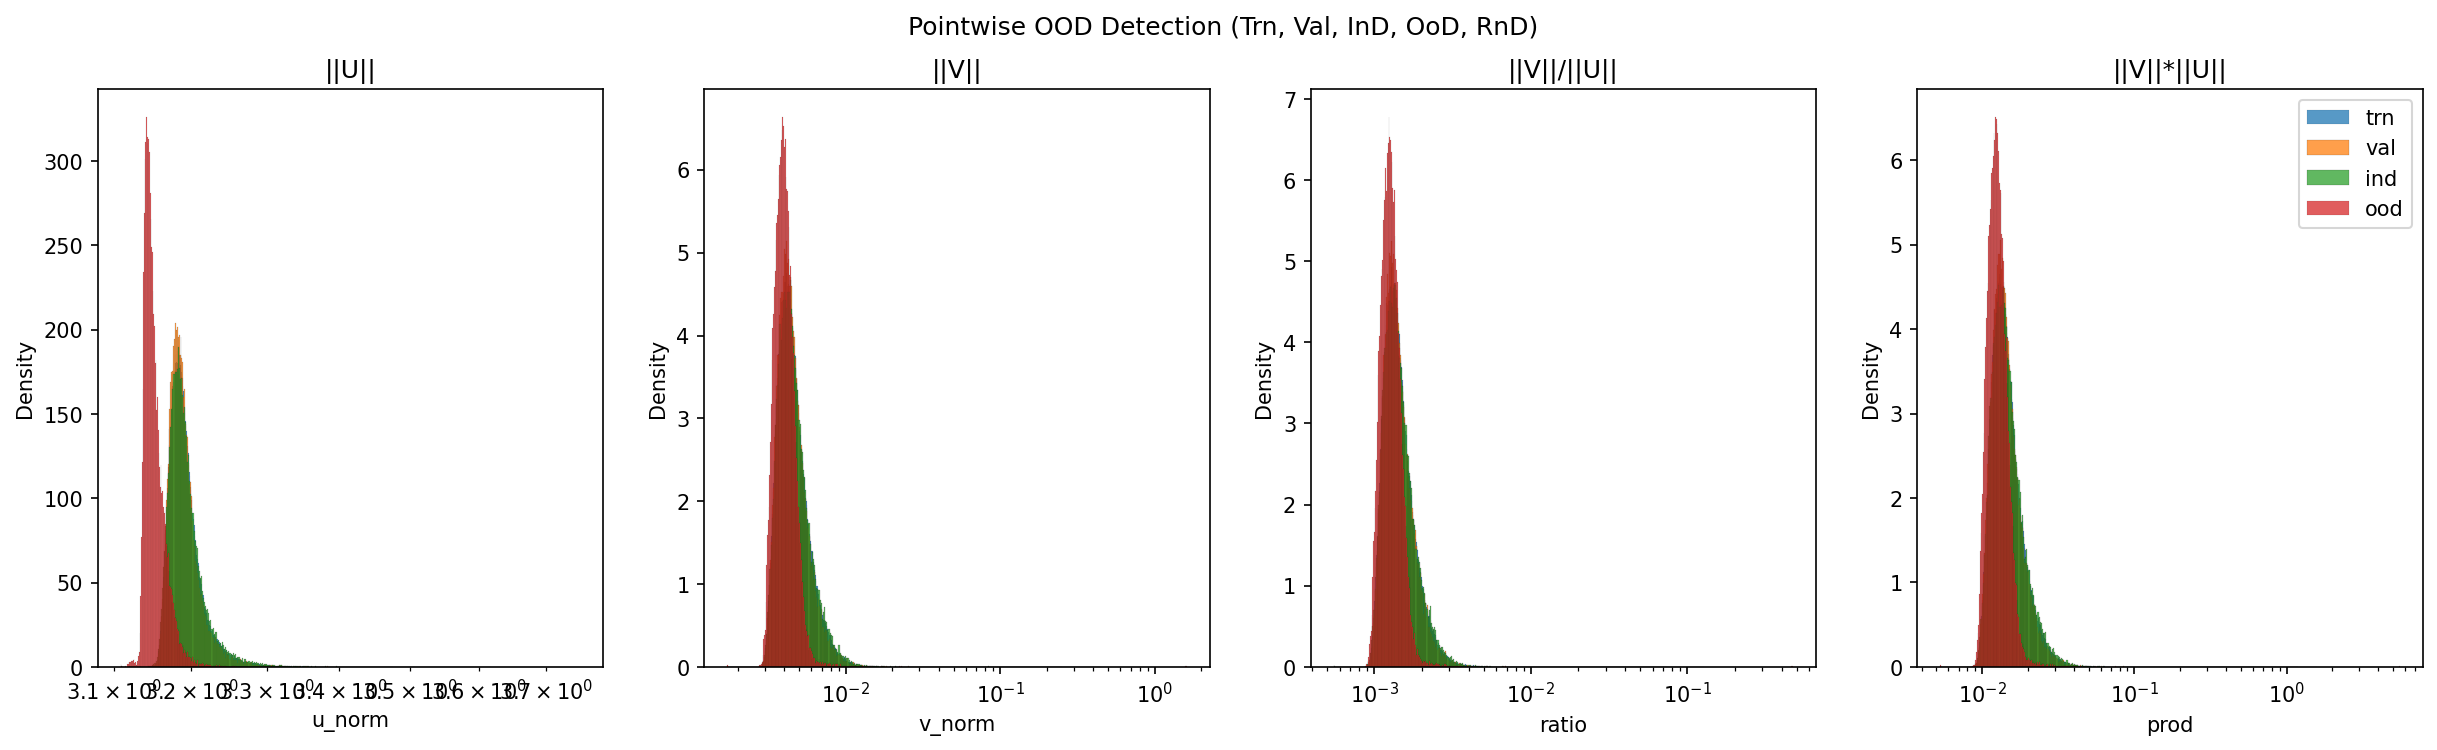

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.0017069677 0.44858032 0.44687337
Val 0.0017069677 0.32771772 0.32601076
Ind 0.0017069677 0.25243923 0.25073227
Ood 0.0017069677 1.6128045 1.6110976
Rnd 9.758944 12.491144 2.7322006
KstestResult(statistic=0.2684828127992762, pvalue=0.0, statistic_location=0.004439802, statistic_sign=-1)


[0 1 2 3 4]


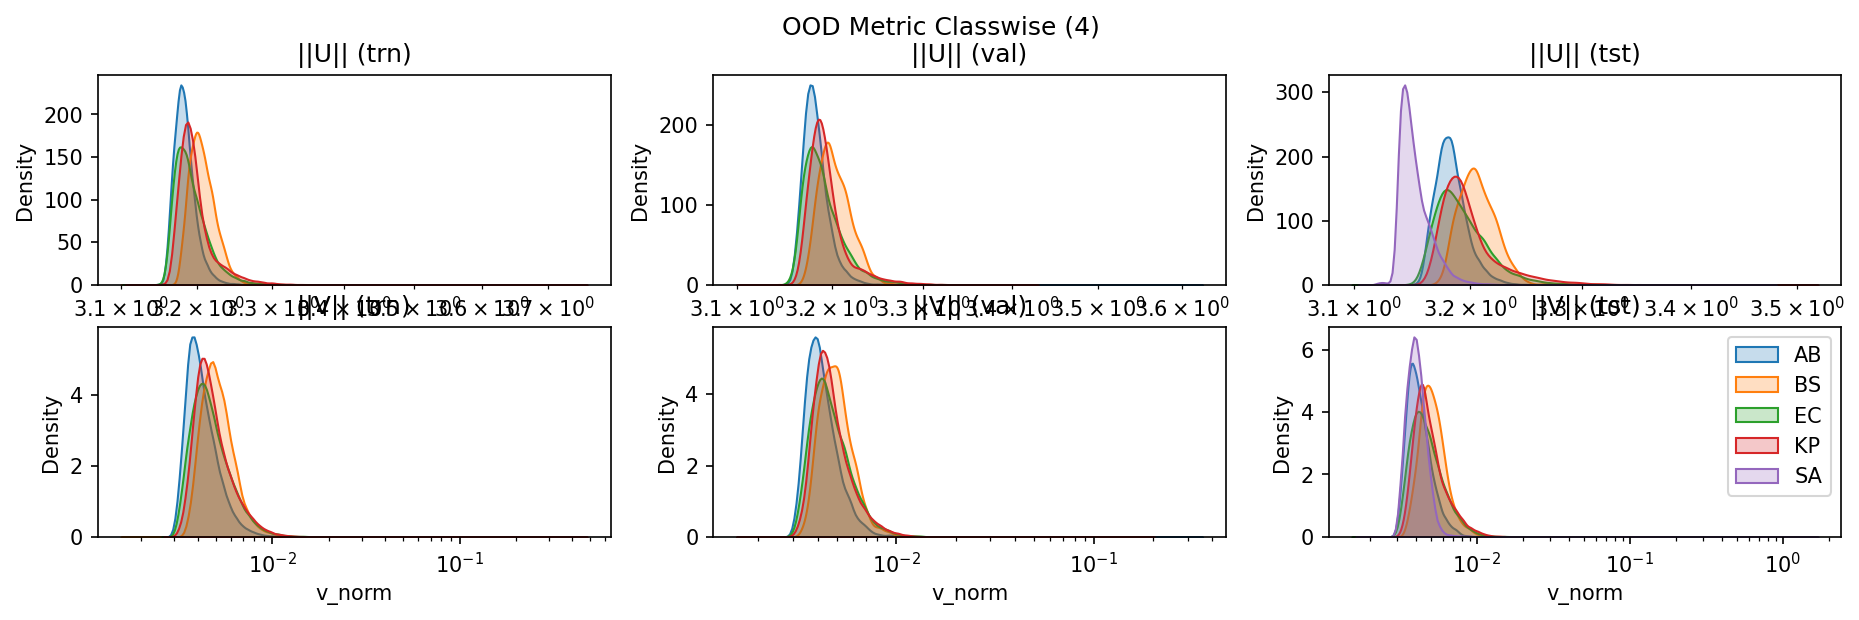

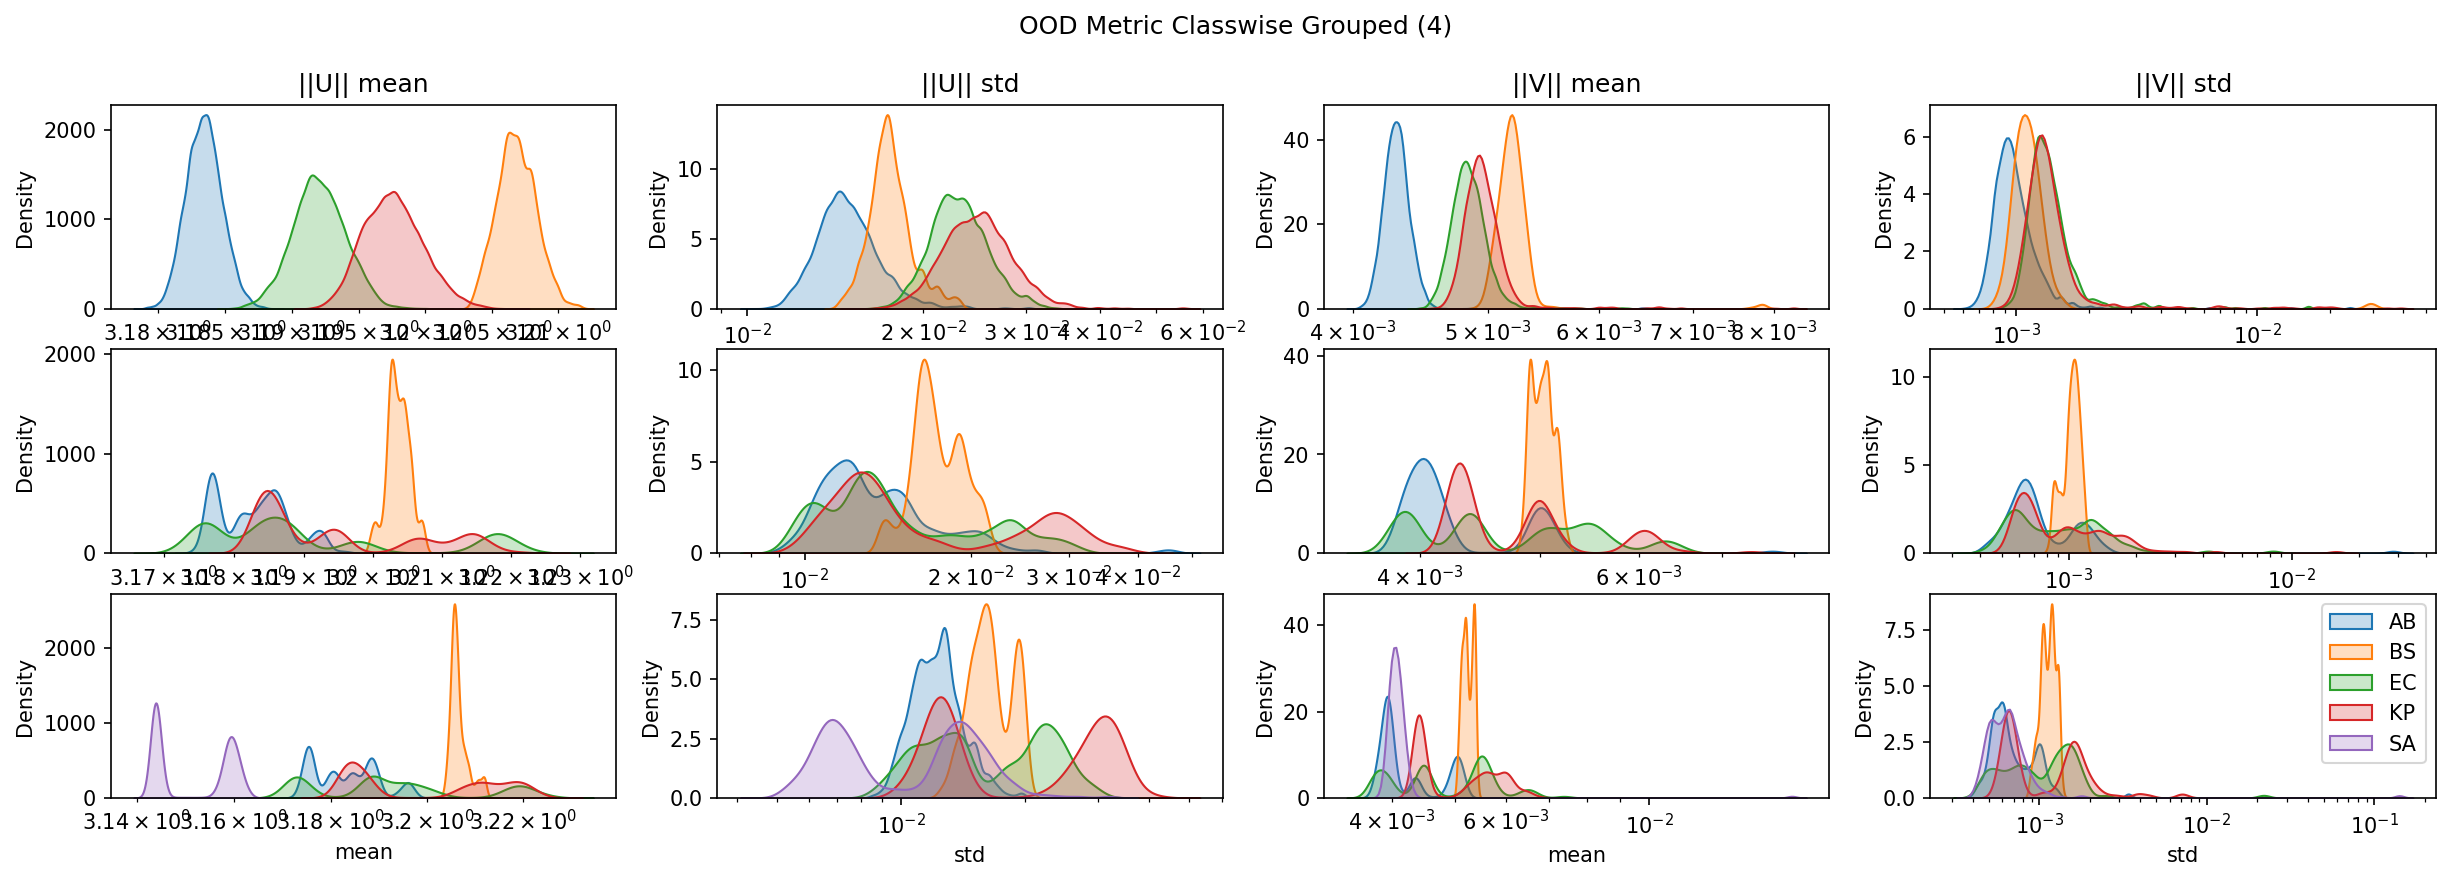

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)